In [967]:
import os
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from datetime import datetime

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import entropy, linregress

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
varns = sorted(['B.1', 'Omicron BA.4/5', 'BA.2.12.1', 'Delta', 'Beta', 'Alpha', 'BA.1'])
pool_colors = {p:c for p, c in zip(varns,
                                   sns.color_palette('gnuplot', len(varns)))}

In [3]:
# bvas = pd.DataFrame()

# root = '../sars-cov2-modeling/'
# dirs = os.listdir(root)
# dirs = [d for d in dirs if '-' in d]
# for d in dirs:
#     if 'BVAS' in os.listdir(root+d):
#         try:
#             muts = pd.read_csv(root+d+'/BVAS/allele_summary.csv')
#             muts['Run date'] = d
#             bvas = pd.concat([muts, bvas]);
#         finally:
#             continue
#         # print(os.listdir(root+d+'/BVAS'))
bvas = pd.read_csv('data/BVAS/BVAS_Ranked_Mutations.tsv', sep='\t')
bvas = bvas.rename(columns={'Unnamed: 0':'Prot:Mut'})
bvas['Run date'] = pd.to_datetime(bvas['Run date'])
bvas = bvas[bvas['Run date']<'2023-09-20']
bvas['Run year'] = bvas['Run date'].dt.to_period('Y').dt.to_timestamp()
bvas_spike = bvas[bvas['Prot:Mut'].apply(lambda x: x.startswith('S:'))]
bvas_spike['Mutation'] = bvas_spike['Prot:Mut'].apply(lambda x: x.strip('S:'))
bvas_spike

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/2181789664.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bvas_spike['Mutation'] = bvas_spike['Prot:Mut'].apply(lambda x: x.strip('S:'))


Prot:Mut       PIP      Beta   BetaStd  ConditionalBeta  \
0       S:L452R  1.000000  0.391635  0.055664         0.391635   
1       S:R346T  1.000000  0.595724  0.039951         0.595724   
2       S:R346K  1.000000  0.351070  0.023070         0.351070   
3       S:L452Q  1.000000  0.483694  0.053569         0.483694   
4       S:L452M  1.000000  0.462981  0.049651         0.462981   
...         ...       ...       ...       ...              ...   
120905   S:T20N  0.007410 -0.000044  0.006266        -0.007221   
120911  S:E619Q  0.007142  0.000143  0.007000         0.006765   
120922  S:T883I  0.006384 -0.000032  0.002077        -0.015706   
120926  S:L981F  0.006202 -0.001770  0.013647        -0.008541   
120930  S:I666V  0.006013  0.000225  0.005430         0.014857   

        ConditionalBetaStd  Rank   Run date   Run year Mutation  
0                 0.055664     1 2021-03-12 2021-01-01    L452R  
1                 0.039951     2 2021-03-12 2021-01-01    R346T  
2                 0.023070     3 2021-03-12 2021-01-01    R346K  
3                 0.053569     4 2021-03-12 2021-01-01    L452Q  
4                 0.049651     5 2021-03-12 2021-01-01    L452M  
...                    ...   ...        ...        ...      ...  
120905            0.079681  3452 2023-09-05 2023-01-01     T20N  
120911            0.047637  3458 2023-09-05 2023-01-01    E619Q  
120922            0.043492  3469 2023-09-05 2023-01-01    T883I  
120926            0.029001  3473 2023-09-05 2023-01-01    L981F  
120930            0.041577  3477 2023-09-05 2023-01-01    I666V  

[20740 rows x 10 columns]

In [4]:
# Pull some infectivity data from Dadonaite et. al., 2024
# https://www.nature.com/articles/s41586-024-07636-1
# Data here: https://github.com/dms-vep/SARS-CoV-2_XBB.1.5_spike_DMS/blob/main/results/summaries/summary.csv
dms = pd.read_csv('https://raw.githubusercontent.com/dms-vep/SARS-CoV-2_XBB.1.5_spike_DMS/refs/heads/main/results/summaries/summary.csv')
dms['Mutation'] = dms['wildtype'].astype(str) + dms['site'].astype(str) + dms['mutant'].astype(str)
dms

site wildtype mutant  human sera escape  spike mediated entry  \
0        2        F      C            0.01114               0.10100   
1        2        F      L            0.01876               0.09432   
2        2        F      S            0.03169               0.05844   
3        2        F      F            0.00000               0.00000   
4        3        V      A            0.02402              -0.04154   
...    ...      ...    ...                ...                   ...   
8345  1211        K      K            0.00000               0.00000   
8346  1212        W      R                NaN              -2.37700   
8347  1212        W      W            0.00000               0.00000   
8348   767        L      L            0.00000               0.00000   
8349   767        L      V                NaN                   NaN   

      ACE2 binding  sequential_site region Mutation  
0          0.02151                2  other      F2C  
1         -0.26980                2  other      F2L  
2         -0.05642                2  other      F2S  
3          0.00000                2  other      F2F  
4         -0.04977                3  other      V3A  
...            ...              ...    ...      ...  
8345       0.00000             1207     S2   K1211K  
8346      -0.21050             1208  other   W1212R  
8347       0.00000             1208  other   W1212W  
8348       0.00000              763     S2    L767L  
8349       1.69700              763     S2    L767V  

[8350 rows x 9 columns]

In [5]:
# Read in our escape data
date = '2025-06-26'
sb = .6

escape_results = torch.load(f'model_covdb/results.{date}.sb{sb}.pt')
escape_traces = escape_results['traces']
escape_data = escape_results['data']

pool_agnostic_effects = pd.DataFrame({'Mutation':escape_data['features'], 'Immune-Agnostic Effect':escape_traces['β'].mean(dim=0)})



pool_specific_effects = pd.DataFrame(columns=escape_data['features'], index=escape_data['pools_map'], data=escape_traces['β_ω'].mean(dim=0)
                                    ).reset_index(
                                    ).melt(id_vars='index', value_vars=None, var_name='Mutation', value_name='Immune-Specific Effect'
                                    ).rename(columns={'index':'Pool'})
# Subset ranges to where we have ample data on each mutation
min_n = 1  # mutation must have been seen at least once
subset = []
for _, row in pool_specific_effects.iterrows():
    pool_idx = (escape_data['pools_map']==row['Pool']).nonzero()[0][0]
    feat_idx = (np.array(escape_data['features'])==row['Mutation']).nonzero()[0][0]
    num_obs = escape_data['X'][escape_data['pools']==pool_idx, feat_idx].sum().item()
    row = dict(row)
    row['N'] = int(num_obs)
    if num_obs >= min_n:
        subset.append(row)
subset = pd.DataFrame(subset)
pool_specific_effects = pd.merge(pool_specific_effects, subset[['Mutation', 'Pool']], on=['Mutation', 'Pool'], how='inner')
pool_specific_effects_piv = pool_specific_effects.pivot(columns='Pool', 
                                                        index='Mutation', 
                                                        values='Immune-Specific Effect'
                                               ).rename(columns={c: f'{c}: Escape' for c in varns})



varns = sorted(['B.1', 'Omicron BA.4/5', 'BA.2.12.1', 'Delta', 'Beta', 'Alpha', 'BA.1'])
pool_colors = {p:c for p, c in zip(varns,
                                   sns.color_palette('gnuplot', len(varns)))}

In [6]:
all_df = pd.merge(
         pd.merge(
                  pd.merge(bvas_spike, dms, on='Mutation', how='outer'),
                  pool_specific_effects_piv, on='Mutation', how='outer'),
               pool_agnostic_effects, on='Mutation', how='outer') 
all_df

Prot:Mut  PIP      Beta   BetaStd  ConditionalBeta  ConditionalBetaStd  \
0      S:L452R  1.0  0.391635  0.055664         0.391635            0.055664   
1      S:L452R  1.0  0.402579  0.056085         0.402579            0.056085   
2      S:L452R  1.0  0.405099  0.059746         0.405099            0.059746   
3      S:L452R  1.0  0.410529  0.056715         0.410529            0.056715   
4      S:L452R  1.0  0.378024  0.063960         0.378024            0.063960   
...        ...  ...       ...       ...              ...                 ...   
28908      NaN  NaN       NaN       NaN              NaN                 NaN   
28909      NaN  NaN       NaN       NaN              NaN                 NaN   
28910      NaN  NaN       NaN       NaN              NaN                 NaN   
28911      NaN  NaN       NaN       NaN              NaN                 NaN   
28912      NaN  NaN       NaN       NaN              NaN                 NaN   

       Rank   Run date   Run year Mutation  ...  sequential_site region  \
0       1.0 2021-03-12 2021-01-01    L452R  ...            448.0    RBD   
1       3.0 2021-03-17 2021-01-01    L452R  ...            448.0    RBD   
2       5.0 2021-03-26 2021-01-01    L452R  ...            448.0    RBD   
3       3.0 2021-03-31 2021-01-01    L452R  ...            448.0    RBD   
4       5.0 2021-04-09 2021-01-01    L452R  ...            448.0    RBD   
...     ...        ...        ...      ...  ...              ...    ...   
28908   NaN        NaT        NaT      Δ74  ...              NaN    NaN   
28909   NaN        NaT        NaT      Δ75  ...              NaN    NaN   
28910   NaN        NaT        NaT      Δ76  ...              NaN    NaN   
28911   NaN        NaT        NaT      Δ77  ...              NaN    NaN   
28912   NaN        NaT        NaT      Δ78  ...              NaN    NaN   

      Alpha: Escape  B.1: Escape  BA.1: Escape  BA.2.12.1: Escape  \
0          0.227733     0.174241      0.366311           0.261384   
1          0.227733     0.174241      0.366311           0.261384   
2          0.227733     0.174241      0.366311           0.261384   
3          0.227733     0.174241      0.366311           0.261384   
4          0.227733     0.174241      0.366311           0.261384   
...             ...          ...           ...                ...   
28908           NaN     0.049136           NaN                NaN   
28909           NaN     0.064921           NaN                NaN   
28910           NaN     0.002668           NaN                NaN   
28911           NaN    -0.010703           NaN                NaN   
28912           NaN     0.032030           NaN                NaN   

       Beta: Escape Delta: Escape  Omicron BA.4/5: Escape  \
0          0.201084      0.241936                0.249669   
1          0.201084      0.241936                0.249669   
2          0.201084      0.241936                0.249669   
3          0.201084      0.241936                0.249669   
4          0.201084      0.241936                0.249669   
...             ...           ...                     ...   
28908           NaN           NaN                0.078671   
28909           NaN           NaN                0.054863   
28910           NaN           NaN               -0.012567   
28911           NaN           NaN               -0.015609   
28912           NaN           NaN               -0.010687   

       Immune-Agnostic Effect  
0                    0.177670  
1                    0.177670  
2                    0.177670  
3                    0.177670  
4                    0.177670  
...                       ...  
28908                0.041396  
28909                0.048006  
28910                0.008449  
28911               -0.013748  
28912               -0.002605  

[28913 rows x 26 columns]

In [7]:
# STANDARD SCALER, NO PIP

def pairwise_regression(group, standard_scaler=True, pip=False):
    predictors = [
        'spike mediated entry', 'ACE2 binding',
        'Alpha: Escape', 'B.1: Escape', 'BA.1: Escape',
        'BA.2.12.1: Escape', 'Beta: Escape', 'Delta: Escape',
        'Omicron BA.4/5: Escape', 'Immune-Agnostic Effect'
    ]
    if pip:
        predictors.append('PIP')
    
    results = []
    for predictor in predictors:
        sub_df = group[['Beta', predictor]].dropna()
        if len(sub_df) < 3:
            continue  # Not enough data to fit a model
        
        X = sub_df[[predictor]].values
        if standard_scaler:
            X = StandardScaler().fit_transform(X)
        y = sub_df['Beta'].values
        model = LinearRegression().fit(X, y)
        coef = model.coef_[0]
        r2 = model.score(X, y)
        
        results.append({
            'Predictor': predictor,
            'Coefficient': coef,
            'R^2': r2
        })
    
    out_df = pd.DataFrame(results)
    out_df['Run period'] = group['Run period'].iloc[0]
    return out_df

def softmax(x):
    e_x = np.exp(x)
    return e_x / np.nansum(e_x)


def rankgrp(x):
    x = np.array(x)
    order = x.argsort()
    rank = order.argsort()
    return rank

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/521466349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leading_varns['R^2 rank'] = (
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/521466349.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leading_varns['Coefficient rank'] = (
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/521466349.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or 

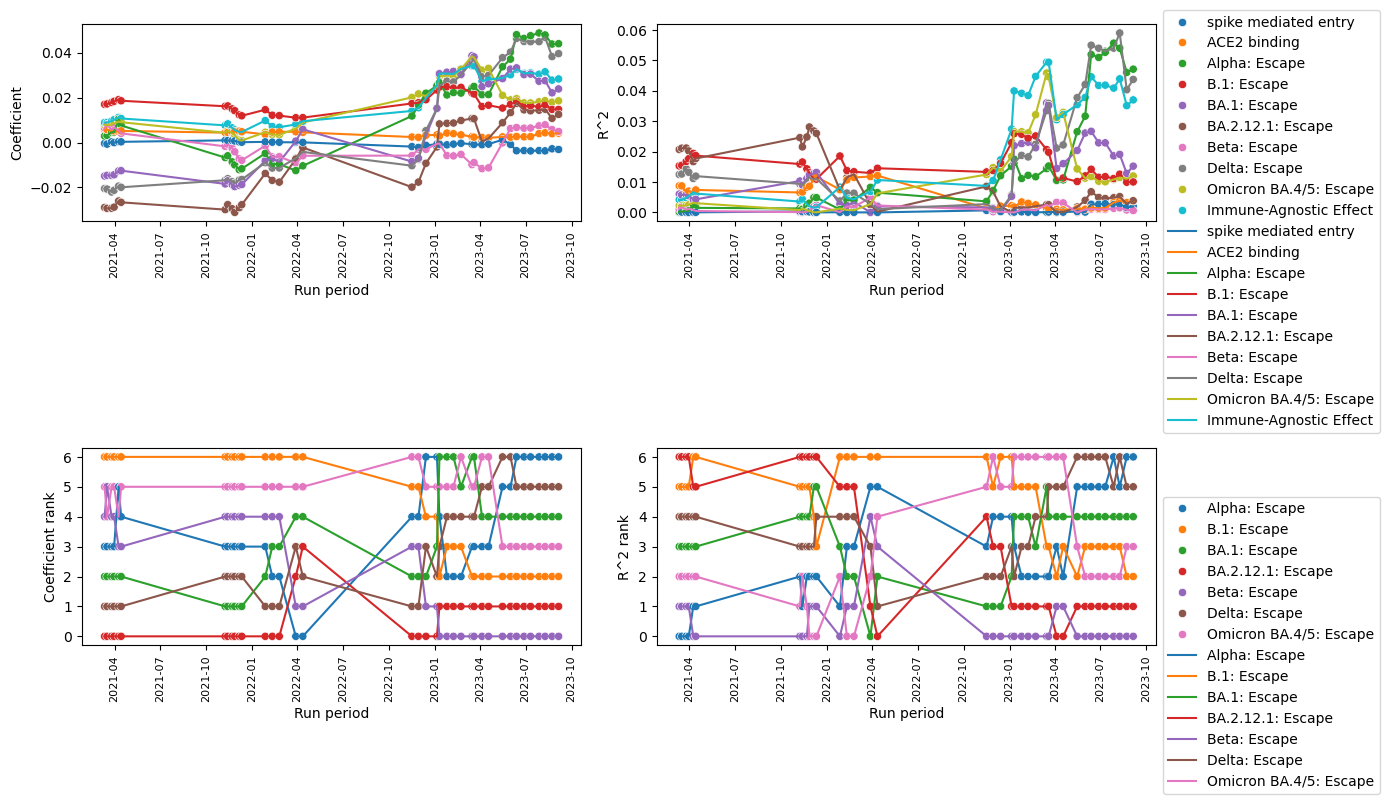

In [8]:
# STANDARD SCALER, NO PIP
regression_df = all_df
regression_df['Run period'] = regression_df['Run date']
regression_results = regression_df.groupby('Run period', group_keys=False
                                 ).apply(lambda x: pairwise_regression(x, standard_scaler=True, pip=False)
                                 ).sort_values(by='Run period'
                                 ).reset_index(drop=True)

leading_varns = regression_results[regression_results['Predictor'].apply(lambda x: x.endswith(': Escape'))]
leading_varns['R^2 rank'] = (
             leading_varns
             .groupby('Run period')['R^2']
             .transform(lambda r2s: rankgrp(r2s.values))
             )
leading_varns['Coefficient rank'] = (
             leading_varns
             .groupby('Run period')['Coefficient']
             .transform(lambda r2s: rankgrp(r2s.values))
             )

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fs = 8

for ax, y in zip(axes[0, :], ['Coefficient', 'R^2']):
    sns.scatterplot(x='Run period',
                    y=y,
                    hue='Predictor',
                    data=regression_results,
                    ax=ax)
    sns.lineplot(   x='Run period',
                    y=y,
                    hue='Predictor',
                    data=regression_results,
                    ax=ax)

    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

axes[0, 0].legend().set_visible(False);
axes[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0));


for ax, y in zip(axes[1, :], ['Coefficient rank', 'R^2 rank']):
    sns.scatterplot(x='Run period',
                    y=y,
                    hue='Predictor',
                    data=leading_varns,
                    ax=ax)
    sns.lineplot(   x='Run period',
                    y=y,
                    hue='Predictor',
                    data=leading_varns,
                    ax=ax)

    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

axes[1, 0].legend().set_visible(False);
axes[1, 1].legend(loc='center left', bbox_to_anchor=(1, 0));

fig.tight_layout();

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/2290707220.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leading_varns['R^2 rank'] = (
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/2290707220.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leading_varns['Coefficient rank'] = (
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/2290707220.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() 

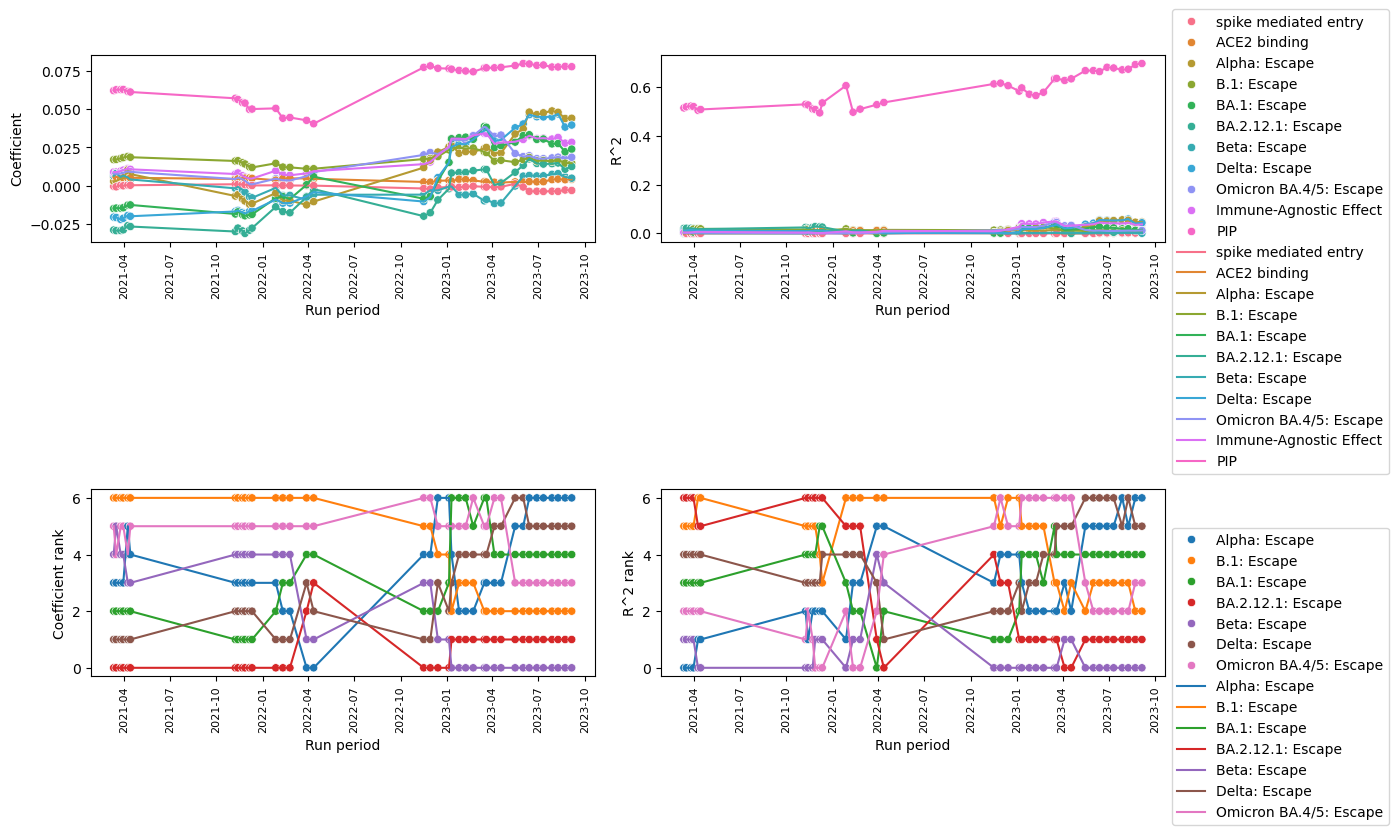

In [9]:
# STANDARD SCALER, PIP
regression_df = all_df
regression_df['Run period'] = regression_df['Run date']
regression_results = regression_df.groupby('Run period', group_keys=False
                                 ).apply(lambda x: pairwise_regression(x, standard_scaler=True, pip=True)
                                 ).sort_values(by='Run period'
                                 ).reset_index(drop=True)

leading_varns = regression_results[regression_results['Predictor'].apply(lambda x: x.endswith(': Escape'))]
leading_varns['R^2 rank'] = (
             leading_varns
             .groupby('Run period')['R^2']
             .transform(lambda r2s: rankgrp(r2s.values))
             )
leading_varns['Coefficient rank'] = (
             leading_varns
             .groupby('Run period')['Coefficient']
             .transform(lambda r2s: rankgrp(r2s.values))
             )

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fs = 8

for ax, y in zip(axes[0, :], ['Coefficient', 'R^2']):
    sns.scatterplot(x='Run period',
                    y=y,
                    hue='Predictor',
                    data=regression_results,
                    ax=ax)
    sns.lineplot(   x='Run period',
                    y=y,
                    hue='Predictor',
                    data=regression_results,
                    ax=ax)

    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

axes[0, 0].legend().set_visible(False);
axes[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0));


for ax, y in zip(axes[1, :], ['Coefficient rank', 'R^2 rank']):
    sns.scatterplot(x='Run period',
                    y=y,
                    hue='Predictor',
                    data=leading_varns,
                    ax=ax)
    sns.lineplot(   x='Run period',
                    y=y,
                    hue='Predictor',
                    data=leading_varns,
                    ax=ax)

    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

axes[1, 0].legend().set_visible(False);
axes[1, 1].legend(loc='center left', bbox_to_anchor=(1, 0));

fig.tight_layout();

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/910861861.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leading_varns['R^2 rank'] = (
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/910861861.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leading_varns['Coefficient rank'] = (
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/910861861.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or 

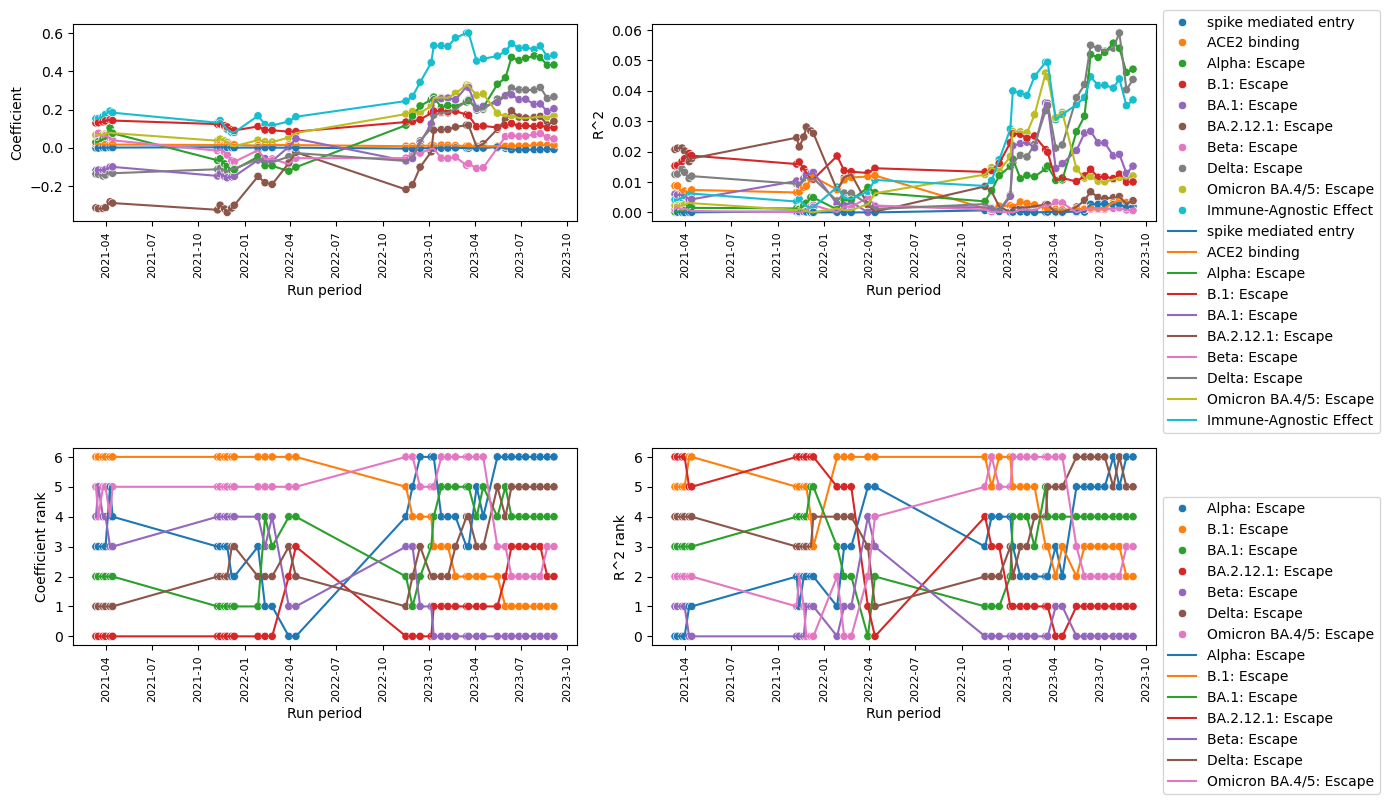

In [10]:
# NO STANDARD SCALER, NO PIP
regression_df = all_df
regression_df['Run period'] = regression_df['Run date']
regression_results = regression_df.groupby('Run period', group_keys=False
                                 ).apply(lambda x: pairwise_regression(x, standard_scaler=False, pip=False)
                                 ).sort_values(by='Run period'
                                 ).reset_index(drop=True)

leading_varns = regression_results[regression_results['Predictor'].apply(lambda x: x.endswith(': Escape'))]
leading_varns['R^2 rank'] = (
             leading_varns
             .groupby('Run period')['R^2']
             .transform(lambda r2s: rankgrp(r2s.values))
             )
leading_varns['Coefficient rank'] = (
             leading_varns
             .groupby('Run period')['Coefficient']
             .transform(lambda r2s: rankgrp(r2s.values))
             )

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fs = 8

for ax, y in zip(axes[0, :], ['Coefficient', 'R^2']):
    sns.scatterplot(x='Run period',
                    y=y,
                    hue='Predictor',
                    data=regression_results,
                    ax=ax)
    sns.lineplot(   x='Run period',
                    y=y,
                    hue='Predictor',
                    data=regression_results,
                    ax=ax)

    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

axes[0, 0].legend().set_visible(False);
axes[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0));


for ax, y in zip(axes[1, :], ['Coefficient rank', 'R^2 rank']):
    sns.scatterplot(x='Run period',
                    y=y,
                    hue='Predictor',
                    data=leading_varns,
                    ax=ax)
    sns.lineplot(   x='Run period',
                    y=y,
                    hue='Predictor',
                    data=leading_varns,
                    ax=ax)

    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

axes[1, 0].legend().set_visible(False);
axes[1, 1].legend(loc='center left', bbox_to_anchor=(1, 0));

fig.tight_layout();

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/820008075.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leading_varns['R^2 rank'] = (
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/820008075.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leading_varns['Coefficient rank'] = (
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/820008075.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or u

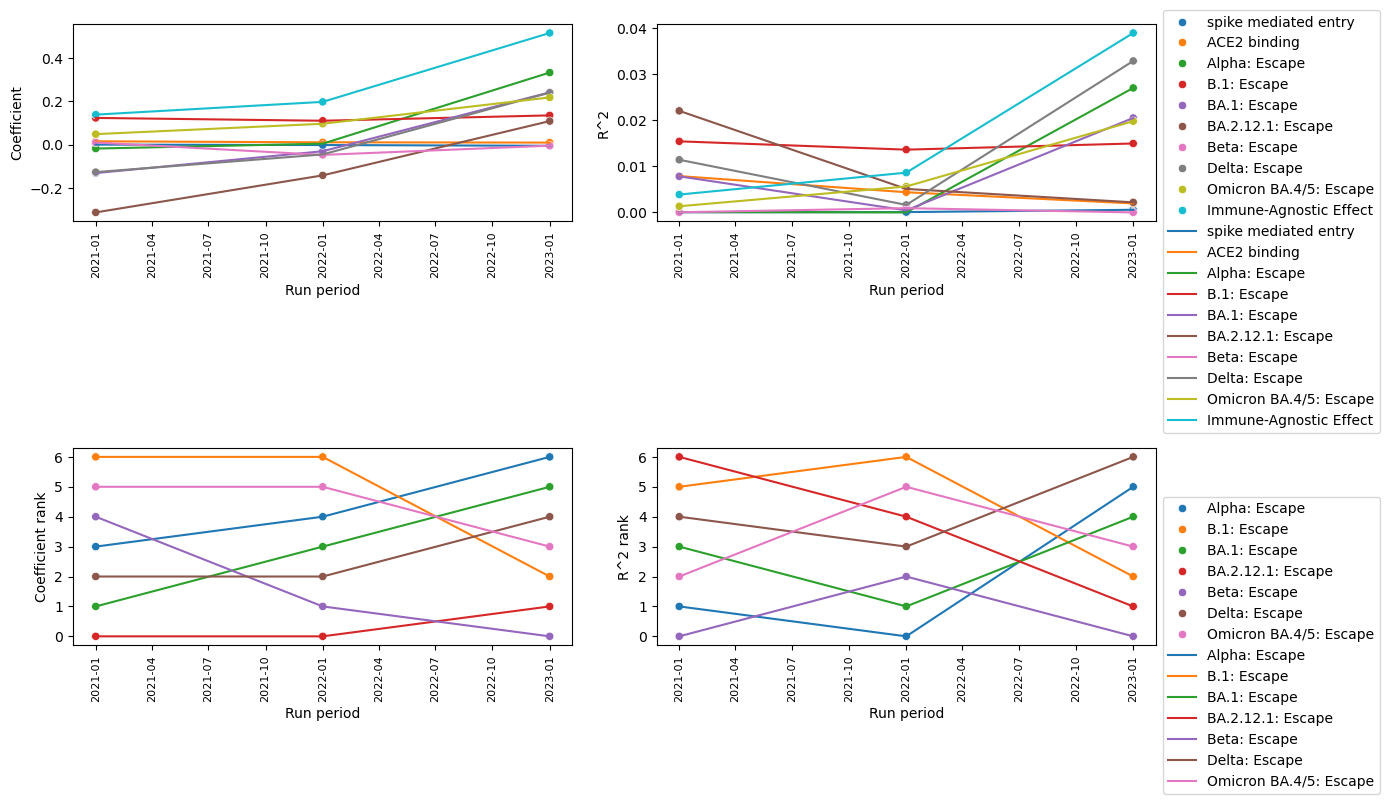

In [11]:
regression_df = all_df
regression_df['Run period'] = regression_df['Run year']
regression_results = regression_df.groupby('Run period', group_keys=False
                                 ).apply(lambda x: pairwise_regression(x, standard_scaler=False, pip=False)
                                 ).sort_values(by='Run period'
                                 ).reset_index(drop=True)

leading_varns = regression_results[regression_results['Predictor'].apply(lambda x: x.endswith(': Escape'))]
leading_varns['R^2 rank'] = (
             leading_varns
             .groupby('Run period')['R^2']
             .transform(lambda r2s: rankgrp(r2s.values))
             )
leading_varns['Coefficient rank'] = (
             leading_varns
             .groupby('Run period')['Coefficient']
             .transform(lambda r2s: rankgrp(r2s.values))
             )

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fs = 8

for ax, y in zip(axes[0, :], ['Coefficient', 'R^2']):
    sns.scatterplot(x='Run period',
                    y=y,
                    hue='Predictor',
                    data=regression_results,
                    ax=ax)
    sns.lineplot(   x='Run period',
                    y=y,
                    hue='Predictor',
                    data=regression_results,
                    ax=ax)

    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

axes[0, 0].legend().set_visible(False);
axes[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0));


for ax, y in zip(axes[1, :], ['Coefficient rank', 'R^2 rank']):
    sns.scatterplot(x='Run period',
                    y=y,
                    hue='Predictor',
                    data=leading_varns,
                    ax=ax)
    sns.lineplot(   x='Run period',
                    y=y,
                    hue='Predictor',
                    data=leading_varns,
                    ax=ax)

    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

axes[1, 0].legend().set_visible(False);
axes[1, 1].legend(loc='center left', bbox_to_anchor=(1, 0));

fig.tight_layout();

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/2079285877.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)


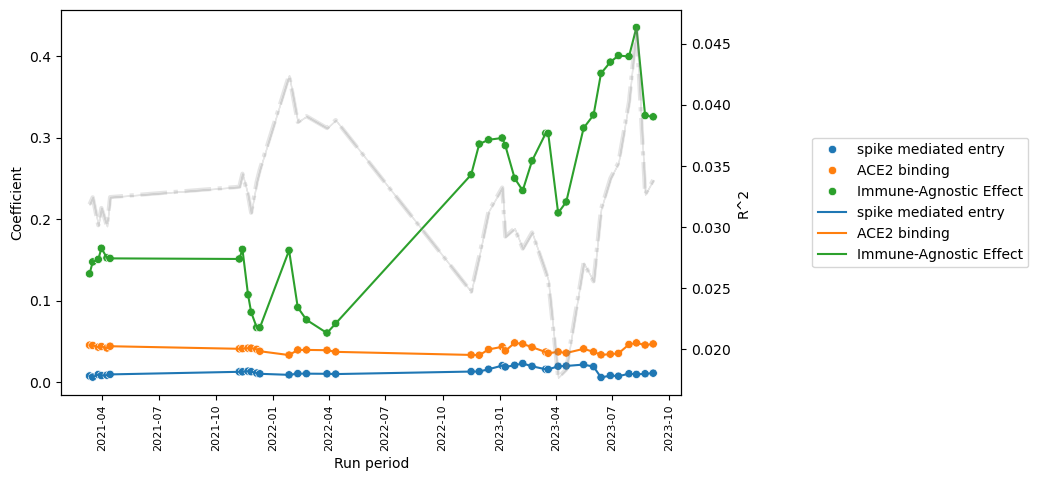

In [12]:
def inf_neut_regress(grp):
    predictors = ['spike mediated entry', 'ACE2 binding', 'Immune-Agnostic Effect']
    
    results = []
    sub_df = grp[['Beta'] + predictors].dropna()
    X = sub_df[predictors].dropna()
    y = sub_df['Beta'].values
    model = LinearRegression().fit(X, y)
    coefs = model.coef_
    r2 = model.score(X, y)
    
    result_dict = {p:c for p, c in zip(predictors, coefs)}
    result_dict['R^2'] = r2
    results.append(result_dict)
    
    out_df = pd.DataFrame(results)
    out_df['Run period'] = grp['Run period'].iloc[0]
    return out_df

regression_df['Run period'] = regression_df['Run date']
regression_results = regression_df.groupby('Run period', group_keys=False
                                 ).apply(inf_neut_regress
                                 ).sort_values(by='Run period'
                                 ).reset_index(drop=True)
regression_results = regression_results.melt(id_vars=['Run period', 'R^2'],
                                             value_vars=['spike mediated entry', 'ACE2 binding', 'Immune-Agnostic Effect'],
                                             var_name='Predictor',
                                             value_name='Coefficient')


fig, ax = plt.subplots(figsize=(8, 5))
fs = 8

sns.scatterplot(x='Run period',
                y='Coefficient',
                hue='Predictor',
                data=regression_results,
                ax=ax)
sns.lineplot(   x='Run period',
                y='Coefficient',
                hue='Predictor',
                data=regression_results,
                ax=ax)
ax2 = ax.twinx()
sns.lineplot(x='Run period',
             y='R^2',
             data=regression_results,
             linestyle='-.',
             color='tab:gray',
             alpha=0.2,
             linewidth=3,
             ax=ax2);

xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.5));

In [13]:
min_date = bvas['Run date'].min()
max_date = bvas['Run date'].max()
gisaid = pd.DataFrame()
with tarfile.open('/Users/kotzen/Downloads/metadata_tsv_2025_05_25.tar.xz', 'r:*') as tar:
    member = next(m for m in tar.getmembers() if m.name.endswith('metadata.tsv'))
    file_obj = tar.extractfile(member)
    for chunk in tqdm(pd.read_csv(file_obj, sep='\t', chunksize=100000)):
        subset = chunk[chunk['Pango lineage'].apply(lambda x: x in ['B.1.1.7', #'Alpha',
                                                                    'A', 'B', # B.1
                                                                    'B.1',
                                                                    'BA.1',
                                                                    'BA.2.12.1',
                                                                    'B.1.351', #'Beta',
                                                                    'B.1.617.2', #'Delta',
                                                                    'BA.4', 'BA.5' #Omicron BA.4/5'
                                                                    ])]
        gisaid = pd.concat([gisaid, subset[['Collection date', 'Submission date', 'Pango lineage']]])
gisaid['Pango lineage'] = gisaid['Pango lineage'].apply(lambda x: { 'B.1.1.7':'Alpha',
                                                                    'A':'B.1',
                                                                    'B':'B.1',
                                                                    'B.1':'B.1',
                                                                    'BA.1':'BA.1',
                                                                    'BA.2.12.1':'BA.2.12.1',
                                                                    'B.1.351':'Beta',
                                                                    'B.1.617.2':'Delta',
                                                                    'BA.4':'Omicron BA.4/5', 
                                                                    'BA.5':'Omicron BA.4/5'}[x])

def parse_mixed_date(date_str):
    if pd.isna(date_str):
        return pd.NaT

    for fmt in ("%Y-%m-%d", "%Y-%m", "%Y"):
        try:
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    return pd.NaT
gisaid['Collection date'] = gisaid['Collection date'].apply(parse_mixed_date)
gisaid['Submission date'] = gisaid['Submission date'].apply(parse_mixed_date)

85it [01:57,  1.45s/it]/Users/kotzen/opt/anaconda3/envs/pyro/lib/python3.10/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
173it [04:02,  1.40s/it]


/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/2385093978.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90);


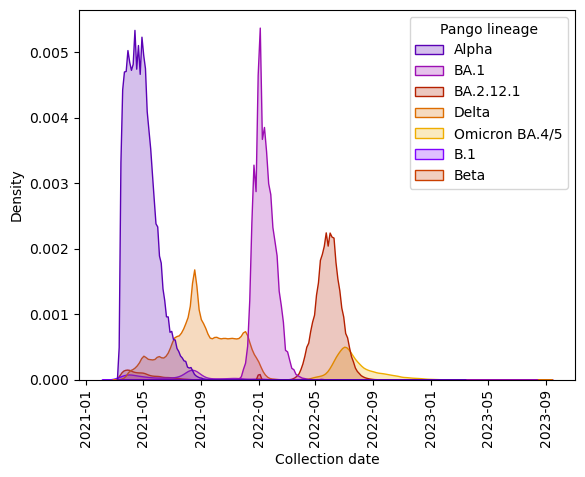

In [14]:
fig, ax = plt.subplots()

date_col = 'Collection date'
sns.kdeplot(x=date_col,
            data=gisaid[(gisaid[date_col]>min_date) & (gisaid[date_col]<max_date)],
            hue='Pango lineage',
            palette=pool_colors,
            fill=True,
            ax=ax);

ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

## Use Starr Dataset

In [15]:
# Pull some infectivity data from Starr, et. al., 2020
# https://pmc.ncbi.nlm.nih.gov/articles/PMC7418704/
# Data here: https://media.githubusercontent.com/media/jbloomlab/SARS-CoV-2-RBD_DMS/refs/heads/master/results/single_mut_effects/single_mut_effects.csv
dms = pd.read_csv('https://media.githubusercontent.com/media/jbloomlab/SARS-CoV-2-RBD_DMS/refs/heads/master/results/single_mut_effects/single_mut_effects.csv')
dms['Mutation'] = dms['wildtype'].astype(str) + dms['site_SARS2'].astype(str) + dms['mutant'].astype(str)
dms

site_RBD  site_SARS2 wildtype mutant mutation mutation_RBD  bind_lib1  \
0            1         331        N      A    N331A          N1A      -0.05   
1            1         331        N      C    N331C          N1C      -0.08   
2            1         331        N      D    N331D          N1D       0.00   
3            1         331        N      E    N331E          N1E       0.02   
4            1         331        N      F    N331F          N1F      -0.03   
...        ...         ...      ...    ...      ...          ...        ...   
4216       201         531        T      T    T531T        T201T       0.00   
4217       201         531        T      V    T531V        T201V       0.03   
4218       201         531        T      W    T531W        T201W       0.02   
4219       201         531        T      Y    T531Y        T201Y       0.00   
4220       201         531        T      *    T531*        T201*        NaN   

      bind_lib2  bind_avg  expr_lib1  expr_lib2  expr_avg Mutation  
0         -0.02     -0.03      -0.14      -0.08     -0.11    N331A  
1         -0.10     -0.09      -1.56      -0.97     -1.26    N331C  
2          0.07      0.03      -0.75      -0.12     -0.44    N331D  
3         -0.02      0.00      -0.39      -0.24     -0.31    N331E  
4         -0.16     -0.10      -0.83      -0.57     -0.70    N331F  
...         ...       ...        ...        ...       ...      ...  
4216       0.00      0.00       0.00       0.00      0.00    T531T  
4217      -0.02      0.01      -0.07      -0.05     -0.06    T531V  
4218      -0.06     -0.02      -0.13      -0.04     -0.08    T531W  
4219      -0.03     -0.01      -0.03      -0.08     -0.05    T531Y  
4220        NaN       NaN      -4.59      -4.51     -4.55    T531*  

[4221 rows x 13 columns]

In [16]:
all_df = pd.merge(
         pd.merge(
                  pd.merge(bvas_spike, dms, on='Mutation', how='outer'),
                  pool_specific_effects_piv, on='Mutation', how='outer'),
               pool_agnostic_effects, on='Mutation', how='outer') 
all_df

Prot:Mut  PIP      Beta   BetaStd  ConditionalBeta  ConditionalBetaStd  \
0      S:L452R  1.0  0.391635  0.055664         0.391635            0.055664   
1      S:L452R  1.0  0.402579  0.056085         0.402579            0.056085   
2      S:L452R  1.0  0.405099  0.059746         0.405099            0.059746   
3      S:L452R  1.0  0.410529  0.056715         0.410529            0.056715   
4      S:L452R  1.0  0.378024  0.063960         0.378024            0.063960   
...        ...  ...       ...       ...              ...                 ...   
25341      NaN  NaN       NaN       NaN              NaN                 NaN   
25342      NaN  NaN       NaN       NaN              NaN                 NaN   
25343      NaN  NaN       NaN       NaN              NaN                 NaN   
25344      NaN  NaN       NaN       NaN              NaN                 NaN   
25345      NaN  NaN       NaN       NaN              NaN                 NaN   

       Rank   Run date   Run year Mutation  ...  expr_lib2  expr_avg  \
0       1.0 2021-03-12 2021-01-01    L452R  ...       0.44      0.32   
1       3.0 2021-03-17 2021-01-01    L452R  ...       0.44      0.32   
2       5.0 2021-03-26 2021-01-01    L452R  ...       0.44      0.32   
3       3.0 2021-03-31 2021-01-01    L452R  ...       0.44      0.32   
4       5.0 2021-04-09 2021-01-01    L452R  ...       0.44      0.32   
...     ...        ...        ...      ...  ...        ...       ...   
25341   NaN        NaT        NaT      Δ74  ...        NaN       NaN   
25342   NaN        NaT        NaT      Δ75  ...        NaN       NaN   
25343   NaN        NaT        NaT      Δ76  ...        NaN       NaN   
25344   NaN        NaT        NaT      Δ77  ...        NaN       NaN   
25345   NaN        NaT        NaT      Δ78  ...        NaN       NaN   

      Alpha: Escape B.1: Escape BA.1: Escape BA.2.12.1: Escape  Beta: Escape  \
0          0.227733    0.174241     0.366311          0.261384      0.201084   
1          0.227733    0.174241     0.366311          0.261384      0.201084   
2          0.227733    0.174241     0.366311          0.261384      0.201084   
3          0.227733    0.174241     0.366311          0.261384      0.201084   
4          0.227733    0.174241     0.366311          0.261384      0.201084   
...             ...         ...          ...               ...           ...   
25341           NaN    0.049136          NaN               NaN           NaN   
25342           NaN    0.064921          NaN               NaN           NaN   
25343           NaN    0.002668          NaN               NaN           NaN   
25344           NaN   -0.010703          NaN               NaN           NaN   
25345           NaN    0.032030          NaN               NaN           NaN   

       Delta: Escape  Omicron BA.4/5: Escape  Immune-Agnostic Effect  
0           0.241936                0.249669                0.177670  
1           0.241936                0.249669                0.177670  
2           0.241936                0.249669                0.177670  
3           0.241936                0.249669                0.177670  
4           0.241936                0.249669                0.177670  
...              ...                     ...                     ...  
25341            NaN                0.078671                0.041396  
25342            NaN                0.054863                0.048006  
25343            NaN               -0.012567                0.008449  
25344            NaN               -0.015609               -0.013748  
25345            NaN               -0.010687               -0.002605  

[25346 rows x 30 columns]

In [17]:
def pairwise_regression(group, standard_scaler=True, pip=False):
    predictors = [
        'bind_avg', 'expr_avg',
        'Alpha: Escape', 'B.1: Escape', 'BA.1: Escape',
        'BA.2.12.1: Escape', 'Beta: Escape', 'Delta: Escape',
        'Omicron BA.4/5: Escape', 'Immune-Agnostic Effect'
    ]
    if pip:
        predictors.append('PIP')
    
    results = []
    for predictor in predictors:
        sub_df = group[['Beta', predictor]].dropna()
        if len(sub_df) < 3:
            continue  # Not enough data to fit a model
        
        X = sub_df[[predictor]].values
        if standard_scaler:
            X = StandardScaler().fit_transform(X)
        y = sub_df['Beta'].values
        model = LinearRegression().fit(X, y)
        coef = model.coef_[0]
        r2 = model.score(X, y)
        
        results.append({
            'Predictor': predictor,
            'Coefficient': coef,
            'R^2': r2
        })
    
    out_df = pd.DataFrame(results)
    out_df['Run period'] = group['Run period'].iloc[0]
    return out_df

def softmax(x):
    e_x = np.exp(x)
    return e_x / np.nansum(e_x)


def rankgrp(x):
    x = np.array(x)
    order = x.argsort()
    rank = order.argsort()
    return rank

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/521466349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leading_varns['R^2 rank'] = (
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/521466349.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leading_varns['Coefficient rank'] = (
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/521466349.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or 

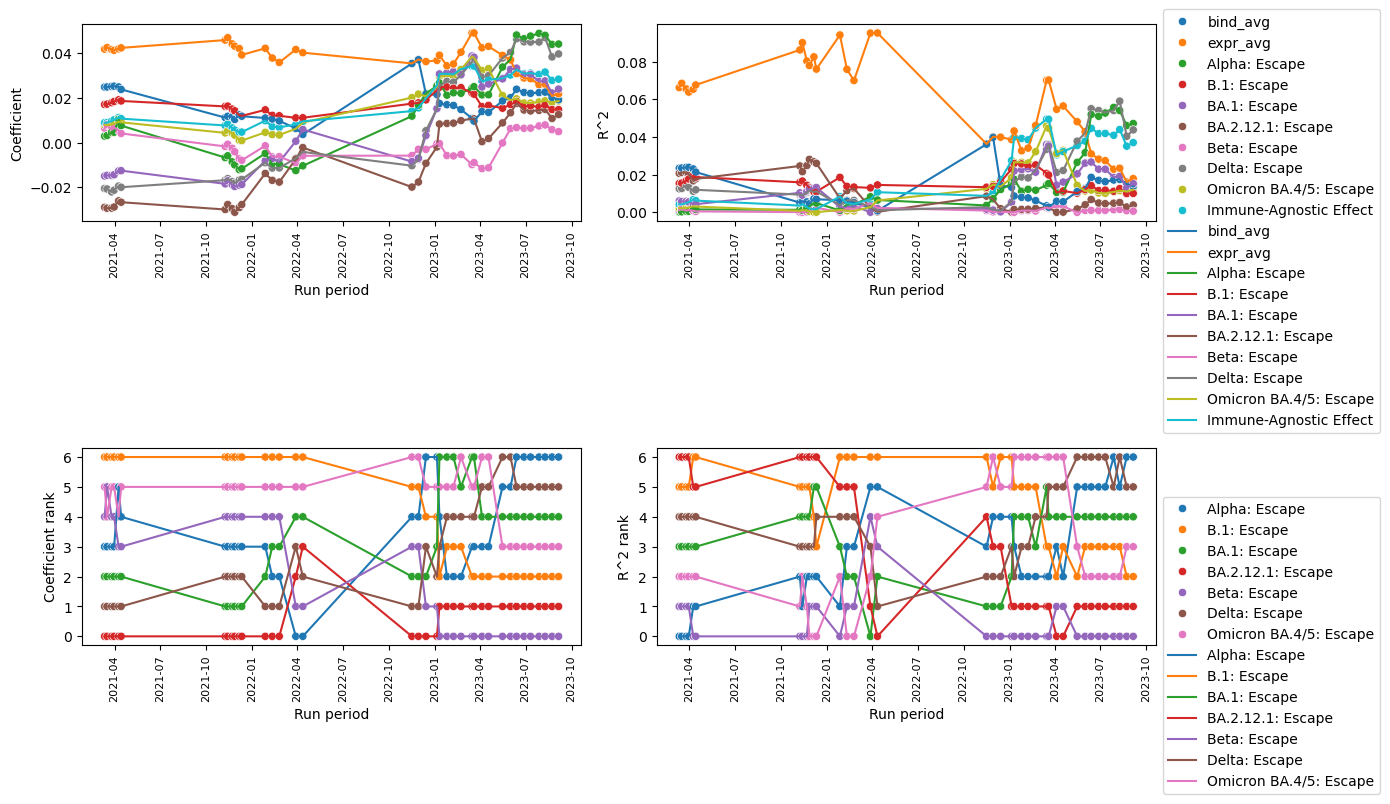

In [18]:
# STANDARD SCALER, NO PIP
regression_df = all_df
regression_df['Run period'] = regression_df['Run date']
regression_results = regression_df.groupby('Run period', group_keys=False
                                 ).apply(lambda x: pairwise_regression(x, standard_scaler=True, pip=False)
                                 ).sort_values(by='Run period'
                                 ).reset_index(drop=True)

leading_varns = regression_results[regression_results['Predictor'].apply(lambda x: x.endswith(': Escape'))]
leading_varns['R^2 rank'] = (
             leading_varns
             .groupby('Run period')['R^2']
             .transform(lambda r2s: rankgrp(r2s.values))
             )
leading_varns['Coefficient rank'] = (
             leading_varns
             .groupby('Run period')['Coefficient']
             .transform(lambda r2s: rankgrp(r2s.values))
             )

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fs = 8

for ax, y in zip(axes[0, :], ['Coefficient', 'R^2']):
    sns.scatterplot(x='Run period',
                    y=y,
                    hue='Predictor',
                    data=regression_results,
                    ax=ax)
    sns.lineplot(   x='Run period',
                    y=y,
                    hue='Predictor',
                    data=regression_results,
                    ax=ax)

    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

axes[0, 0].legend().set_visible(False);
axes[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0));


for ax, y in zip(axes[1, :], ['Coefficient rank', 'R^2 rank']):
    sns.scatterplot(x='Run period',
                    y=y,
                    hue='Predictor',
                    data=leading_varns,
                    ax=ax)
    sns.lineplot(   x='Run period',
                    y=y,
                    hue='Predictor',
                    data=leading_varns,
                    ax=ax)

    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

axes[1, 0].legend().set_visible(False);
axes[1, 1].legend(loc='center left', bbox_to_anchor=(1, 0));

fig.tight_layout();

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/2290707220.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leading_varns['R^2 rank'] = (
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/2290707220.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leading_varns['Coefficient rank'] = (
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/2290707220.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() 

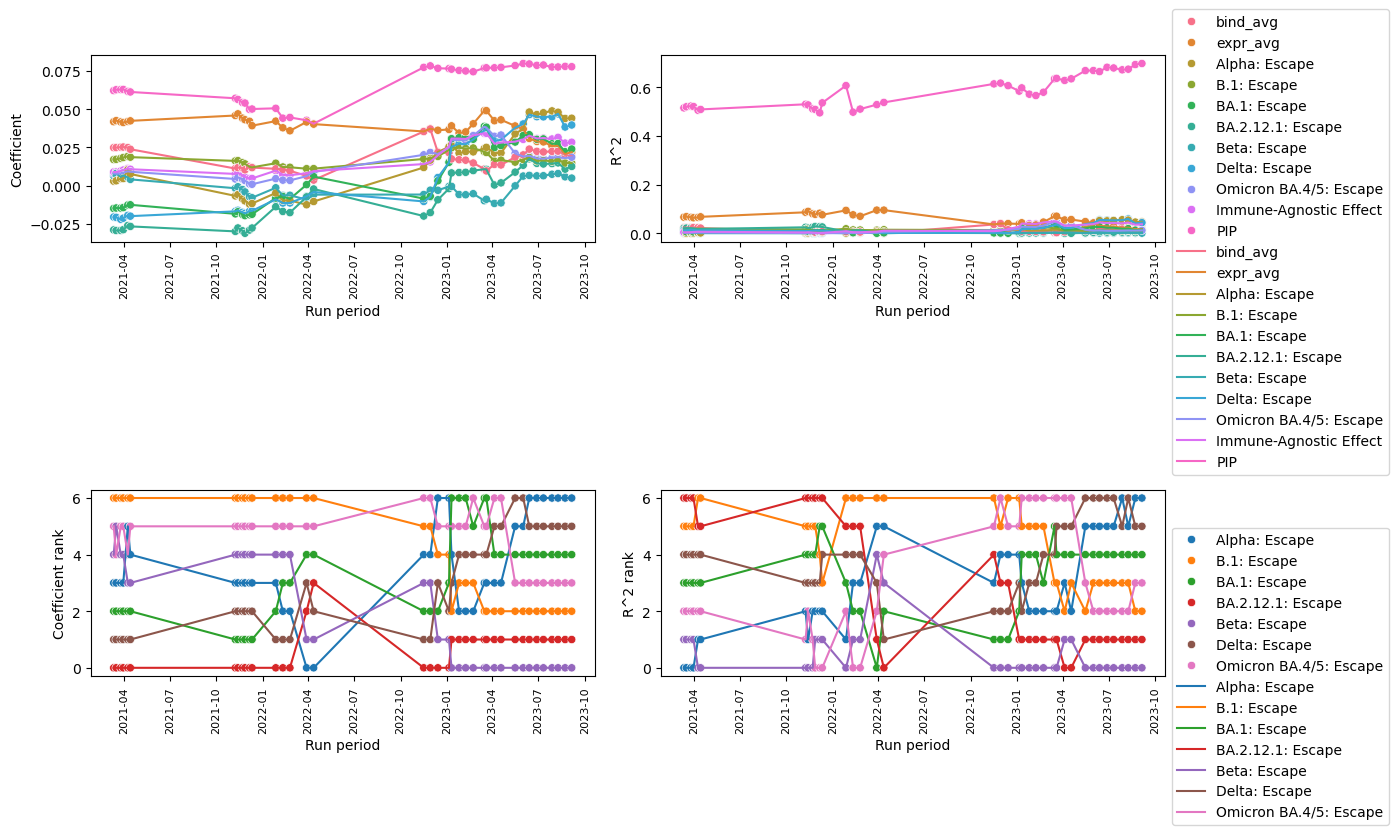

In [19]:
# STANDARD SCALER, PIP
regression_df = all_df
regression_df['Run period'] = regression_df['Run date']
regression_results = regression_df.groupby('Run period', group_keys=False
                                 ).apply(lambda x: pairwise_regression(x, standard_scaler=True, pip=True)
                                 ).sort_values(by='Run period'
                                 ).reset_index(drop=True)

leading_varns = regression_results[regression_results['Predictor'].apply(lambda x: x.endswith(': Escape'))]
leading_varns['R^2 rank'] = (
             leading_varns
             .groupby('Run period')['R^2']
             .transform(lambda r2s: rankgrp(r2s.values))
             )
leading_varns['Coefficient rank'] = (
             leading_varns
             .groupby('Run period')['Coefficient']
             .transform(lambda r2s: rankgrp(r2s.values))
             )

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fs = 8

for ax, y in zip(axes[0, :], ['Coefficient', 'R^2']):
    sns.scatterplot(x='Run period',
                    y=y,
                    hue='Predictor',
                    data=regression_results,
                    ax=ax)
    sns.lineplot(   x='Run period',
                    y=y,
                    hue='Predictor',
                    data=regression_results,
                    ax=ax)

    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

axes[0, 0].legend().set_visible(False);
axes[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0));


for ax, y in zip(axes[1, :], ['Coefficient rank', 'R^2 rank']):
    sns.scatterplot(x='Run period',
                    y=y,
                    hue='Predictor',
                    data=leading_varns,
                    ax=ax)
    sns.lineplot(   x='Run period',
                    y=y,
                    hue='Predictor',
                    data=leading_varns,
                    ax=ax)

    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

axes[1, 0].legend().set_visible(False);
axes[1, 1].legend(loc='center left', bbox_to_anchor=(1, 0));

fig.tight_layout();

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/910861861.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leading_varns['R^2 rank'] = (
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/910861861.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leading_varns['Coefficient rank'] = (
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/910861861.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or 

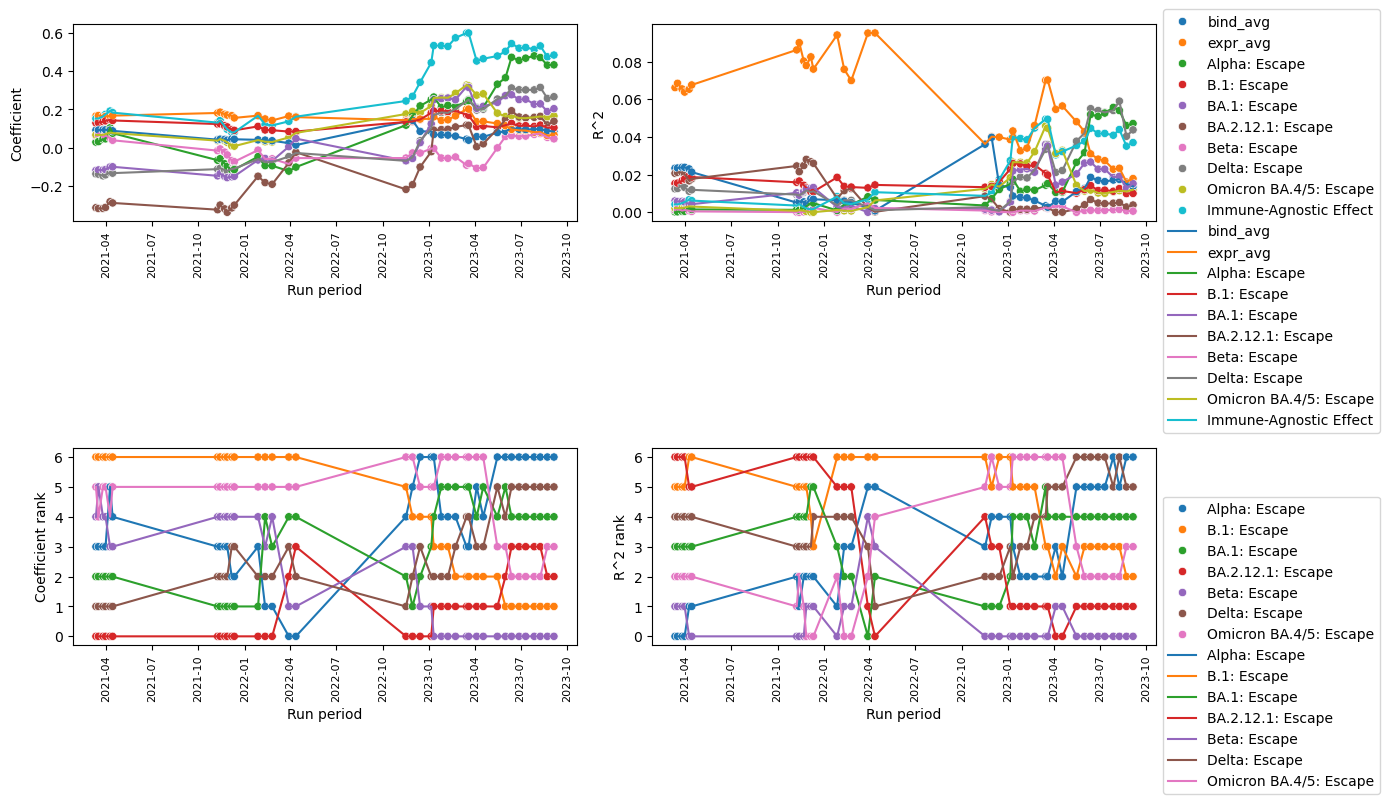

In [20]:
# NO STANDARD SCALER, NO PIP
regression_df = all_df
regression_df['Run period'] = regression_df['Run date']
regression_results = regression_df.groupby('Run period', group_keys=False
                                 ).apply(lambda x: pairwise_regression(x, standard_scaler=False, pip=False)
                                 ).sort_values(by='Run period'
                                 ).reset_index(drop=True)

leading_varns = regression_results[regression_results['Predictor'].apply(lambda x: x.endswith(': Escape'))]
leading_varns['R^2 rank'] = (
             leading_varns
             .groupby('Run period')['R^2']
             .transform(lambda r2s: rankgrp(r2s.values))
             )
leading_varns['Coefficient rank'] = (
             leading_varns
             .groupby('Run period')['Coefficient']
             .transform(lambda r2s: rankgrp(r2s.values))
             )

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fs = 8

for ax, y in zip(axes[0, :], ['Coefficient', 'R^2']):
    sns.scatterplot(x='Run period',
                    y=y,
                    hue='Predictor',
                    data=regression_results,
                    ax=ax)
    sns.lineplot(   x='Run period',
                    y=y,
                    hue='Predictor',
                    data=regression_results,
                    ax=ax)

    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

axes[0, 0].legend().set_visible(False);
axes[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0));


for ax, y in zip(axes[1, :], ['Coefficient rank', 'R^2 rank']):
    sns.scatterplot(x='Run period',
                    y=y,
                    hue='Predictor',
                    data=leading_varns,
                    ax=ax)
    sns.lineplot(   x='Run period',
                    y=y,
                    hue='Predictor',
                    data=leading_varns,
                    ax=ax)

    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

axes[1, 0].legend().set_visible(False);
axes[1, 1].legend(loc='center left', bbox_to_anchor=(1, 0));

fig.tight_layout();

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/820008075.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leading_varns['R^2 rank'] = (
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/820008075.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leading_varns['Coefficient rank'] = (
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/820008075.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or u

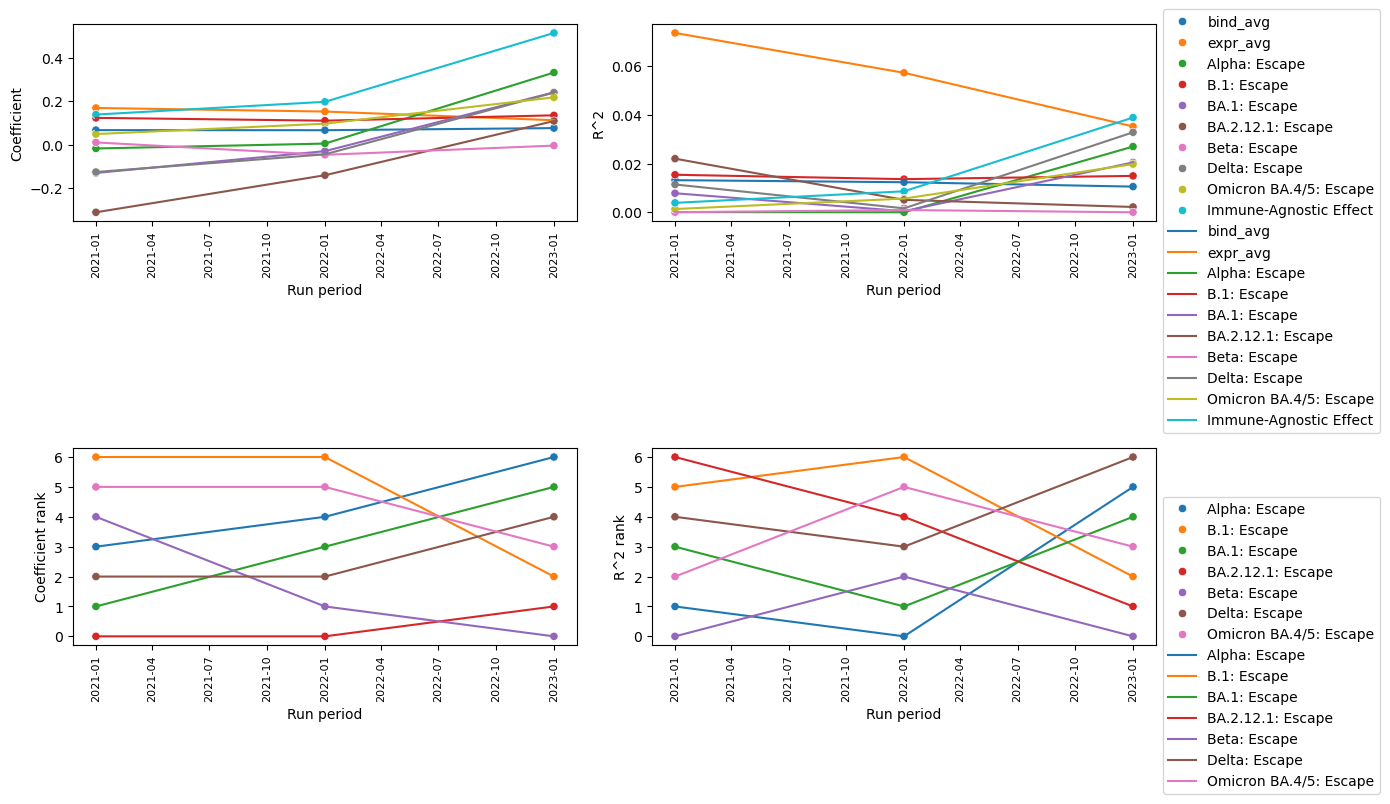

In [21]:
regression_df = all_df
regression_df['Run period'] = regression_df['Run year']
regression_results = regression_df.groupby('Run period', group_keys=False
                                 ).apply(lambda x: pairwise_regression(x, standard_scaler=False, pip=False)
                                 ).sort_values(by='Run period'
                                 ).reset_index(drop=True)

leading_varns = regression_results[regression_results['Predictor'].apply(lambda x: x.endswith(': Escape'))]
leading_varns['R^2 rank'] = (
             leading_varns
             .groupby('Run period')['R^2']
             .transform(lambda r2s: rankgrp(r2s.values))
             )
leading_varns['Coefficient rank'] = (
             leading_varns
             .groupby('Run period')['Coefficient']
             .transform(lambda r2s: rankgrp(r2s.values))
             )

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fs = 8

for ax, y in zip(axes[0, :], ['Coefficient', 'R^2']):
    sns.scatterplot(x='Run period',
                    y=y,
                    hue='Predictor',
                    data=regression_results,
                    ax=ax)
    sns.lineplot(   x='Run period',
                    y=y,
                    hue='Predictor',
                    data=regression_results,
                    ax=ax)

    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

axes[0, 0].legend().set_visible(False);
axes[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0));


for ax, y in zip(axes[1, :], ['Coefficient rank', 'R^2 rank']):
    sns.scatterplot(x='Run period',
                    y=y,
                    hue='Predictor',
                    data=leading_varns,
                    ax=ax)
    sns.lineplot(   x='Run period',
                    y=y,
                    hue='Predictor',
                    data=leading_varns,
                    ax=ax)

    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

axes[1, 0].legend().set_visible(False);
axes[1, 1].legend(loc='center left', bbox_to_anchor=(1, 0));

fig.tight_layout();

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/594810400.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)


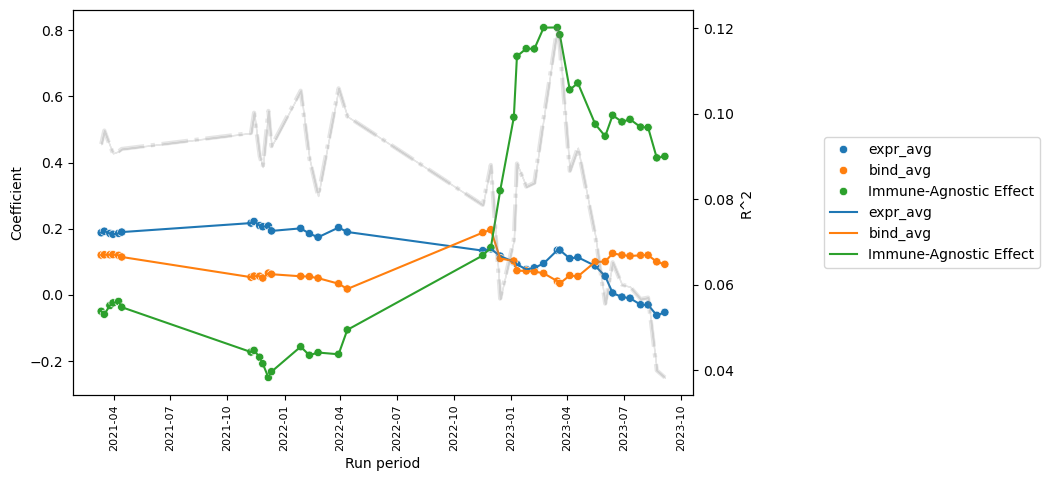

In [22]:
def inf_neut_regress(grp):
    predictors = ['expr_avg', 'bind_avg', 'Immune-Agnostic Effect']
    
    results = []
    sub_df = grp[['Beta'] + predictors].dropna()
    X = sub_df[predictors].dropna()
    y = sub_df['Beta'].values
    model = LinearRegression().fit(X, y)
    coefs = model.coef_
    r2 = model.score(X, y)
    
    result_dict = {p:c for p, c in zip(predictors, coefs)}
    result_dict['R^2'] = r2
    results.append(result_dict)
    
    out_df = pd.DataFrame(results)
    out_df['Run period'] = grp['Run period'].iloc[0]
    return out_df

regression_df['Run period'] = regression_df['Run date']
regression_results = regression_df.groupby('Run period', group_keys=False
                                 ).apply(inf_neut_regress
                                 ).sort_values(by='Run period'
                                 ).reset_index(drop=True)
regression_results = regression_results.melt(id_vars=['Run period', 'R^2'],
                                             value_vars=['expr_avg', 'bind_avg', 'Immune-Agnostic Effect'],
                                             var_name='Predictor',
                                             value_name='Coefficient')


fig, ax = plt.subplots(figsize=(8, 5))
fs = 8

sns.scatterplot(x='Run period',
                y='Coefficient',
                hue='Predictor',
                data=regression_results,
                ax=ax)
sns.lineplot(   x='Run period',
                y='Coefficient',
                hue='Predictor',
                data=regression_results,
                ax=ax)
ax2 = ax.twinx()
sns.lineplot(x='Run period',
             y='R^2',
             data=regression_results,
             linestyle='-.',
             color='tab:gray',
             alpha=0.2,
             linewidth=3,
             ax=ax2);

xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

ax.legend(loc='center left', bbox_to_anchor=(1.2, 0.5));

## BVAS Top Muts

In [23]:
escape_date = '2025-06-26'
sb = .6

escape_results = torch.load(f'model_covdb/results.{escape_date}.sb{sb}.pt')
escape_traces = escape_results['traces']
escape_data = escape_results['data']

pool_specific_effects = pd.DataFrame(columns=escape_data['features'], index=escape_data['pools_map'], data=escape_traces['β_ω'].mean(dim=0)
                                    ).reset_index(
                                    ).melt(id_vars='index', value_vars=None, var_name='Mutation', value_name='Effect'
                                    ).rename(columns={'index':'Pool'})
# Subset ranges to where we have ample data on each mutation
min_n = 1  # mutation must have been seen at least once
subset = []
for _, row in pool_specific_effects.iterrows():
    pool_idx = (escape_data['pools_map']==row['Pool']).nonzero()[0][0]
    feat_idx = (np.array(escape_data['features'])==row['Mutation']).nonzero()[0][0]
    num_obs = escape_data['X'][escape_data['pools']==pool_idx, feat_idx].sum().item()
    row = dict(row)
    row['N'] = int(num_obs)
    if num_obs >= min_n:
        subset.append(row)
subset = pd.DataFrame(subset)

pool_specific_effects = pd.merge(pool_specific_effects, subset[['Mutation', 'Pool']], on=['Mutation', 'Pool'], how='inner')

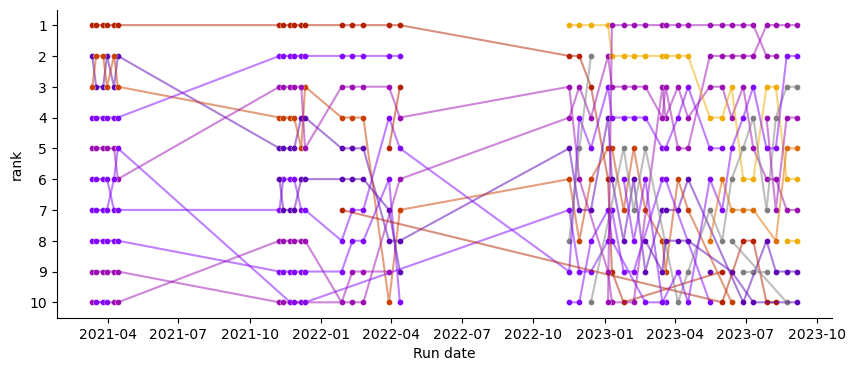

In [24]:
top_muts = bvas_spike.groupby('Run date'
                    ).apply(lambda x: x.sort_values(by='Beta', ascending=False).reset_index(drop=True).head(10)
                    ).drop(columns='Run date'
                    ).reset_index(
                    ).rename(columns={'level_1':'rank'})

fig, ax = plt.subplots(figsize=(10, 4))
for mut in top_muts['Mutation'].unique():
    try:
        best_pool = pool_specific_effects[pool_specific_effects['Mutation']==mut].sort_values(by='Effect', ascending=False)['Pool'].iloc[0]
    except IndexError:
        best_pool = None
    df_mut = top_muts[top_muts['Mutation']==mut]
    sns.lineplot(x='Run date',
                 y='rank',
                 color=pool_colors[best_pool] if best_pool else 'tab:gray',
                 data=df_mut,
                 alpha=0.5,
                 ax=ax)
    sns.scatterplot(
                 x='Run date',
                 y='rank',
                 color=pool_colors[best_pool] if best_pool else 'tab:gray',
                 data=df_mut,
                 s=20,
                 ax=ax)
    
ax.spines[['top', 'right']].set_visible(False);
ax.set_ylim([9.5, -0.5]);
ax.set_yticks(range(10));
ax.set_yticklabels([i+1 for i in range(10)]);

In [25]:
# I think there's more data somewhere that has more dates covered. Maybe it's in the retro github? Maybe if I use PyR0 rather than BVAS...?

## PyR0

In [26]:
pyro = pd.read_csv('data/PyR0/PyR0_Ranked_Mutations.tsv', sep='\t')
pyro['Run date'] = pd.to_datetime(pyro['Run date'])
pyro = pyro[pyro['Run date']<'2023-09-20']
pyro['Run year'] = pyro['Run date'].dt.to_period('Y').dt.to_timestamp().astype(str).apply(lambda x: x.split('-')[0])
pyro_spike = pyro[pyro['mutation'].apply(lambda x: x.startswith('S:'))]
pyro_spike['mutation'] = pyro_spike['mutation'].apply(lambda x: x.strip('S:'))
pyro_spike = pyro_spike.rename(columns={'mutation':'Mutation'})

all_df = pd.merge(
         pd.merge(
                  pd.merge(pyro_spike, dms, on='Mutation', how='outer'),
                  pool_specific_effects_piv, on='Mutation', how='outer'),
               pool_agnostic_effects, on='Mutation', how='outer') 
all_df

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/648568867.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pyro_spike['mutation'] = pyro_spike['mutation'].apply(lambda x: x.strip('S:'))


rank Mutation  mean/stddev  log10(P(ΔR > 1))   Δ log R  \
0       1.0    R346K      4611.43         4617700.0  0.094890   
1       1.0    R346K      5317.05         6138970.0  0.098483   
2       1.0    R346K      4287.46         3991670.0  0.100718   
3       1.0    R346K      5282.73         6059990.0  0.104844   
4       1.0    R346K      5171.73         5807990.0  0.105375   
...     ...      ...          ...               ...       ...   
25797   NaN      Δ74          NaN               NaN       NaN   
25798   NaN      Δ75          NaN               NaN       NaN   
25799   NaN      Δ76          NaN               NaN       NaN   
25800   NaN      Δ77          NaN               NaN       NaN   
25801   NaN      Δ78          NaN               NaN       NaN   

       Δ log R 95% ci lower  Δ log R 95% ci upper  R / R_A  \
0                  0.094850              0.094930  1.09954   
1                  0.098447              0.098520  1.10350   
2                  0.100672              0.100764  1.10596   
3                  0.104805              0.104883  1.11054   
4                  0.105335              0.105415  1.11113   
...                     ...                   ...      ...   
25797                   NaN                   NaN      NaN   
25798                   NaN                   NaN      NaN   
25799                   NaN                   NaN      NaN   
25800                   NaN                   NaN      NaN   
25801                   NaN                   NaN      NaN   

       R / R_A 95% ci lower  R / R_A 95% ci upper  ... expr_lib2 expr_avg  \
0                   1.09949               1.09958  ...      0.12     0.12   
1                   1.10346               1.10354  ...      0.12     0.12   
2                   1.10591               1.10602  ...      0.12     0.12   
3                   1.11049               1.11058  ...      0.12     0.12   
4                   1.11108               1.11117  ...      0.12     0.12   
...                     ...                   ...  ...       ...      ...   
25797                   NaN                   NaN  ...       NaN      NaN   
25798                   NaN                   NaN  ...       NaN      NaN   
25799                   NaN                   NaN  ...       NaN      NaN   
25800                   NaN                   NaN  ...       NaN      NaN   
25801                   NaN                   NaN  ...       NaN      NaN   

      Alpha: Escape  B.1: Escape  BA.1: Escape BA.2.12.1: Escape Beta: Escape  \
0         -0.019536     0.021660      0.147028          0.000441    -0.167932   
1         -0.019536     0.021660      0.147028          0.000441    -0.167932   
2         -0.019536     0.021660      0.147028          0.000441    -0.167932   
3         -0.019536     0.021660      0.147028          0.000441    -0.167932   
4         -0.019536     0.021660      0.147028          0.000441    -0.167932   
...             ...          ...           ...               ...          ...   
25797           NaN     0.049136           NaN               NaN          NaN   
25798           NaN     0.064921           NaN               NaN          NaN   
25799           NaN     0.002668           NaN               NaN          NaN   
25800           NaN    -0.010703           NaN               NaN          NaN   
25801           NaN     0.032030           NaN               NaN          NaN   

      Delta: Escape Omicron BA.4/5: Escape  Immune-Agnostic Effect  
0         -0.060611               0.085414                0.005315  
1         -0.060611               0.085414                0.005315  
2         -0.060611               0.085414                0.005315  
3         -0.060611               0.085414                0.005315  
4         -0.060611               0.085414                0.005315  
...             ...                    ...                     ...  
25797           NaN               0.078671                0.041396  
25798           NaN            

In [27]:
def pairwise_regression(group, standard_scaler=True, regressand='Δ log R'):
    predictors = [
        'bind_avg', 'expr_avg',
        'Alpha: Escape', 'B.1: Escape', 'BA.1: Escape',
        'BA.2.12.1: Escape', 'Beta: Escape', 'Delta: Escape',
        'Omicron BA.4/5: Escape', 'Immune-Agnostic Effect'
    ]
    
    results = []
    for predictor in predictors:
        sub_df = group[[regressand, predictor]].dropna()
        if len(sub_df) < 3:
            continue  # Not enough data to fit a model
        
        X = sub_df[[predictor]].values
        if standard_scaler:
            X = StandardScaler().fit_transform(X)
        y = sub_df[regressand].values
        model = LinearRegression().fit(X, y)
        coef = model.coef_[0]
        r2 = model.score(X, y)
        
        results.append({
            'Predictor': predictor,
            'Coefficient': coef,
            'R^2': r2
        })
    
    out_df = pd.DataFrame(results)
    out_df['Run period'] = group['Run period'].iloc[0]
    return out_df

def softmax(x):
    e_x = np.exp(x)
    return e_x / np.nansum(e_x)


def rankgrp(x):
    x = np.array(x)
    order = x.argsort()
    rank = order.argsort()
    return rank

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/2593774137.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leading_varns['R^2 rank'] = (
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/2593774137.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leading_varns['Coefficient rank'] = (
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/2593774137.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() 

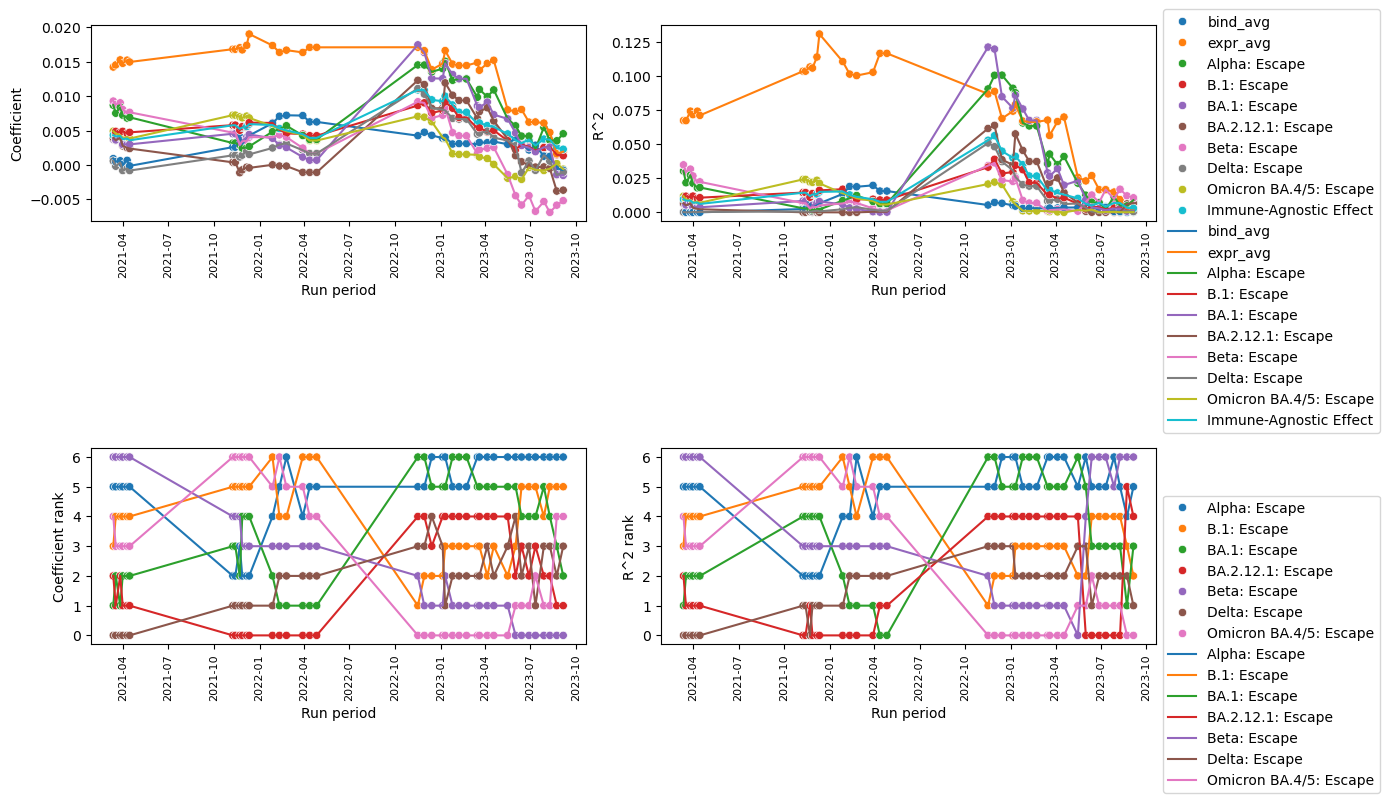

In [28]:
# STANDARD SCALER
regression_df = all_df
regression_df['Run period'] = regression_df['Run date']
regression_results = regression_df.groupby('Run period', group_keys=False
                                 ).apply(lambda x: pairwise_regression(x, standard_scaler=True, regressand='Δ log R')
                                 ).sort_values(by='Run period'
                                 ).reset_index(drop=True)

leading_varns = regression_results[regression_results['Predictor'].apply(lambda x: x.endswith(': Escape'))]
leading_varns['R^2 rank'] = (
             leading_varns
             .groupby('Run period')['R^2']
             .transform(lambda r2s: rankgrp(r2s.values))
             )
leading_varns['Coefficient rank'] = (
             leading_varns
             .groupby('Run period')['Coefficient']
             .transform(lambda r2s: rankgrp(r2s.values))
             )

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fs = 8

for ax, y in zip(axes[0, :], ['Coefficient', 'R^2']):
    sns.scatterplot(x='Run period',
                    y=y,
                    hue='Predictor',
                    data=regression_results,
                    ax=ax)
    sns.lineplot(   x='Run period',
                    y=y,
                    hue='Predictor',
                    data=regression_results,
                    ax=ax)

    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

axes[0, 0].legend().set_visible(False);
axes[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0));


for ax, y in zip(axes[1, :], ['Coefficient rank', 'R^2 rank']):
    sns.scatterplot(x='Run period',
                    y=y,
                    hue='Predictor',
                    data=leading_varns,
                    ax=ax)
    sns.lineplot(   x='Run period',
                    y=y,
                    hue='Predictor',
                    data=leading_varns,
                    ax=ax)

    xticklabels = ax.get_xticklabels()
    ax.set_xticklabels(xticklabels, rotation=90, fontsize=fs)

axes[1, 0].legend().set_visible(False);
axes[1, 1].legend(loc='center left', bbox_to_anchor=(1, 0));

fig.tight_layout();

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/1465841242.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=0, fontsize=fs)


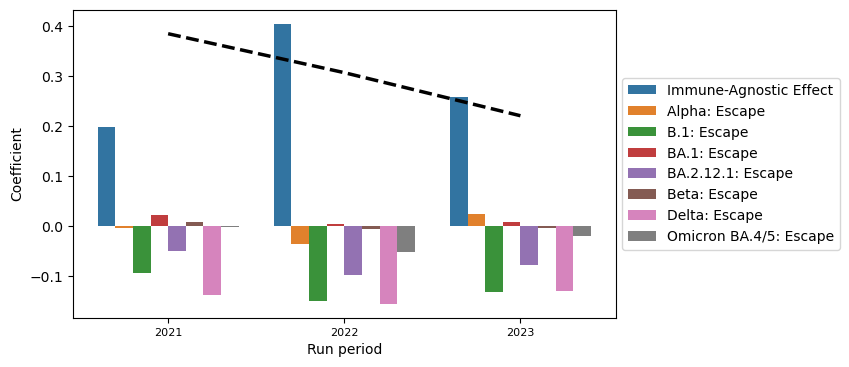

In [29]:
# Let's try regressing using only the escape coefficients
def multiple_regression(group, standard_scaler=True, regressand='Δ log R'):
    immune_escape_cols = ['Immune-Agnostic Effect',
        'Alpha: Escape', 'B.1: Escape', 'BA.1: Escape',
        'BA.2.12.1: Escape', 'Beta: Escape',
        'Delta: Escape', 'Omicron BA.4/5: Escape'
    ]

    X = group.dropna()[immune_escape_cols].values
    y = group.dropna()[regressand].values

    # Standardize predictors
    if standard_scaler:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    # Fit regression
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = model.score(X, y)

    # Prepare output
    result = {
        'Run period': group['Run period'].iloc[0],
        'R^2': r2,
        'Meta-param': y_pred
    }
    result.update(dict(zip(immune_escape_cols, model.coef_)))
    return pd.DataFrame([result])

    
regression_df = all_df
regression_df['Run period'] = regression_df['Run year']
regression_results = regression_df.groupby('Run period', group_keys=False
                                 ).apply(lambda x: multiple_regression(x, standard_scaler=True, regressand='Δ log R')
                                 ).sort_values(by='Run period'
                                 ).reset_index(drop=True)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
fs = 8

sns.barplot(x='Run period',
            y='Coefficient',
            hue='Predictor',
            data=regression_results.melt(id_vars=['Run period', 'R^2', 'Meta-param'], var_name='Predictor', value_name='Coefficient'),
            ax=ax)
sns.lineplot(x='Run period',
             y='R^2',
             color='k',
             linewidth=2.5,
             linestyle='--',
             data=regression_results,
             ax=ax)

xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, rotation=0, fontsize=fs)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

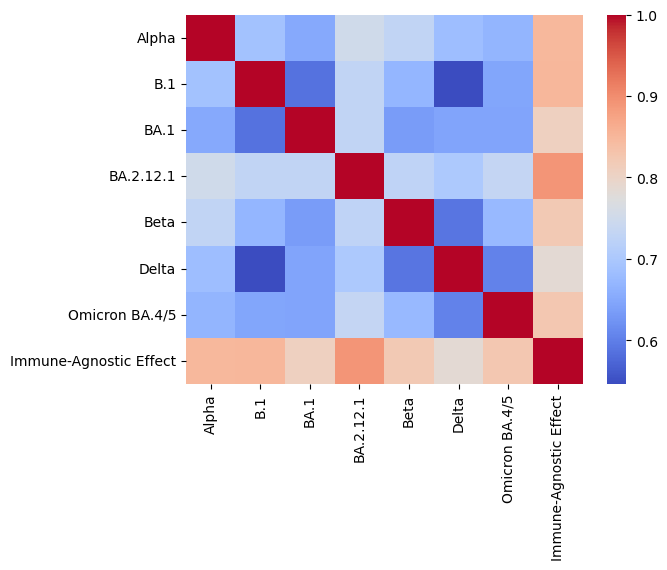

In [30]:
corr_df = pd.DataFrame(index=escape_data['features'], 
                       columns=escape_data['pools_map'],
                       data=escape_traces['β_ω'].mean(dim=0).transpose(1,0))
corr_df['Immune-Agnostic Effect'] = escape_traces['β'].mean(dim=0)
corr_df = corr_df.corr(method='pearson')
fig, ax = plt.subplots()
sns.heatmap(corr_df,
            cmap=sns.color_palette('coolwarm', as_cmap=True),
            ax=ax);

In [31]:
from scipy.stats import pearsonr

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = pearsonr(tmp[r], tmp[c])[1]
    return pvalues

pval_df = calculate_pvalues(pd.DataFrame(index=escape_data['features'], 
                                         columns=escape_data['pools_map'],
                                         data=escape_traces['β_ω'].mean(dim=0).transpose(1,0))) 
pval_df

Alpha  B.1 BA.1 BA.2.12.1 Beta Delta Omicron BA.4/5
Alpha            0.0  0.0  0.0       0.0  0.0   0.0            0.0
B.1              0.0  0.0  0.0       0.0  0.0   0.0            0.0
BA.1             0.0  0.0  0.0       0.0  0.0   0.0            0.0
BA.2.12.1        0.0  0.0  0.0       0.0  0.0   0.0            0.0
Beta             0.0  0.0  0.0       0.0  0.0   0.0            0.0
Delta            0.0  0.0  0.0       0.0  0.0   0.0            0.0
Omicron BA.4/5   0.0  0.0  0.0       0.0  0.0   0.0            0.0

In [32]:
print(corr_df.drop(columns='Immune-Agnostic Effect', index='Immune-Agnostic Effect').replace(1.0, None).mean().mean())
print(corr_df.replace(1.0, None).mean().mean())

0.668023791237448
0.7091742349668864


In [33]:
corr_df.drop(columns='Immune-Agnostic Effect', index='Immune-Agnostic Effect').replace(1.0, None).max()

Alpha             0.751735
B.1               0.729354
BA.1               0.73005
BA.2.12.1         0.751735
Beta              0.730355
Delta             0.700962
Omicron BA.4/5    0.732527
dtype: object

In [34]:
corr_df.drop(columns='Immune-Agnostic Effect', index='Immune-Agnostic Effect').replace(1.0, None).min()

Alpha             0.651038
B.1               0.546182
BA.1              0.586923
BA.2.12.1         0.700962
Beta              0.589112
Delta             0.546182
Omicron BA.4/5    0.604047
dtype: object

In [35]:
corr_df

Alpha       B.1      BA.1  BA.2.12.1      Beta  \
Alpha                   1.000000  0.688191  0.651038   0.751735  0.730355   
B.1                     0.688191  1.000000  0.586923   0.729354  0.668778   
BA.1                    0.651038  0.586923  1.000000   0.730050  0.633685   
BA.2.12.1               0.751735  0.729354  0.730050   1.000000  0.725793   
Beta                    0.730355  0.668778  0.633685   0.725793  1.000000   
Delta                   0.681404  0.546182  0.644465   0.700962  0.589112   
Omicron BA.4/5          0.667524  0.646671  0.645014   0.732527  0.674688   
Immune-Agnostic Effect  0.847811  0.850986  0.808400   0.890948  0.821424   

                           Delta  Omicron BA.4/5  Immune-Agnostic Effect  
Alpha                   0.681404        0.667524                0.847811  
B.1                     0.546182        0.646671                0.850986  
BA.1                    0.644465        0.645014                0.808400  
BA.2.12.1               0.700962        0.732527                0.890948  
Beta                    0.589112        0.674688                0.821424  
Delta                   1.000000        0.604047                0.783918  
Omicron BA.4/5          0.604047        1.000000                0.824892  
Immune-Agnostic Effect  0.783918        0.824892                1.000000

In [36]:
corr_df[corr_df>0.54]

Alpha       B.1      BA.1  BA.2.12.1      Beta  \
Alpha                   1.000000  0.688191  0.651038   0.751735  0.730355   
B.1                     0.688191  1.000000  0.586923   0.729354  0.668778   
BA.1                    0.651038  0.586923  1.000000   0.730050  0.633685   
BA.2.12.1               0.751735  0.729354  0.730050   1.000000  0.725793   
Beta                    0.730355  0.668778  0.633685   0.725793  1.000000   
Delta                   0.681404  0.546182  0.644465   0.700962  0.589112   
Omicron BA.4/5          0.667524  0.646671  0.645014   0.732527  0.674688   
Immune-Agnostic Effect  0.847811  0.850986  0.808400   0.890948  0.821424   

                           Delta  Omicron BA.4/5  Immune-Agnostic Effect  
Alpha                   0.681404        0.667524                0.847811  
B.1                     0.546182        0.646671                0.850986  
BA.1                    0.644465        0.645014                0.808400  
BA.2.12.1               0.700962        0.732527                0.890948  
Beta                    0.589112        0.674688                0.821424  
Delta                   1.000000        0.604047                0.783918  
Omicron BA.4/5          0.604047        1.000000                0.824892  
Immune-Agnostic Effect  0.783918        0.824892                1.000000

In [37]:
corr_df.replace(1.0, None).max()

Alpha                     0.847811
B.1                       0.850986
BA.1                        0.8084
BA.2.12.1                 0.890948
Beta                      0.821424
Delta                     0.783918
Omicron BA.4/5            0.824892
Immune-Agnostic Effect    0.890948
dtype: object

In [38]:
y = all_df.dropna()['Δ log R'].values
y.reshape(-1, 1)[:, 0].shape

(624,)

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/3655589949.py:58: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=0, fontsize=fs)


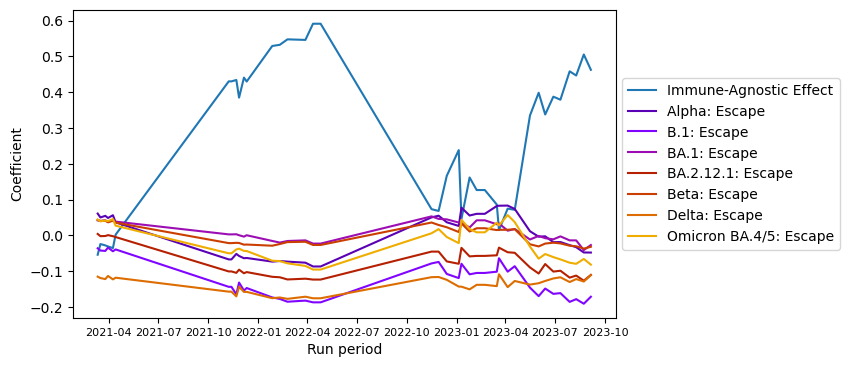

In [39]:
# Let's try regressing using only the escape coefficients
def multiple_regression(group, standard_scaler=True, regressand='Δ log R'):
    immune_escape_cols = ['Immune-Agnostic Effect',
        'Alpha: Escape', 'B.1: Escape', 'BA.1: Escape',
        'BA.2.12.1: Escape', 'Beta: Escape',
        'Delta: Escape', 'Omicron BA.4/5: Escape'
    ]

    X = group.dropna()[immune_escape_cols].values
    y = group.dropna()[regressand].values

    # Standardize predictors
    if standard_scaler:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    # Fit regression
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = model.score(X, y)

    # Prepare output
    result = {
        'Run period': group['Run period'].iloc[0],
        'R^2': r2,
        'Meta-param': y_pred
    }
    result.update(dict(zip(immune_escape_cols, model.coef_)))
    return pd.DataFrame([result])

    
regression_df = all_df
regression_df['Run period'] = regression_df['Run date']
regression_results = regression_df.groupby('Run period', group_keys=False
                                 ).apply(lambda x: multiple_regression(x, standard_scaler=True, regressand='Δ log R')
                                 ).sort_values(by='Run period'
                                 ).reset_index(drop=True)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
fs = 8

sns.lineplot(x='Run period',
            y='Coefficient',
            hue='Predictor',
            palette={**{k+': Escape':v for k,v in pool_colors.items()}, 'Immune-Agnostic Effect':'tab:blue'},
            data=regression_results.melt(id_vars=['Run period', 'R^2', 'Meta-param'], var_name='Predictor', value_name='Coefficient'),
            ax=ax)
# sns.lineplot(x='Run period',
#              y='R^2',
#              color='k',
#              linewidth=2.5,
#              linestyle='--',
#              data=regression_results,
#              ax=ax)

xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, rotation=0, fontsize=fs)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

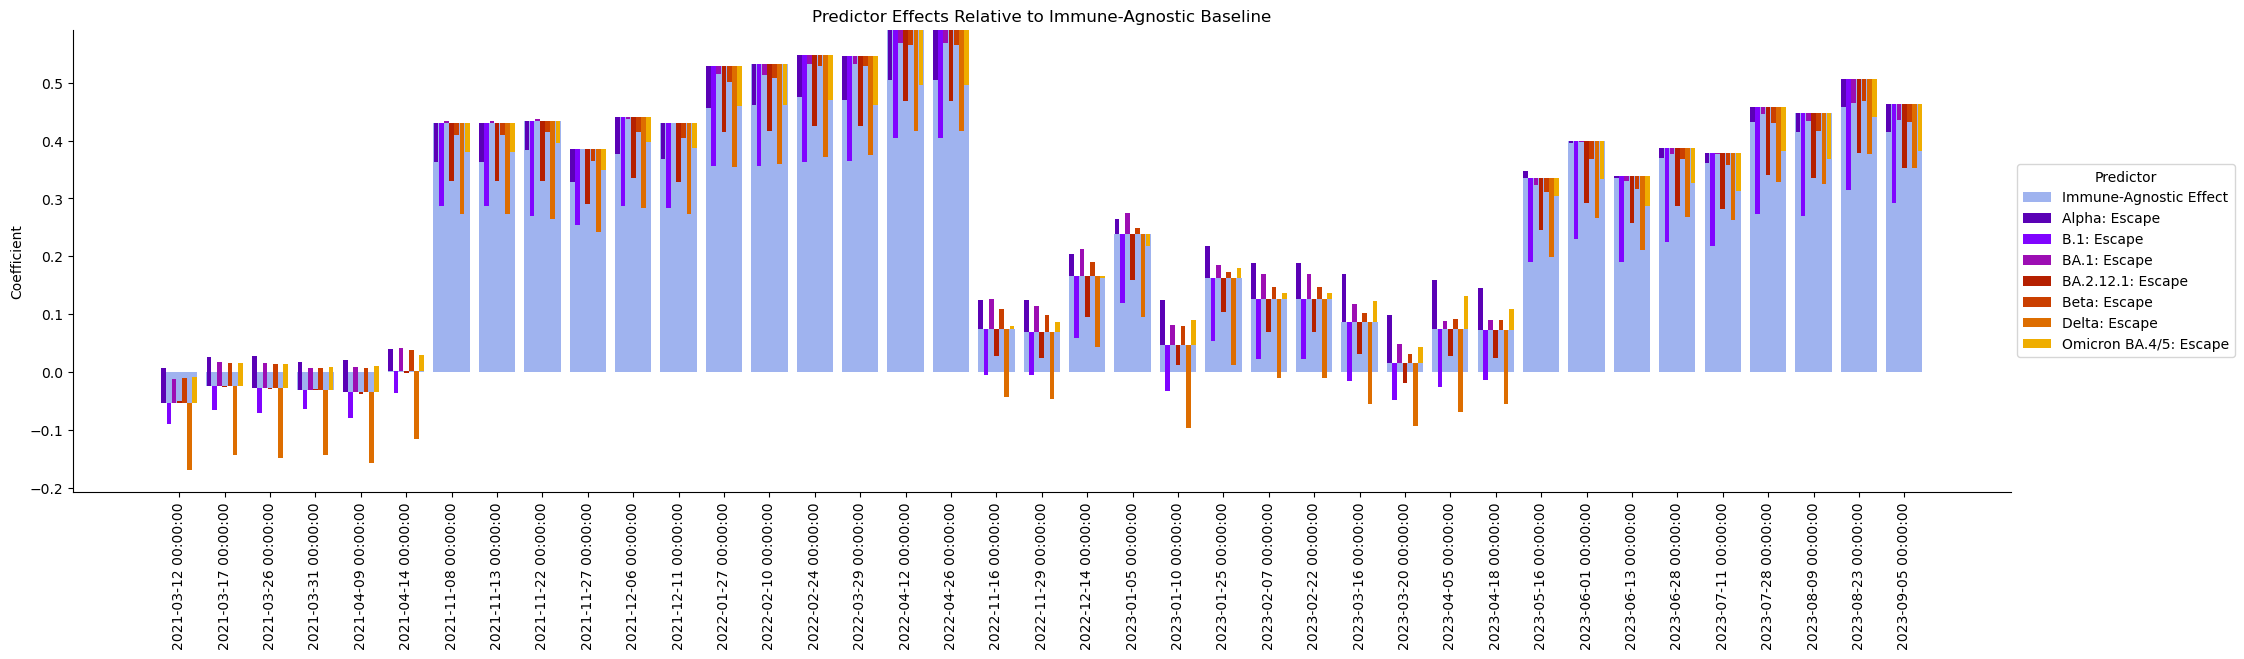

In [40]:
regression_df = all_df
regression_df['Run period'] = regression_df['Run date']
regression_results = regression_df.groupby('Run period', group_keys=False
                                 ).apply(lambda x: multiple_regression(x, standard_scaler=True, regressand='Δ log R')
                                 ).sort_values(by='Run period'
                                 ).reset_index(drop=True)

# Prepare data
melted = regression_results.melt(
    id_vars=['Run period', 'R^2', 'Meta-param'],
    var_name='Predictor',
    value_name='Coefficient'
)

# Get coefficients
agnostic = melted[melted['Predictor'] == 'Immune-Agnostic Effect'].copy()
others = melted[melted['Predictor'] != 'Immune-Agnostic Effect'].copy()
others = others.merge(
    agnostic[['Run period', 'Coefficient']],
    on='Run period',
    suffixes=('', '_Agnostic')
)
# Calculate bar heights and bottoms
others['Bottom'] = others['Coefficient_Agnostic']
others['Height'] = others['Coefficient']

# Calculate x-values
periods = melted['Run period'].unique()
run_index_map = {p: i for i, p in enumerate(periods)}
agnostic['x'] = agnostic['Run period'].map(run_index_map)
others['x'] = others['Run period'].map(run_index_map)

# Plot
fig, ax = plt.subplots(figsize=(25, 6))
n = others['Predictor'].nunique()
big_bar_width = 0.8
mini_bar_width = big_bar_width / n
palette = sns.color_palette('Reds', n)

ax.bar(agnostic['x'], agnostic['Coefficient'], width=big_bar_width, color='royalblue', alpha=0.5, label='Immune-Agnostic Effect')

for i, pred in enumerate(others['Predictor'].unique()):
    d = others[others['Predictor'] == pred]
    x_offset = d['x'] + (i - (n - 1) / 2) * mini_bar_width
    ax.bar(x_offset, d['Height'], bottom=d['Bottom'], width=mini_bar_width * 0.9, color=pool_colors[pred.split(': ')[0]], label=pred)

ax.set_xticks(range(len(periods)))
ax.set_xticklabels(periods, rotation=90)
ax.set_ylabel('Coefficient')
ax.set_title('Predictor Effects Relative to Immune-Agnostic Baseline')
ax.legend(title='Predictor', loc='center left', bbox_to_anchor=(1, 0.5));
ax.spines[['top', 'right']].set_visible(False)

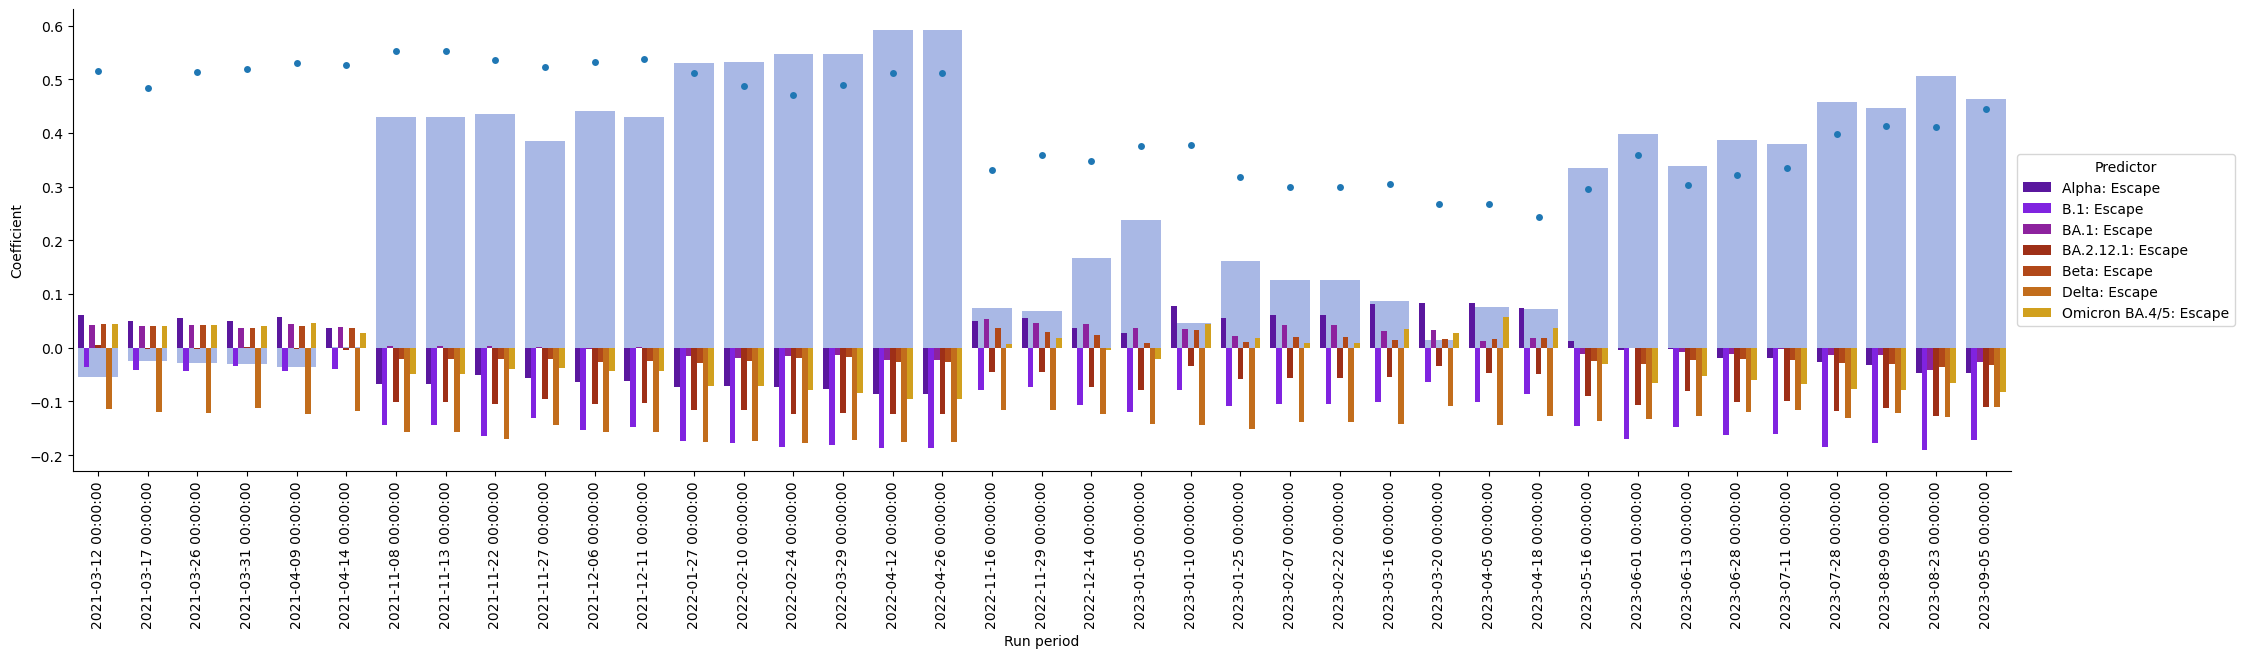

In [41]:
fig, ax = plt.subplots(figsize=(25, 6))
sns.barplot(x='Run period',
            y='Immune-Agnostic Effect',
            data=regression_results,
            color='royalblue', 
            alpha=0.5,
            ax=ax);
sns.barplot(x='Run period',
            y='Coefficient',
            data=regression_results[['Run period',
               'Alpha: Escape', 'B.1: Escape', 'BA.1: Escape', 'BA.2.12.1: Escape',
               'Beta: Escape', 'Delta: Escape', 'Omicron BA.4/5: Escape']].melt(id_vars='Run period', var_name='Pool', value_name='Coefficient'),
            hue='Pool',
            palette={f'{k}: Escape':v for k, v in pool_colors.items()},
            ax=ax);
sns.stripplot(x='Run period',
             y='R^2',
             data=regression_results,
             ax=ax);

ax.set_xticks(range(len(periods)))
ax.set_xticklabels(periods, rotation=90)
ax.set_ylabel('Coefficient')
ax.legend(title='Predictor', loc='center left', bbox_to_anchor=(1, 0.5));
ax.spines[['top', 'right']].set_visible(False)

In [42]:
print(regression_results[regression_results['Run period']<'2022-07-01']['R^2'].mean())
print(regression_results[regression_results['Run period']>'2022-07-01']['R^2'].mean())

0.516804063468718
0.33663800190531507


In [43]:
from scipy.stats import ttest_ind
ttest_ind(regression_results[regression_results['Run period']<'2022-07-01']['R^2'].values,
          regression_results[regression_results['Run period']>'2022-07-01']['R^2'].values)

TtestResult(statistic=13.34478222312249, pvalue=1.0283074165138625e-15, df=37.0)

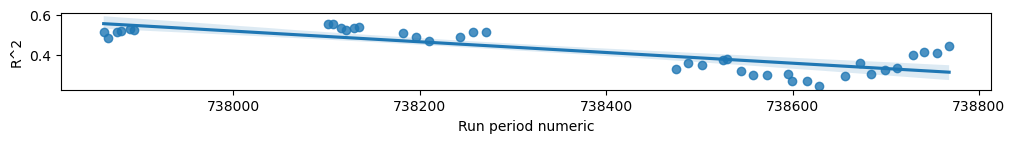

In [44]:
fig, ax = plt.subplots(figsize=(12, 1))
regression_results['Run period numeric'] = regression_results['Run period'].map(lambda x: x.toordinal())
sns.regplot(x='Run period numeric',
            y='R^2',
            data=regression_results,
            ax=ax);

In [45]:
print(regression_results['Run period'].nunique())
print(regression_results['R^2'].mean())
print(regression_results['R^2'].max())
print(regression_results[regression_results['R^2']==regression_results['R^2'].max()]['Run period'])
print(regression_results['Immune-Agnostic Effect'].mean())

39
0.4197915687807318
0.5522872525854421
6   2021-11-08
7   2021-11-13
Name: Run period, dtype: datetime64[ns]
0.27415833


In [46]:
regression_results[[col for col in regression_results.columns if 'Escape' in col or 'Effect' in col]].mean()

Immune-Agnostic Effect    0.274158
Alpha: Escape             0.000903
B.1: Escape              -0.124380
BA.1: Escape              0.011165
BA.2.12.1: Escape        -0.074575
Beta: Escape             -0.000911
Delta: Escape            -0.138801
Omicron BA.4/5: Escape   -0.022001
dtype: float32

In [47]:
(regression_results[[col for col in regression_results.columns if 'Escape' in col or 'Effect' in col]]>0).all()

Immune-Agnostic Effect    False
Alpha: Escape             False
B.1: Escape               False
BA.1: Escape              False
BA.2.12.1: Escape         False
Beta: Escape              False
Delta: Escape             False
Omicron BA.4/5: Escape    False
dtype: bool

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/465973881.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=0, fontsize=fs)


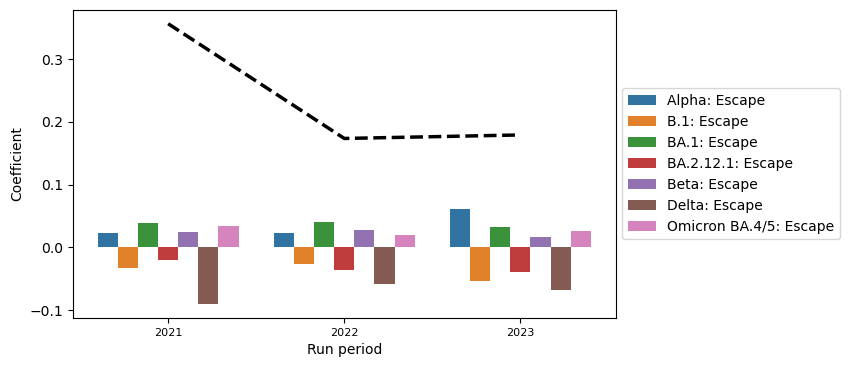

In [48]:
# Let's try regressing using only the escape coefficients
def multiple_regression(group, standard_scaler=True, regressand='Δ log R'):
    immune_escape_cols = [
        'Alpha: Escape', 'B.1: Escape', 'BA.1: Escape',
        'BA.2.12.1: Escape', 'Beta: Escape',
        'Delta: Escape', 'Omicron BA.4/5: Escape'
    ]

    X = group.dropna()[immune_escape_cols].values
    y = group.dropna()[regressand].values

    # Standardize predictors
    if standard_scaler:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    # Fit regression
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = model.score(X, y)

    # Prepare output
    result = {
        'Run period': group['Run period'].iloc[0],
        'R^2': r2,
        'Meta-param': y_pred
    }
    result.update(dict(zip(immune_escape_cols, model.coef_)))
    return pd.DataFrame([result])

    
regression_df = all_df
regression_df['Run period'] = regression_df['Run year']
regression_results = regression_df.groupby('Run period', group_keys=False
                                 ).apply(lambda x: multiple_regression(x, standard_scaler=True, regressand='Δ log R')
                                 ).sort_values(by='Run period'
                                 ).reset_index(drop=True)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
fs = 8

sns.barplot(x='Run period',
            y='Coefficient',
            hue='Predictor',
            data=regression_results.melt(id_vars=['Run period', 'R^2', 'Meta-param'], var_name='Predictor', value_name='Coefficient'),
            ax=ax)
sns.lineplot(x='Run period',
             y='R^2',
             color='k',
             linewidth=2.5,
             linestyle='--',
             data=regression_results,
             ax=ax)

xticklabels = ax.get_xticklabels()
ax.set_xticklabels(xticklabels, rotation=0, fontsize=fs)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [49]:
# regression_df = all_df
# regression_df['Run period'] = regression_df['Run year']
# regression_results = regression_df.groupby('Run period', group_keys=False
#                                  ).apply(lambda x: multiple_regression(x, standard_scaler=True, regressand='Δ log R')
#                                  ).sort_values(by='Run period'
#                                  ).reset_index(drop=True)

# # Prepare data
# melted = regression_results.melt(
#     id_vars=['Run period', 'R^2', 'Meta-param'],
#     var_name='Predictor',
#     value_name='Coefficient'
# )

# # Get coefficients
# agnostic = melted[melted['Predictor'] == 'Immune-Agnostic Effect'].copy()
# others = melted[melted['Predictor'] != 'Immune-Agnostic Effect'].copy()
# others = others.merge(
#     agnostic[['Run period', 'Coefficient']],
#     on='Run period',
#     suffixes=('', '_Agnostic')
# )
# # Calculate bar heights and bottoms
# others['Bottom'] = others['Coefficient_Agnostic']
# others['Height'] = others['Coefficient']

# # Calculate x-values
# periods = melted['Run period'].unique()
# run_index_map = {p: i for i, p in enumerate(periods)}
# agnostic['x'] = agnostic['Run period'].map(run_index_map)
# others['x'] = others['Run period'].map(run_index_map)

# # Plot
# fig, ax = plt.subplots(figsize=(10, 6))
# n = others['Predictor'].nunique()
# big_bar_width = 0.8
# mini_bar_width = big_bar_width / n
# palette = sns.color_palette('Reds', n)

# ax.bar(agnostic['x'], agnostic['Coefficient'], width=big_bar_width, color='royalblue', alpha=0.5, label='Immune-Agnostic Effect')

# for i, pred in enumerate(others['Predictor'].unique()):
#     d = others[others['Predictor'] == pred]
#     x_offset = d['x'] + (i - (n - 1) / 2) * mini_bar_width
#     ax.bar(x_offset, d['Height'], bottom=d['Bottom'], width=mini_bar_width * 0.9, color=pool_colors[pred.split(': ')[0]], label=pred)

# ax.set_xticks(range(len(periods)))
# ax.set_xticklabels(periods, rotation=0)
# ax.set_ylabel('Coefficient')
# ax.set_title('Predictor Effects Relative to Immune-Agnostic Baseline')
# ax.legend(title='Predictor', loc='center left', bbox_to_anchor=(1, 0.5));
# ax.spines[['top', 'right']].set_visible(False)

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/2752869197.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bvas_temp['Mutation'] = bvas_temp['Prot:Mut'].apply(lambda x: x.replace('S:', ''))
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/2752869197.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pyro_temp['Mutation'] = pyro_temp['mutation'].apply(lambda x: x.replace('S:', ''))


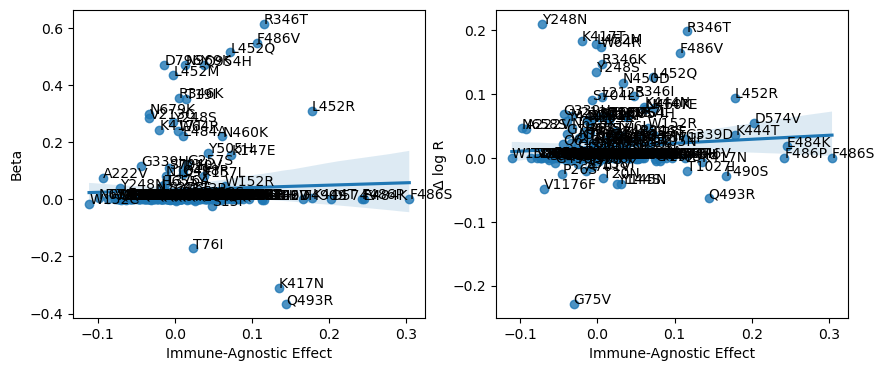

In [432]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
bvas_temp = bvas[bvas['Run date']=='2021-11-08']
bvas_temp['Mutation'] = bvas_temp['Prot:Mut'].apply(lambda x: x.replace('S:', ''))
df = pd.merge(bvas_temp, pool_agnostic_effects, on='Mutation')
sns.regplot(x='Immune-Agnostic Effect',
            y='Beta',
            data=df,
            ax=ax);

for _, row in df.iterrows():
    ax.text(row['Immune-Agnostic Effect'],
            row['Beta'],
            row['Mutation'])
    

ax = axes[1]
pyro_temp = pyro[pyro['Run date']=='2021-11-08']
pyro_temp['Mutation'] = pyro_temp['mutation'].apply(lambda x: x.replace('S:', ''))
df = pd.merge(pyro_temp, pool_agnostic_effects, on='Mutation')

sns.regplot(x='Immune-Agnostic Effect',
            y='Δ log R',
            data=df,
            ax=ax);

for _, row in df.iterrows():
    ax.text(row['Immune-Agnostic Effect'],
            row['Δ log R'],
            row['Mutation'])

These plots highlight Y248N as a mutation that may possibly be following from Muller's Ratchet. According to PyR0, this is a mutation that has high growth but low escape. BVAS should be less susceptible to "passenger mutations," and Y248N does not show up as high growth in BVAS data.

                            Beta  Immune-Agnostic Effect
Beta                    1.000000                0.140738
Immune-Agnostic Effect  0.140738                1.000000
                         Δ log R  Immune-Agnostic Effect
Δ log R                 1.000000                0.131156
Immune-Agnostic Effect  0.131156                1.000000


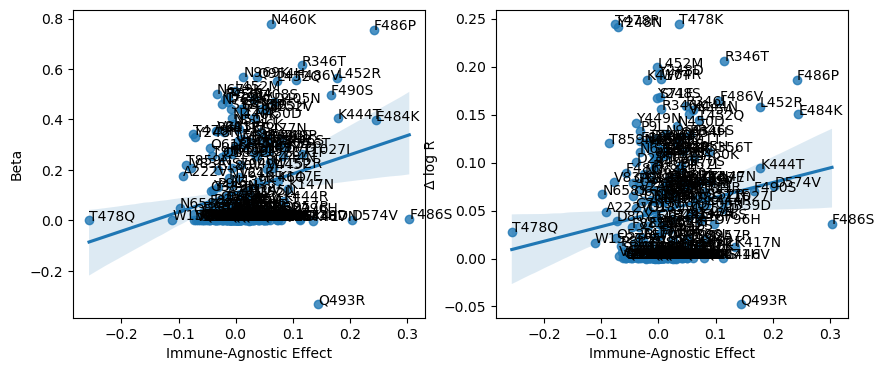

In [433]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
bvas_temp = bvas[['Prot:Mut', 'Beta']].groupby(['Prot:Mut']).agg('max').reset_index()
bvas_temp['Mutation'] = bvas_temp['Prot:Mut'].apply(lambda x: x.replace('S:', ''))
df = pd.merge(bvas_temp, pool_agnostic_effects, on='Mutation')
sns.regplot(x='Immune-Agnostic Effect',
            y='Beta',
            data=df,
            ax=ax);

for _, row in df.iterrows():
    ax.text(row['Immune-Agnostic Effect'],
            row['Beta'],
            row['Mutation'])
    
print(df[['Beta', 'Immune-Agnostic Effect']].corr(method='spearman'))
    

ax = axes[1]
pyro_temp = pyro[['mutation', 'Δ log R']].groupby('mutation').agg('max').reset_index()
pyro_temp['Mutation'] = pyro_temp['mutation'].apply(lambda x: x.replace('S:', ''))
df = pd.merge(pyro_temp, pool_agnostic_effects, on='Mutation')

sns.regplot(x='Immune-Agnostic Effect',
            y='Δ log R',
            data=df,
            ax=ax);

for _, row in df.iterrows():
    ax.text(row['Immune-Agnostic Effect'],
            row['Δ log R'],
            row['Mutation'])

print(df[['Δ log R', 'Immune-Agnostic Effect']].corr(method='spearman'))


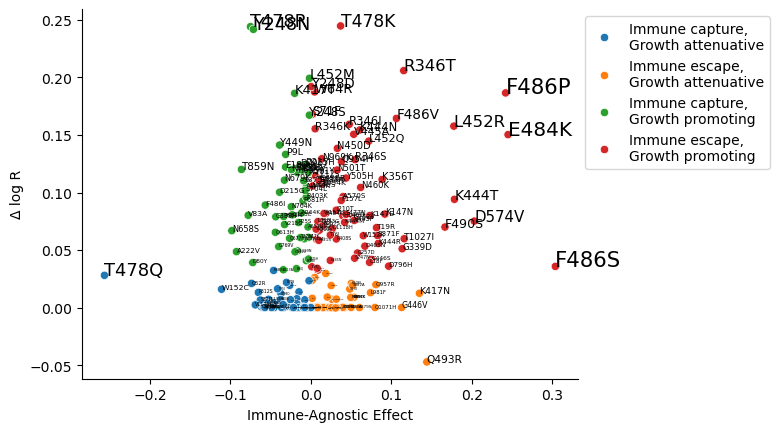

In [434]:
mut_variety_palette = {'Immune capture,\nGrowth attenuative':'tab:blue',
                       'Immune escape,\nGrowth attenuative':'tab:orange',
                       'Immune capture,\nGrowth promoting':'tab:green',
                       'Immune escape,\nGrowth promoting':'tab:red'}

df['Immune Escape'] = df['Immune-Agnostic Effect'] > 0
df['Growth'] = df['Δ log R'] > np.median(df['Δ log R'].values)
df['Mut variety'] = df.apply(lambda row: f"Immune {'escape' if row['Immune Escape'] else 'capture'},\n" +
                                         f"Growth {'promoting' if row['Growth'] else 'attenuative'}", axis=1)

fig, ax = plt.subplots()
sns.scatterplot(x='Immune-Agnostic Effect',
                y='Δ log R',
                hue='Mut variety',
                palette=mut_variety_palette,
                data=df,
                ax=ax);
for _, row in df.iterrows():
    ax.text(row['Immune-Agnostic Effect'],
            row['Δ log R'],
            row['Mutation'],
            fontsize = np.sqrt(row['Immune-Agnostic Effect']**2 + row['Δ log R']**2)*50)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
ax.spines[['top', 'right']].set_visible(False);

In [1037]:
df[['Immune-Agnostic Effect', 'Δ log R']].corr()

Immune-Agnostic Effect   Δ log R
Immune-Agnostic Effect                1.000000  0.156362
Δ log R                               0.156362  1.000000

In [1052]:
slope, intercept, r_value, p_value, std_err = linregress(df['Immune-Agnostic Effect'].values, df['Δ log R'].values)
print(r_value)
print(p_value)

0.15636205432187106
0.015540737544917594


In [435]:
print(accuracy_score(df['Immune Escape'].values, df['Growth'].values))
contingency = df[['Mutation', 'Immune Escape', 'Growth']].groupby(['Immune Escape', 'Growth']).agg('nunique').reset_index().pivot(columns='Growth', index='Immune Escape', values='Mutation')
contingency

0.5481171548117155


Growth         False  True 
Immune Escape              
False             60     48
True              60     71

In [436]:
def plot_regions(ax, options):
    regions = {'NTD':[13,304],
               'RBD':[417,505],
               # '':[438, 508], # RBM
               'FCS':[672,709],
               'FP':[788, 806],
               'IFP':[816, 833],
               'HR1':[918,983],
               'HR2':[1162,1203]}
    
    for r in regions:
        ax.vlines(regions[r], options['ylim'][0], options['ylim'][1], linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
        ax.fill_between(regions[r], options['ylim'][0], options['ylim'][1], color='tab:blue', alpha=0.1)
        ax.text(np.mean(regions[r]), options['ylim'][1]*0.95, r, ha='center', va='top', fontsize=7)

    ax.set_ylim(options['ylim']);

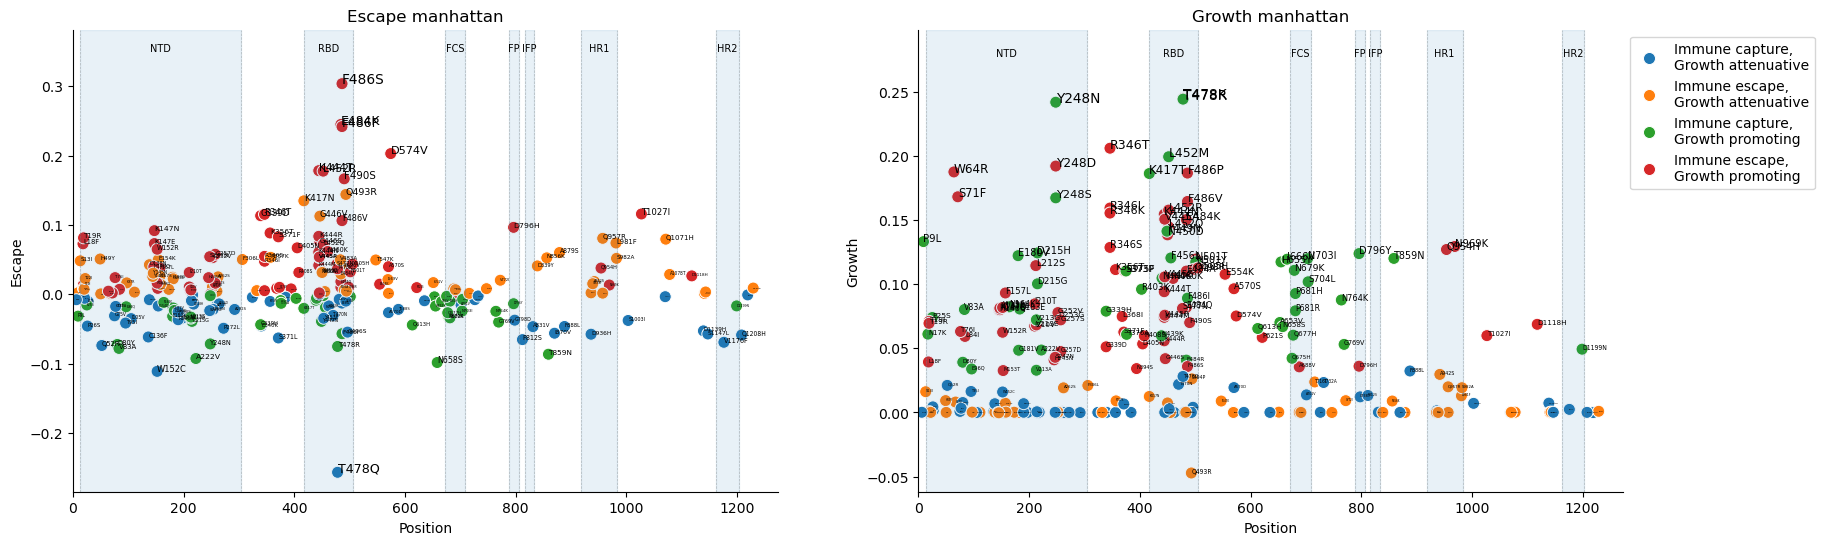

In [437]:
df['Position'] = df['Mutation'].apply(lambda x: int(''.join([_ for _ in x if _.isdigit()])))

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax = axes[0]
ax.set_title('Escape manhattan');
sns.scatterplot(x='Position',
                y='Immune-Agnostic Effect',
                hue='Mut variety',
                palette=mut_variety_palette,
                s=75,
                data=df,
                ax=ax);
for _, row in df.iterrows():
    ax.text(row['Position'],
            row['Immune-Agnostic Effect'],
            row['Mutation'],
            fontsize = 18*np.sqrt(np.abs(row['Immune-Agnostic Effect'])))
ax.set_ylabel('Escape')
ax.legend().set_visible(False);
ax.spines[['top', 'right']].set_visible(False);

ax = axes[1]
ax.set_title('Growth manhattan');
sns.scatterplot(x='Position',
                y='Δ log R',
                hue='Mut variety',
                palette=mut_variety_palette,
                s=75,
                data=df,
                ax=ax);
for _, row in df.iterrows():
    ax.text(row['Position'],
            row['Δ log R'],
            row['Mutation'],
            fontsize = 20*np.sqrt(np.abs(row['Δ log R'])))
ax.set_ylabel('Growth');
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
ax.spines[['top', 'right']].set_visible(False);

for ax in axes:
    xlim = ax.get_xlim();
    ylim = ax.get_ylim()
    ylim = [ylim[0], 1.15*ylim[1]]
    options = {'ylim':ylim}
    plot_regions(ax, options);
    ax.set_xlim([0, 1273]);

In [593]:
df[(df['Position'].apply(lambda x: x >= 13 and x <= 304)) & (df['Mut variety']=='Immune capture,\nGrowth promoting')].sort_values(by='Δ log R')

mutation   Δ log R Mutation  Immune-Agnostic Effect  Immune Escape  \
215  S:V213A  0.032914    V213A               -0.034236          False   
53    S:E96Q  0.033905     E96Q               -0.017884          False   
37    S:D80Y  0.039147     D80Y               -0.072240          False   
69   S:G181V  0.048498    G181V               -0.019670          False   
2    S:A222V  0.048658    A222V               -0.092502          False   
124   S:N17K  0.061066     N17K               -0.003114          False   
217  S:V213G  0.072198    V213G               -0.032742          False   
141   S:P25S  0.073973     P25S               -0.015294          False   
226   S:V83A  0.080241     V83A               -0.077934          False   
154  S:Q183E  0.080591    Q183E               -0.023171          False   
123  S:N164K  0.082302    N164K               -0.011591          False   
27   S:D215G  0.100243    D215G               -0.038934          False   
44   S:E180V  0.122164    E180V               -0.031550          False   
28   S:D215H  0.124283    D215H               -0.006559          False   
235  S:Y248S  0.167211    Y248S               -0.001897          False   
234  S:Y248N  0.241713    Y248N               -0.071465          False   

     Growth                        Mut variety  Position  
215    True  Immune capture,\nGrowth promoting       213  
53     True  Immune capture,\nGrowth promoting        96  
37     True  Immune capture,\nGrowth promoting        80  
69     True  Immune capture,\nGrowth promoting       181  
2      True  Immune capture,\nGrowth promoting       222  
124    True  Immune capture,\nGrowth promoting        17  
217    True  Immune capture,\nGrowth promoting       213  
141    True  Immune capture,\nGrowth promoting        25  
226    True  Immune capture,\nGrowth promoting        83  
154    True  Immune capture,\nGrowth promoting       183  
123    True  Immune capture,\nGrowth promoting       164  
27     True  Immune capture,\nGrowth promoting       215  
44     True  Immune capture,\nGrowth promoting       180  
28     True  Immune capture,\nGrowth promoting       215  
235    True  Immune capture,\nGrowth promoting       248  
234    True  Immune capture,\nGrowth promoting       248

In [597]:
pd.merge(bvas_temp, pool_agnostic_effects, on='Mutation')

Prot:Mut       PIP      Beta   BetaStd  ConditionalBeta  \
0    S:R346T  1.000000  0.558629  0.050388         0.558629   
1    S:R346K  1.000000  0.240102  0.031594         0.240102   
2    S:L452Q  1.000000  0.359452  0.051131         0.359452   
3    S:Q493R  1.000000 -0.472922  0.087927        -0.472922   
4    S:F486V  1.000000  0.499777  0.065401         0.499778   
..       ...       ...       ...       ...              ...   
192  S:A222V  0.013806 -0.000056  0.005949        -0.010150   
193  S:G496S  0.013386 -0.000010  0.007833        -0.001336   
194  S:T478K  0.013137 -0.000086  0.006531        -0.015743   
195  S:G339D  0.012147 -0.000335  0.008128        -0.027581   
196  S:A701V  0.010601 -0.000311  0.006769        -0.024901   

     ConditionalBetaStd  Rank   Run date   Run year Mutation  \
0              0.050388     1 2022-03-29 2022-01-01    R346T   
1              0.031594     2 2022-03-29 2022-01-01    R346K   
2              0.051131     4 2022-03-29 2022-01-01    L452Q   
3              0.087927     5 2022-03-29 2022-01-01    Q493R   
4              0.065399     6 2022-03-29 2022-01-01    F486V   
..                  ...   ...        ...        ...      ...   
192            0.079551  2989 2022-03-29 2022-01-01    A222V   
193            0.089476  2999 2022-03-29 2022-01-01    G496S   
194            0.086929  3005 2022-03-29 2022-01-01    T478K   
195            0.068458  3022 2022-03-29 2022-01-01    G339D   
196            0.055300  3039 2022-03-29 2022-01-01    A701V   

     Immune-Agnostic Effect  
0                  0.115367  
1                  0.005315  
2                  0.071918  
3                  0.144083  
4                  0.106312  
..                      ...  
192               -0.092502  
193               -0.054450  
194                0.036909  
195                0.113402  
196               -0.014807  

[197 rows x 11 columns]

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/110659075.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bvas_temp['Mutation'] = bvas_temp['Prot:Mut'].apply(lambda x: x.replace('S:', ''))
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/110659075.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pyro_temp['Mutation'] = pyro_temp['mutation'].apply(lambda x: x.replace('S:', ''))
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/110659075.py:13: SettingW

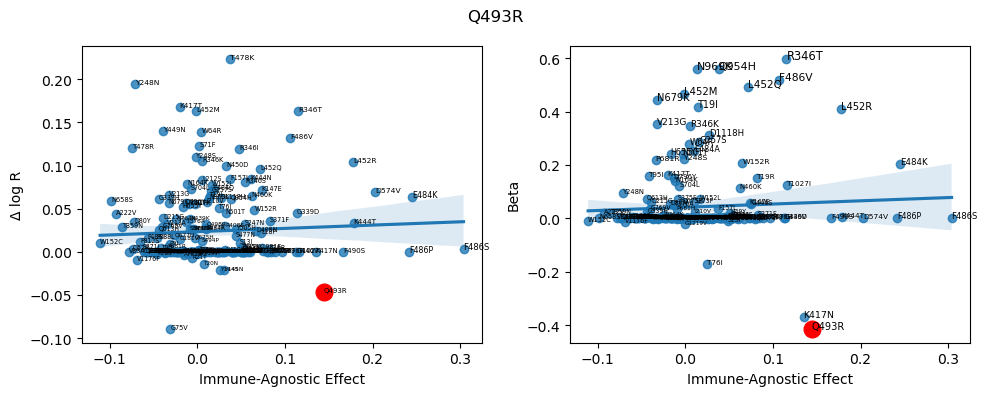

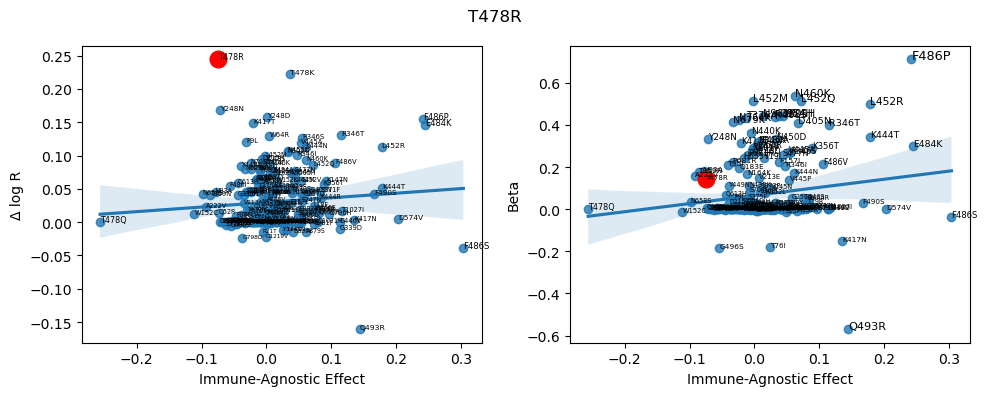

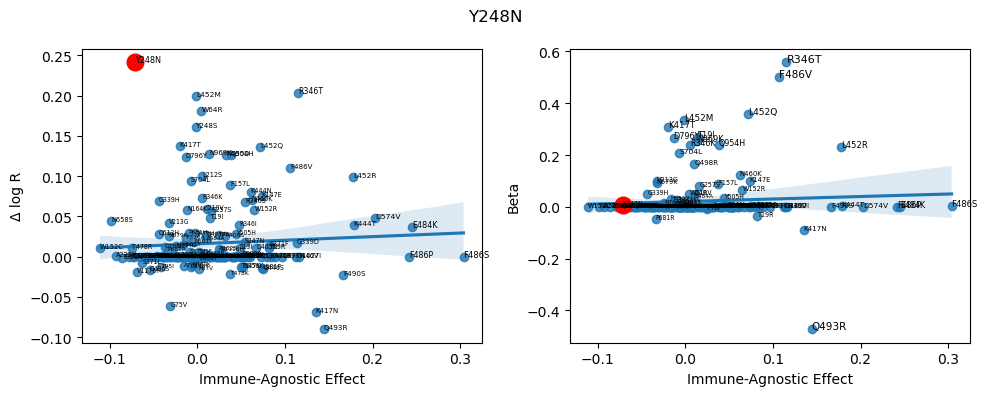

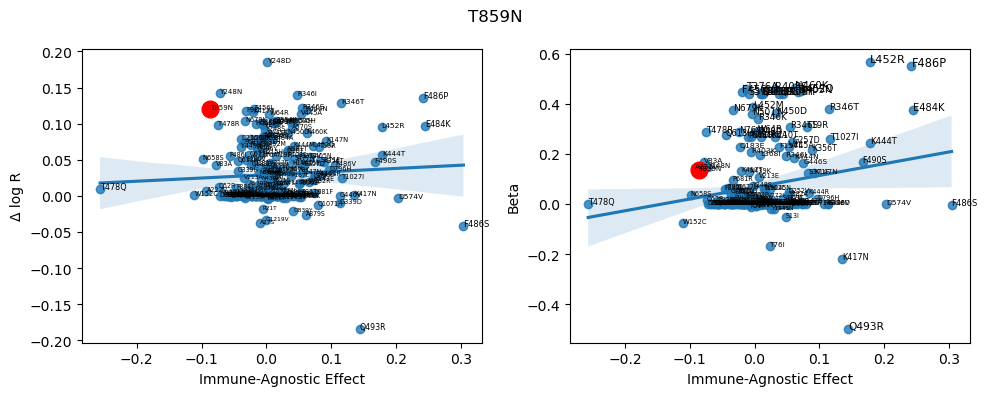

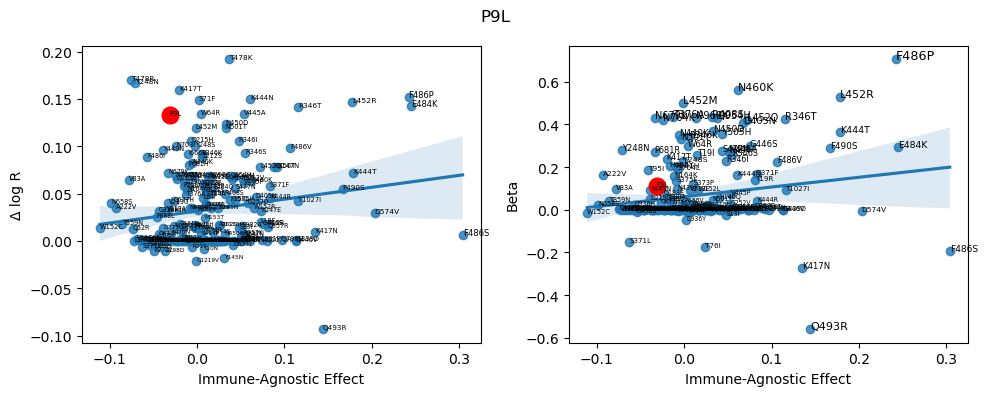

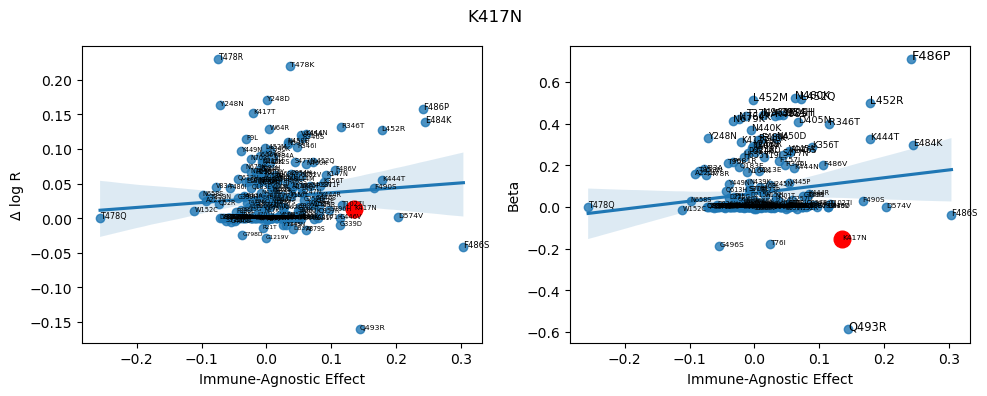

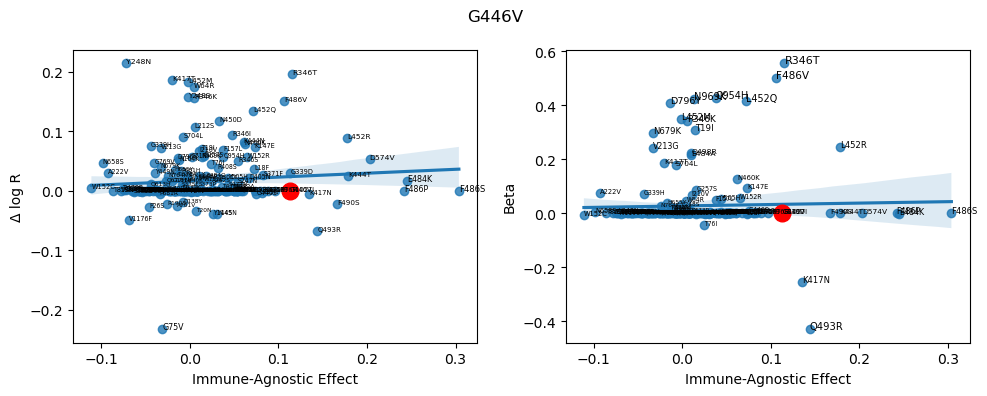

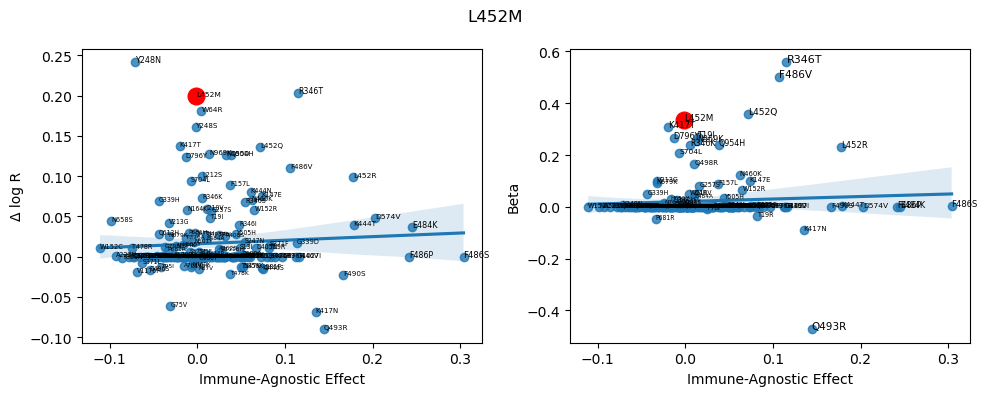

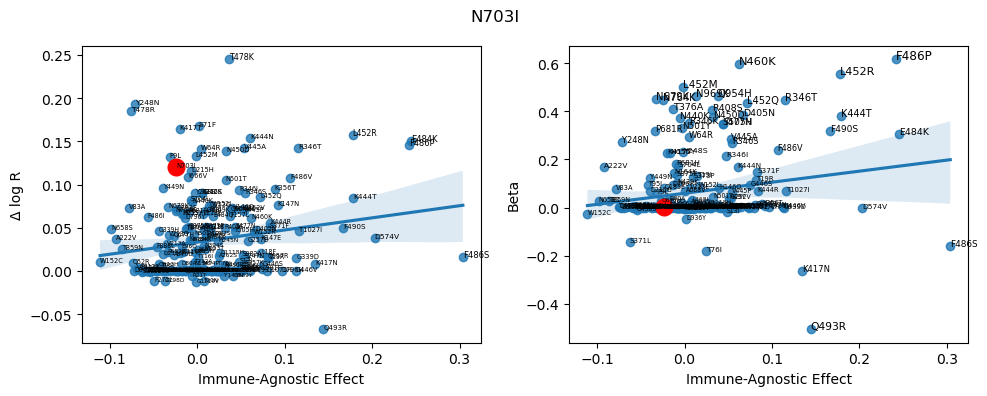

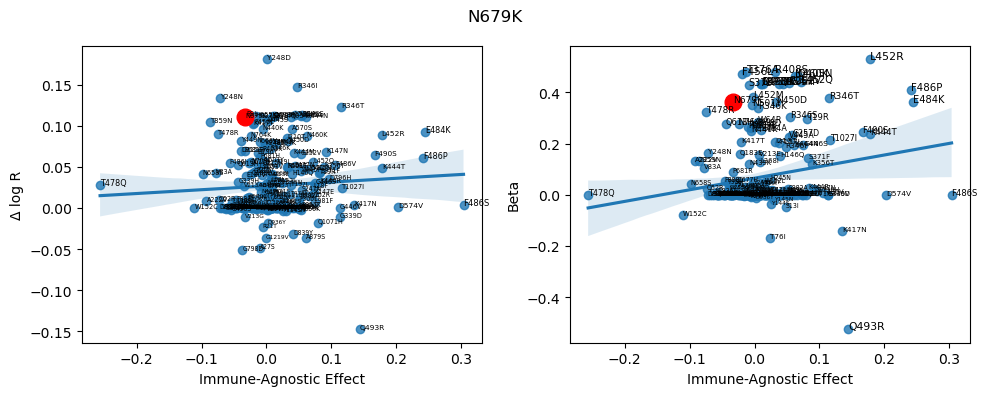

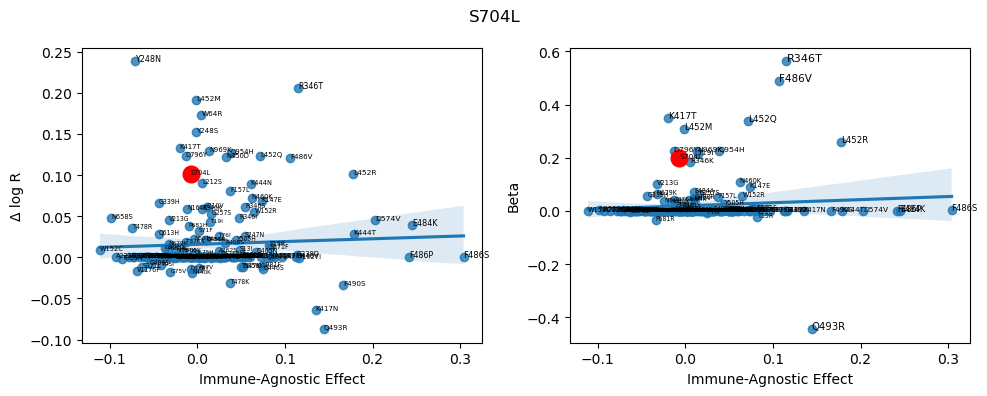

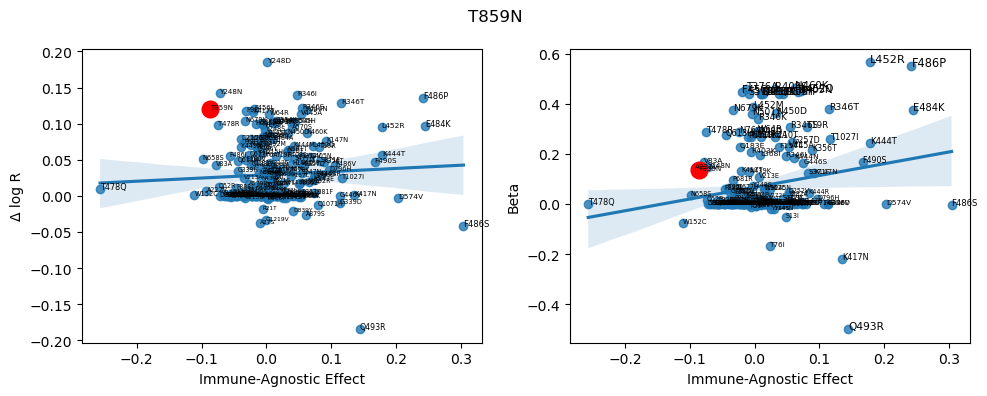

In [637]:
mut_list = ['Q493R','T478R','Y248N','T859N','P9L','K417N','G446V','L452M','N703I','N679K','S704L','T859N']

for mut in mut_list:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    protmut = 'S:'+mut
    max_growth = pyro[pyro['mutation']==protmut]['Δ log R'].max()
    max_date = pyro[(pyro['mutation']==protmut) & (pyro['Δ log R']==max_growth)]['Run date'].values.tolist()[0]
    closest_bvas_date = bvas.loc[(bvas['Run date'] - pd.to_datetime(max_date)).abs().idxmin(), 'Run date']
    
    ax = axes[1]
    bvas_temp = bvas[bvas['Run date']==closest_bvas_date]
    bvas_temp['Mutation'] = bvas_temp['Prot:Mut'].apply(lambda x: x.replace('S:', ''))
    temp_df = pd.merge(bvas_temp, pool_agnostic_effects, on='Mutation')
    sns.regplot(
                x='Immune-Agnostic Effect',
                y='Beta',
                data=temp_df,
                ax=ax);
    for _, row in temp_df.iterrows():
        x = row['Immune-Agnostic Effect']
        y = row['Beta']
        ax.text(x,
                y,
                row['Mutation'],
                fontsize = 4 + 7*np.sqrt(x**2 + y**2))
        if row['Mutation'] == mut:
            ax.plot(x, y, 'ro', markersize=12);

    
    ax = axes[0]
    pyro_temp = pyro[pyro['Run date']==pd.to_datetime(max_date)]
    pyro_temp['Mutation'] = pyro_temp['mutation'].apply(lambda x: x.replace('S:', ''))
    temp_df = pd.merge(pyro_temp, pool_agnostic_effects, on='Mutation')

    sns.regplot(x='Immune-Agnostic Effect',
                y='Δ log R',
                data=temp_df,
                ax=ax);

    for _, row in temp_df.iterrows():
        x = row['Immune-Agnostic Effect']
        y = row['Δ log R']
        ax.text(x,
                y,
                row['Mutation'],
                fontsize = 4 + 7*np.sqrt(x**2 + y**2))
        if row['Mutation'] == mut:
            ax.plot(x, y, 'ro', markersize=12);
            
            
    fig.suptitle(mut);
    fig.tight_layout();

In [920]:
chunk

Virus name Last vaccinated  \
0        hCoV-19/South Korea/KDCA36211s/2022             NaN   
1       hCoV-19/Germany/BW-RKI-I-354764/2021             NaN   
2      hCoV-19/Germany/BW-RKI-I-1062047/2021             NaN   
3      hCoV-19/USA/IN-CDC-STM-W4ZEEF9G4/2021             NaN   
4               hCoV-19/USA/AZ-ASU56669/2021             NaN   
...                                      ...             ...   
99995        hCoV-19/Israel/SMC-7086876/2022             NaN   
99996  hCoV-19/Russia/TYU-RII-MH184086S/2024             NaN   
99997     hCoV-19/Australia/QLD0x00E6EE/2022             NaN   
99998           hCoV-19/Sweden/10264738/2021             NaN   
99999           hCoV-19/Japan/PG-137365/2021             NaN   

      Passage details/history             Type      Accession ID  \
0                    Original  betacoronavirus  EPI_ISL_16821298   
1                    Original  betacoronavirus   EPI_ISL_7416603   
2                    Original  betacoronavirus  EPI_ISL_16155129   
3                    Original  betacoronavirus   EPI_ISL_7311100   
4                    Original  betacoronavirus  EPI_ISL_11569301   
...                       ...              ...               ...   
99995                Original  betacoronavirus  EPI_ISL_13776727   
99996                Original  betacoronavirus  EPI_ISL_19081476   
99997                Original  betacoronavirus  EPI_ISL_12693878   
99998                Original  betacoronavirus  EPI_ISL_10618101   
99999                Original  betacoronavirus   EPI_ISL_5759206   

      Collection date                                         Location  \
0          2022-11-16                               Asia / South Korea   
1          2021-11-29             Europe / Germany / Baden-Wurttemberg   
2          2021-10-18             Europe / Germany / Baden-Wurttemberg   
3          2021-11-21                    North America / USA / Indiana   
4          2021-12-28  North America / USA / Arizona / Maricopa County   
...               ...                                              ...   
99995      2022-07-03                                    Asia / Israel   
99996      2024-04-02         Europe / Russia / Tyumen Region / Tyumen   
99997      2022-05-01                 Oceania / Australia / Queensland   
99998      2021-12-21                          Europe / Sweden / Skane   
99999      2021-08-28                           Asia / Japan / Okayama   

      Additional location information  Sequence length   Host  ...  \
0                                 NaN             3737  Human  ...   
1                                 NaN            29811  Human  ...   
2                                 NaN            29690  Human  ...   
3                                 NaN            29861  Human  ...   
4                                 NaN            29765  Human  ...   
...                               ...              ...    ...  ...   
99995                             NaN            29718  Human  ...   
99996                             NaN            29764  Human  ...   
99997                             NaN            29748  Human  ...   
99998                             NaN            29644  Human  ...   
99999                             NaN            29768  Human  ...   

        Pango version                                   Variant  \
0      consensus call       Former VOC Omicron (B.1.1.529+BA.*)   
1      consensus call         Former VOC Delta (B.1.617.2+AY.*)   
2      consensus call         Former VOC Delta (B.1.617.2+AY.*)   
3      consensus call         Former VOC Delta (B.1.617.2+AY.*)   
4      consensus call         Former VOC Delta (B.1.617.2+AY.*)   
...               ...                                       ...   
99995  consensus call       Former VOC Omicron (B.1.1.529+BA.*)   
99996  consensus call  VOI (JN.1+JN.1.* excluding current VUMs)   
99997  consensus call       Former VOC Omicron (B.1.1.529+BA.*)   
99998     PANGO-v1.23       Former VOC Omicron (

In [921]:
# Survival curves
pattern = r'^\d{4}-\d{2}-\d{2}$'   # YYYY-MM-DD date pattern
# Tensors to hold counts
seq_counts = torch.tensor([]); seq_dates = []
mut_counts = torch.tensor([[]]); mut_dates = []; mut_list = []

for chunk in tqdm(pd.read_csv('data/GISAID/metadata_2025_06_22.tsv.gz', compression='gzip', sep='\t', chunksize=100000)):
    # Match YYYY-MM-DD date pattern
    chunk = chunk[chunk['Collection date'].astype(str).str.match(pattern)]
    chunk = chunk[['Collection date', 'AA Substitutions', 'Accession ID']].dropna()
    
    # Count sequences
    seq_chunk = chunk.groupby('Collection date').agg('nunique').reset_index()
    seq_chunk_counts = seq_chunk['Accession ID'].values.tolist()         # Counts in this chunk
    seq_chunk_dates = seq_chunk['Collection date'].values.tolist()       # Dates in this chunk
    seq_dates += list(set(seq_chunk_dates) - set(seq_dates))             # Comprehensive list of dates
    # Create empty tensor
    seq_counts_pad = torch.zeros(len(seq_dates))
    # Populate with existing counts
    seq_counts_pad[:seq_counts.shape[0]] = seq_counts
    # Add in new data
    seq_date_idx = [seq_dates.index(d) for d in seq_chunk_dates]
    seq_counts_pad[seq_date_idx] += torch.tensor(seq_chunk_counts)
    # Save
    seq_counts = seq_counts_pad
    
    # Count mutations
    mut_chunk = chunk.copy()
    mut_chunk['AA Substitutions'] = mut_chunk['AA Substitutions'].apply(lambda x: x.replace(')','').replace('(','').split(','))
    mut_chunk['AA Substitutions'] = mut_chunk['AA Substitutions'].apply(lambda x: [mut.replace('Spike_','') for mut in x if mut.startswith('Spike_')])
    mut_chunk = mut_chunk.explode('AA Substitutions').groupby(['AA Substitutions', 'Collection date'])['Accession ID'].agg('nunique').reset_index()
    mut_chunk = mut_chunk.pivot(index='Collection date', columns='AA Substitutions', values='Accession ID').fillna(0) 
    mut_chunk_counts = mut_chunk.values                       # Counts in this chunk
    mut_chunk_dates = mut_chunk.index.tolist()                # Dates in this chunk
    mut_chunk_list = mut_chunk.columns.tolist()               # Mutations in this chunk
    mut_dates += list(set(mut_chunk_dates) - set(mut_dates))  # Comprehensive list of dates
    mut_list += list(set(mut_chunk_list) - set(mut_list))     # Comprehensive list of muts
    # Create empty tensor
    mut_counts_pad = torch.zeros(len(mut_dates), len(mut_list))
    # Populate with existing counts
    mut_counts_pad[:mut_counts.shape[0], :mut_counts.shape[1]] = mut_counts
    # Add in new data
    mut_date_idx = torch.tensor([mut_dates.index(d) for d in mut_chunk_dates])     # shape: len(mut_date_idx)
    mut_list_idx = torch.tensor([mut_list.index(m) for m in mut_chunk_list])       # shape: len(mut_list_idx)
    # "zip" idx pairs
    mut_date_idx = mut_date_idx[:, None].expand(-1, mut_list_idx.size(0))          # shape: [len(mut_date_idx), len(mut_list_idx)]
    mut_list_idx = mut_list_idx[None, :].expand(mut_date_idx.size(0), -1)          # shape: [len(mut_date_idx), len(mut_list_idx)]
    zipped_idxs = (mut_date_idx, mut_list_idx)
    # Add
    mut_counts_pad.index_put_(zipped_idxs, torch.tensor(mut_chunk_counts).to(mut_counts_pad.dtype), accumulate=True)
    # Save
    mut_counts = mut_counts_pad

171it [14:52,  5.20s/it]/Users/kotzen/opt/anaconda3/envs/pyro/lib/python3.10/site-packages/tqdm/std.py:1181: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  for obj in iterable:
173it [15:01,  5.21s/it]


In [922]:
mut_counts_df = pd.DataFrame(columns=mut_list, index=mut_dates, data=mut_counts).melt(var_name='Mutation', value_name='Count', ignore_index=False)
mut_counts_df = mut_counts_df.reset_index().rename(columns={'index':'Collection date', 'Count':'Mut count'})

seq_counts_df = pd.DataFrame(index=seq_dates, data=seq_counts).rename(columns={0:'Count'})
seq_counts_df = seq_counts_df.reset_index().rename(columns={'index':'Collection date', 'Count':'Seq count'})

muller_df = pd.merge(mut_counts_df, seq_counts_df, on='Collection date')
muller_df['Mut prop'] = muller_df['Mut count'] / muller_df['Seq count']
muller_df

Collection date     Mutation  Mut count  Seq count  Mut prop
0             2022-07-01        A123L        0.0    18934.0       0.0
1             2022-07-01        H146R        0.0    18934.0       0.0
2             2022-07-01        D138H        0.0    18934.0       0.0
3             2022-07-01        G447S        0.0    18934.0       0.0
4             2022-07-01         S50F        0.0    18934.0       0.0
...                  ...          ...        ...        ...       ...
61984460      2019-12-31        K835C        0.0        2.0       0.0
61984461      2019-12-31        F759R        0.0        2.0       0.0
61984462      2019-12-31      ins859A        0.0        2.0       0.0
61984463      2019-12-31  ins386stopM        0.0        2.0       0.0
61984464      2019-12-31     ins16AAF        0.0        2.0       0.0

[61984465 rows x 5 columns]

In [923]:
muller_df[['Mutation', 'Mut prop']].groupby('Mutation').agg(max).reset_index().sort_values(by='Mut prop', ascending=False).head(40)

Mutation  Mut prop
13236      N460K       1.0
10811     L24del       1.0
20030      T572I       1.0
7402       H245N       1.0
17913      S373P       1.0
17887      S371F       1.0
6405       G446S       1.0
17799       S31P       1.0
9590       K444R       1.0
2977       D614G       1.0
14176     P1143L       1.0
11082      L455S       1.0
5070       F456L       1.0
21376      V213G       1.0
3106       D796Y       1.0
9529       K417N       1.0
738        A570V       1.0
13712      N764K       1.0
4632       F157S       1.0
11067      L452W       1.0
17925      S375F       1.0
10633      L216F       1.0
13568      N679K       1.0
10615      L212I       1.0
21235      V127F       1.0
14398     P25del       1.0
5111       F486P       1.0
19876      T478K       1.0
14418     P26del       1.0
19750      T376A       1.0
22204     V70del       1.0
2733       D405N       1.0
6026       G142D       1.0
18147       S50L       1.0
14815      P621S       1.0
21745      V445R       1.0
18110      S477N       1.0
18790      S939F       1.0
14866      P681R       1.0
25305  ins16MPLF       1.0

In [924]:
muller_df[muller_df['Mutation']=='T859N'].sort_values(by='Mut prop', ascending=False)

Collection date Mutation  Mut count  Seq count  Mut prop
5338415       2021-04-11    T859N      179.0     9115.0  0.019638
28953030      2021-06-09    T859N      188.0     9953.0  0.018889
43333925      2021-04-10    T859N      224.0    11877.0  0.018860
57933185      2021-05-05    T859N      287.0    15471.0  0.018551
25022460      2021-05-16    T859N      109.0     5935.0  0.018366
...                  ...      ...        ...        ...       ...
25677555      2020-07-22    T859N        0.0     1776.0  0.000000
25646360      2025-05-08    T859N        0.0      297.0  0.000000
25615165      2023-12-14    T859N        0.0     3731.0  0.000000
25490385      2023-08-26    T859N        0.0     2153.0  0.000000
61957340      2019-12-31    T859N        0.0        2.0  0.000000

[1987 rows x 5 columns]

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/3653360007.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  Stability=('Mut variety', lambda s: 1/entropy_cat(s) if entropy_cat(s)!=None else None))
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/3653360007.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  Stability=('Mut variety', lambda s: 1/entropy_cat(s) if entropy_cat(s)!=None else None))
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/3653360007.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  Stability=('Mut variety', lambda s: 1/entropy_cat(s) if entropy_cat(s)!=None else None))
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/3653360007.py:94: RuntimeWarning: divide by zero encountered in scalar divide
  Stability=('Mut variety', lambda s: 1/entropy_cat(s) if entropy_cat(s)!=None else None))
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189

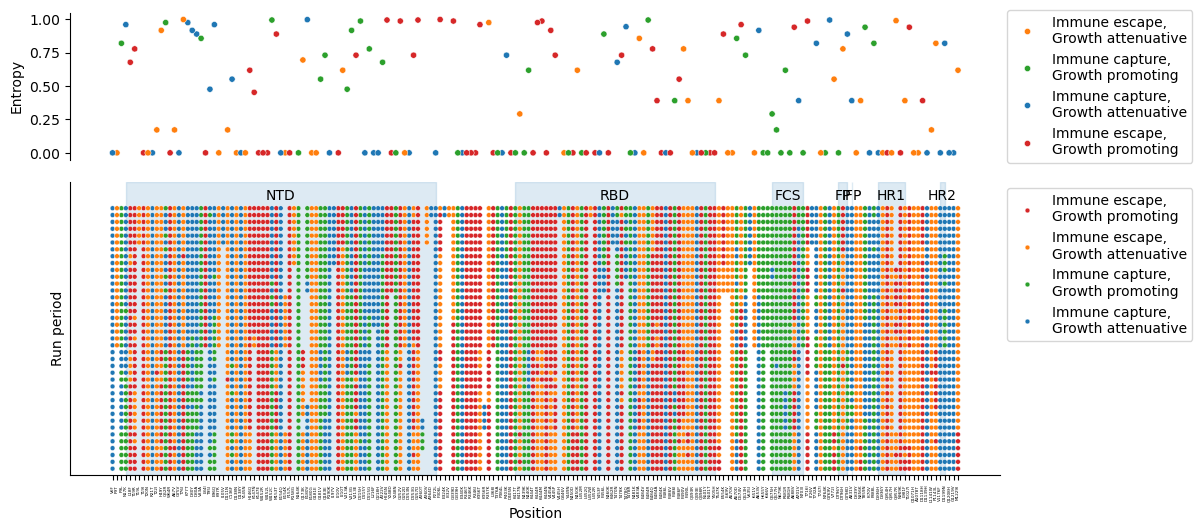

In [279]:
def get_region(position):
    regions = {'NTD':[13,304],
               'RBD':[417,505],
               # '':[438, 508], # RBM
               'FCS':[672,709],
               'FP':[788, 806],
               'IFP':[816, 833],
               'HR1':[918,983],
               'HR2':[1162,1203]}
    for r, v in regions.items():
        if position >= v[0] and position <= v[1]:
            return r
    return 'Other'


growth_escape_time = all_df[(~all_df['Immune-Agnostic Effect'].isna()) & (~all_df['Run period'].isna())].sort_values(by='Run period')
growth_escape_time['Run period'] = growth_escape_time['Run date']
growth_escape_time['Position'] = growth_escape_time['Mutation'].apply(lambda x: int(''.join([_ for _ in x if _.isdigit()])))
medians = growth_escape_time.groupby('Run period')['Δ log R'].transform('median')
growth_escape_time['Growth'] = growth_escape_time['Δ log R'] > medians
growth_escape_time['Immune Escape'] = growth_escape_time['Immune-Agnostic Effect'] > 0
growth_escape_time['Mut variety'] = growth_escape_time.apply(lambda row: f"Immune {'escape' if row['Immune Escape'] else 'capture'},\n" +
                                                                         f"Growth {'promoting' if row['Growth'] else 'attenuative'}", axis=1)



# Columns for plotting
mut_pos_df = growth_escape_time[['Mutation', 'Position']].drop_duplicates().sort_values(by='Position', ascending=True).reset_index(drop=True)
mut_pos_df['y'] = mut_pos_df.index
mut_pos_df['Region'] = mut_pos_df['Position'].apply(get_region)

run_period_cat_df = growth_escape_time[['Run period']].drop_duplicates().sort_values(by='Run period', ascending=True).reset_index(drop=True)
run_period_cat_df['x'] = run_period_cat_df.index

growth_escape_time = pd.merge(growth_escape_time, mut_pos_df, on=['Mutation', 'Position'])
growth_escape_time = pd.merge(growth_escape_time, run_period_cat_df, on=['Run period'])



fig, axes = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios':[1,2]})

ax = axes[1]
sns.scatterplot(x='y',
                y='x',
                s=12,
                # marker='s',
                hue='Mut variety',
                palette=mut_variety_palette,
                data=growth_escape_time,
                ax=ax);

ylim = ax.get_ylim();
ylim = [ylim[0]+1, 1.05*ylim[1]]
for reg, row in mut_pos_df[['Region', 'y']].groupby('Region').agg(start=('y',min),
                                                                  end=('y',max)).iterrows():
    if not reg=='Other':
        ax.fill_between([row['start'], row['end']], [ylim[0], ylim[0]], [ylim[1], ylim[1]],
                        color='tab:blue', alpha=0.15, zorder=-1);
        ax.text(np.mean([row['start'], row['end']]), ylim[1]-1, reg, ha='center', va='top');
ax.set_ylim(ylim);
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
# ax.set_xticks([]); 
ax.set_xticks(sorted(growth_escape_time['y'].unique().tolist()))
ax.set_xticklabels(growth_escape_time[['y', 'Mutation']].drop_duplicates().sort_values(by='y')['Mutation'].tolist(),
                  rotation=90, fontsize=3, ha='center');
ax.set_yticks([]);
ax.set_xlabel('Position');
ax.set_ylabel('Run period');
ax.spines[['top', 'right']].set_visible(False);

xlim = ax.get_xlim();




ax = axes[0]
def entropy_cat(series):
    if len(series) < 10:
        return None
    # Count frequency of each category
    value_counts = series.value_counts(normalize=True)
    return entropy(value_counts, base=2)  # base 2 gives bits

def mode_string(series):
    mode_vals = series.mode()
    if mode_vals.empty:
        return None
    return mode_vals.iloc[0]  # Return the first mode if there's a tie

entropy_df = (
    growth_escape_time[['Mutation', 'y', 'Mut variety']]
    .groupby(['Mutation', 'y'])
    .agg(Entropy=('Mut variety', entropy_cat),
         Stability=('Mut variety', lambda s: 1/entropy_cat(s) if entropy_cat(s)!=None else None))
    .reset_index()
    # .rename(columns={'Mut variety': 'Entropy'})
)
entropy_df = pd.merge(entropy_df,
                      growth_escape_time[['Mutation', 'Mut variety']].groupby('Mutation').agg(mode_string).reset_index(),
                      on='Mutation')

sns.scatterplot(x='y',
                y='Entropy',
                data=entropy_df,
                s=20,
                hue='Mut variety',
                palette=mut_variety_palette,
                # size='Entropy',
                # sizes=(10,100),
                ax=ax);
ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
ax.set_xlim(xlim);
ax.xaxis.set_visible(False);
ax.spines[['top', 'bottom', 'right']].set_visible(False);

fig.subplots_adjust(hspace=0.1);
fig.savefig('figs/ALTERNATE_FIGURE_4/manhattan_regime.png', dpi=400);

In [281]:
# Pull some infectivity data from Dadonaite et. al., 2024
# https://www.nature.com/articles/s41586-024-07636-1
# Data here: https://github.com/dms-vep/SARS-CoV-2_XBB.1.5_spike_DMS/blob/main/results/summaries/summary.csv
dms = pd.read_csv('https://raw.githubusercontent.com/dms-vep/SARS-CoV-2_XBB.1.5_spike_DMS/refs/heads/main/results/summaries/summary.csv')
dms['Mutation'] = dms['wildtype'].astype(str) + dms['site'].astype(str) + dms['mutant'].astype(str)
dms

site wildtype mutant  human sera escape  spike mediated entry  \
0        2        F      C            0.01114               0.10100   
1        2        F      L            0.01876               0.09432   
2        2        F      S            0.03169               0.05844   
3        2        F      F            0.00000               0.00000   
4        3        V      A            0.02402              -0.04154   
...    ...      ...    ...                ...                   ...   
8345  1211        K      K            0.00000               0.00000   
8346  1212        W      R                NaN              -2.37700   
8347  1212        W      W            0.00000               0.00000   
8348   767        L      L            0.00000               0.00000   
8349   767        L      V                NaN                   NaN   

      ACE2 binding  sequential_site region Mutation  
0          0.02151                2  other      F2C  
1         -0.26980                2  other      F2L  
2         -0.05642                2  other      F2S  
3          0.00000                2  other      F2F  
4         -0.04977                3  other      V3A  
...            ...              ...    ...      ...  
8345       0.00000             1207     S2   K1211K  
8346      -0.21050             1208  other   W1212R  
8347       0.00000             1208  other   W1212W  
8348       0.00000              763     S2    L767L  
8349       1.69700              763     S2    L767V  

[8350 rows x 9 columns]

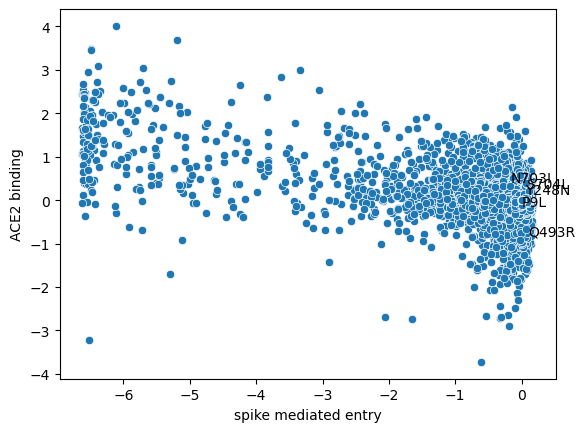

In [381]:
fig, ax = plt.subplots()

sns.scatterplot(x='spike mediated entry',
                y='ACE2 binding',
                data=dms,
                ax=ax);

for mut in ['Q493R', 'Y248N', 'N703I', 'S704L', 'P9L']: # 'T478R', 'D706Y'
    x = dms[dms['Mutation']==mut]['spike mediated entry'].values[0]
    y = dms[dms['Mutation']==mut]['ACE2 binding'].values[0]
    ax.text(x, y, mut);

<Axes: xlabel='ACE2 binding', ylabel='Count'>

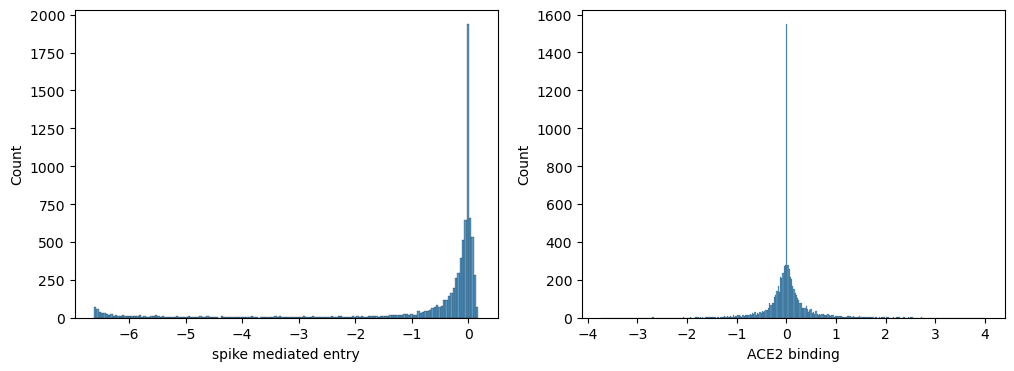

In [382]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(x='spike mediated entry',
             ax=axes[0],
             data=dms)
sns.histplot(x='ACE2 binding',
             ax=axes[1],
             data=dms)

T478R
Y258N
K417N
G446V
N679K


/Users/kotzen/opt/anaconda3/envs/pyro/lib/python3.10/site-packages/matplotlib/text.py:753: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/kotzen/opt/anaconda3/envs/pyro/lib/python3.10/site-packages/matplotlib/text.py:894: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))


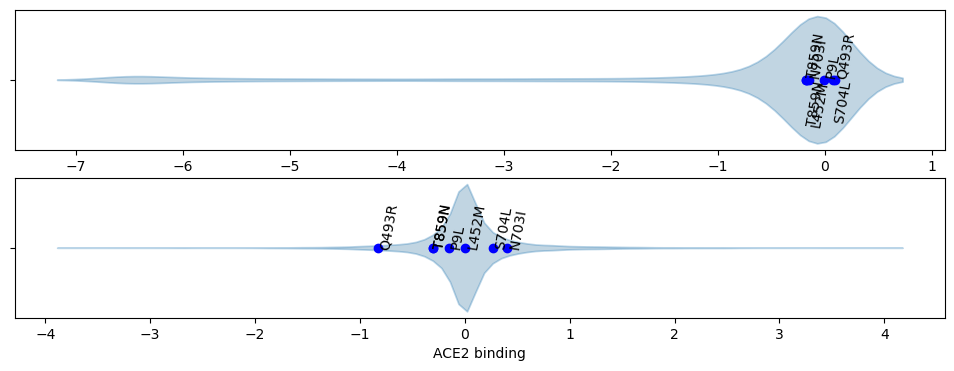

In [465]:
fig, axes = plt.subplots(2, 1, figsize=(12, 4))

sns.violinplot(x='spike mediated entry',
               inner=None,
               alpha=0.3,
               edgecolor='tab:blue',
             ax=axes[0],
             data=dms)
sns.violinplot(x='ACE2 binding',
               inner=None,
               alpha=0.3,
               edgecolor='tab:blue',
             ax=axes[1],
             data=dms)
i = 0 
for mut in ['Q493R','T478R','Y258N','T859N','P9L','K417N','G446V','L452M','N703I','N679K','S704L','T859N']:
    row = dms[dms['Mutation']==mut]
    if len(row)==0:
        print(mut)
        continue
    axes[0].plot(row['spike mediated entry'],
                 0,
                 'bo')
    axes[0].text(row['spike mediated entry'],
                 0,
                 mut, rotation=80, va='bottom' if i%2==0 else 'top')
    axes[1].plot(row['ACE2 binding'],
                 0,
                 'bo')
    axes[1].text(row['ACE2 binding'],
                 0,
                 mut, rotation=80)
    i+=1

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


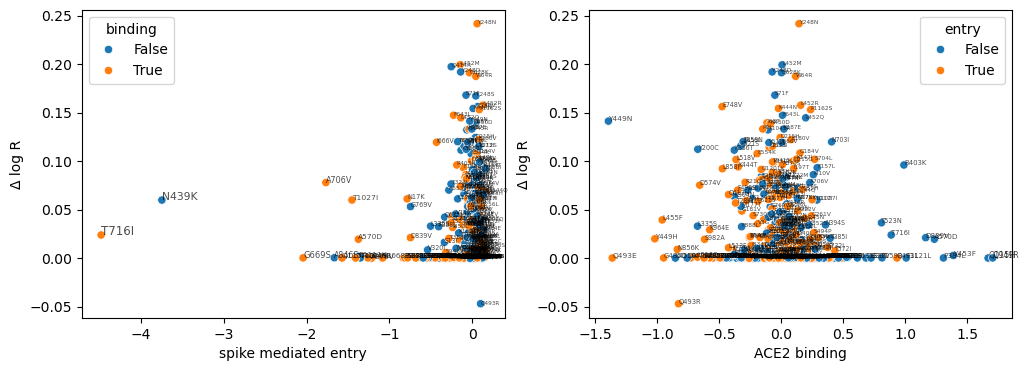

In [301]:
growth_inf = pd.merge(pyro_temp, dms, on='Mutation')
growth_inf['entry'] = growth_inf['spike mediated entry'] > np.median(growth_inf['spike mediated entry'])
growth_inf['binding'] = growth_inf['ACE2 binding'] > 0
growth_inf['growth'] = growth_inf['Δ log R'] > np.median(growth_inf['Δ log R'])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
sns.scatterplot(x='spike mediated entry',
                y='Δ log R',
                hue='binding',
                data=growth_inf,
                ax=ax)
for _, row in growth_inf.iterrows():
    ax.text(row['spike mediated entry'],
            row['Δ log R'],
            row['Mutation'],
            fontsize = 4+1*np.sqrt(row['spike mediated entry']**2 + row['Δ log R']**2),
            alpha=0.7)

ax = axes[1]
sns.scatterplot(x='ACE2 binding',
                y='Δ log R',
                hue='entry',
                data=growth_inf,
                ax=ax)
for _, row in growth_inf.iterrows():
    ax.text(row['ACE2 binding'],
            row['Δ log R'],
            row['Mutation'],
            fontsize = 4+1*np.sqrt(row['ACE2 binding']**2 + row['Δ log R']**2),
            alpha=0.7)

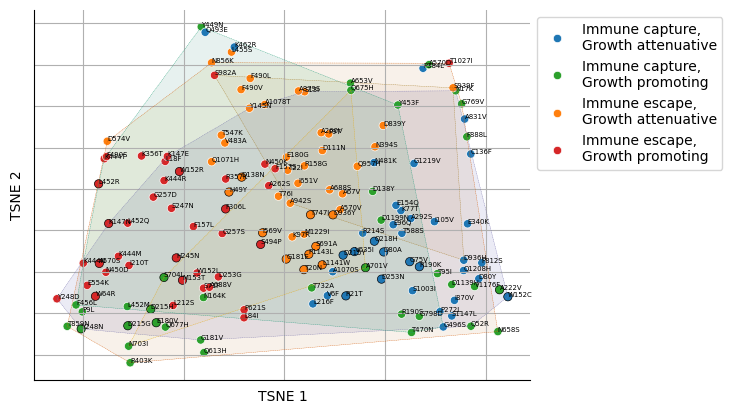

In [687]:
tsne_df = pd.merge(dms.drop(columns='region'),
                   pd.merge(pyro_temp, pool_agnostic_effects, on='Mutation'), 
                   on='Mutation').dropna()
tsne_df['Region'] = tsne_df['site'].apply(lambda x: get_region(x))
tsne_df['Immune Escape'] = tsne_df['Immune-Agnostic Effect'] > 0
tsne_df['Growth'] = tsne_df['Δ log R'] > np.median(tsne_df['Δ log R'])
tsne_df['Binding'] = tsne_df['ACE2 binding'] > np.median(tsne_df['ACE2 binding'])
tsne_df['Entry'] = tsne_df['spike mediated entry'] > np.median(tsne_df['spike mediated entry'])
tsne_df['Mut variety'] = tsne_df.apply(lambda row: f"Immune {'escape' if row['Immune Escape'] else 'capture'},\n" +
                                                   f"Growth {'promoting' if row['Growth'] else 'attenuative'}", axis=1)

from sklearn.manifold import TSNE

X = tsne_df[['Immune-Agnostic Effect', 'Δ log R', 'ACE2 binding', 'spike mediated entry']]
X = StandardScaler().fit_transform(X)
X_embedded = TSNE(n_components=2, learning_rate='auto', perplexity=30, random_state=38,
                  init='random').fit_transform(X)

tsne_df['TSNE 1'] = X_embedded[:, 0]
tsne_df['TSNE 2'] = X_embedded[:, 1]

fig, ax = plt.subplots()
sns.scatterplot(x='TSNE 1',
                y='TSNE 2',
                hue='Mut variety',
                palette=mut_variety_palette,
                data=tsne_df,
                ax=ax);
for _, row in tsne_df.iterrows():
    ax.text(row['TSNE 1'],
            row['TSNE 2'],
            row['Mutation'],
            fontsize = 5);
    
# Add convex hulls
from scipy.spatial import ConvexHull
# Region hulls
region_palette = dict({r:c for r,c in zip(['RBD', 'Other', 'NTD', 'HR2', 'FP', 'FCS', 'HR1', 'IFP'], sns.color_palette('Dark2'))})
for r in tsne_df['Region'].unique():
    points = np.array(tsne_df[tsne_df['Region']==r][['TSNE 1', 'TSNE 2']].values.tolist())
    if points.shape[0]>2:
        hull = ConvexHull(points)
        for simplex in hull.simplices:
            ax.plot(points[simplex, 0], points[simplex, 1], linestyle='--', linewidth=0.25, color=region_palette[r])
            ax.fill(points[hull.vertices, 0], points[hull.vertices, 1],
                     facecolor=region_palette[r], alpha=0.01, zorder=-1)
# # Binding hull
# points = np.array(tsne_df[tsne_df['Binding']==True][['TSNE 1', 'TSNE 2']].values.tolist())
# binding_hull = ConvexHull(points)
# for simplex in binding_hull.simplices:
#     ax.plot(points[simplex, 0], points[simplex, 1], 'r--', linewidth=0.25)
# # Entry hull
# points = np.array(tsne_df[tsne_df['Entry']==True][['TSNE 1', 'TSNE 2']].values.tolist())
# entry_hull = ConvexHull(points)
# for simplex in entry_hull.simplices:
#     ax.plot(points[simplex, 0], points[simplex, 1], 'b--', linewidth=0.25)
    
    
# Show binding points
# sns.scatterplot(x='TSNE 1',
#                 y='TSNE 2',
#                 data=tsne_df[tsne_df['Binding']==True],
#                 marker='o',
#                 facecolor=None,
#                 edgecolor='k',
#                 hue='Mut variety',
#                 palette=mut_variety_palette,
#                 legend=False,
#                 ax=ax);
# # # Show entry points
# sns.scatterplot(x='TSNE 1',
#                 y='TSNE 2',
#                 data=tsne_df[tsne_df['Entry']==True],
#                 marker='x',
#                 facecolor='k',
#                 edgecolor='k',
#                 legend=False,
#                 ax=ax);
sns.scatterplot(x='TSNE 1',
                y='TSNE 2',
                data=tsne_df[(tsne_df['Entry']==True) & (tsne_df['Binding']==True)],
                marker='o',
                facecolor=None,
                edgecolor='k',
                hue='Mut variety',
                palette=mut_variety_palette,
                legend=False,
                ax=ax);
ax.legend(loc='upper left', bbox_to_anchor=(1, 1));
ax.grid(True);
ax.set_xticklabels([]);
ax.set_yticklabels([]);
ax.tick_params(length=0);
ax.spines[['top', 'right']].set_visible(False);

## Escape DMS

In [52]:
escape_dms = pd.read_csv('data/EVEscape/spike_evescape_predictions.csv', index_col=0)
escape_dms['Mutation'] = escape_dms['wt'].astype(str) + escape_dms['i'].astype(str) + escape_dms['mut'].astype(str)
escape_dms = escape_dms[['Mutation', 'max_escape_bloom', 'max_escape_xie']].dropna()
escape_dms

Mutation  max_escape_bloom  max_escape_xie
0        F490R           0.99250        0.994200
3        F486R           1.00000        0.978800
10       E484R           1.00000        0.996900
13       V483R           0.97790        0.964600
16       E484K           1.00000        1.011000
...        ...               ...             ...
21216    C432T           0.00000        0.000000
21304    C391M           0.06221        0.007148
21434    C432Y           0.00000        0.000000
21522    C432W           0.00000        0.000000
21666    C432P           0.00000        0.000000

[3819 rows x 3 columns]

In [53]:
pd.merge(pd.merge(escape_dms, pool_specific_effects_piv, on='Mutation', how='outer'), pool_agnostic_effects, on='Mutation', how='inner')

Mutation  max_escape_bloom  max_escape_xie  Alpha: Escape  B.1: Escape  \
0      F490R            0.9925          0.9942            NaN    -0.027529   
1      E484R            1.0000          0.9969            NaN     0.024577   
2      E484K            1.0000          1.0110       0.500568     0.344016   
3      L452R            0.9836          0.9581       0.227733     0.174241   
4      R346T            0.9002          0.9785            NaN     0.162932   
..       ...               ...             ...            ...          ...   
788      Δ74               NaN             NaN            NaN     0.049136   
789      Δ75               NaN             NaN            NaN     0.064921   
790      Δ76               NaN             NaN            NaN     0.002668   
791      Δ77               NaN             NaN            NaN    -0.010703   
792      Δ78               NaN             NaN            NaN     0.032030   

     BA.1: Escape  BA.2.12.1: Escape  Beta: Escape  Delta: Escape  \
0        0.059001           0.059723           NaN       0.214351   
1             NaN                NaN           NaN            NaN   
2        0.267386           0.232809      0.317118       0.488768   
3        0.366311           0.261384      0.201084       0.241936   
4        0.180430           0.221799           NaN       0.105446   
..            ...                ...           ...            ...   
788           NaN                NaN           NaN            NaN   
789           NaN                NaN           NaN            NaN   
790           NaN                NaN           NaN            NaN   
791           NaN                NaN           NaN            NaN   
792           NaN                NaN           NaN            NaN   

     Omicron BA.4/5: Escape  Immune-Agnostic Effect  
0                  0.012662                0.049766  
1                       NaN               -0.005716  
2                  0.248529                0.245032  
3                  0.249669                0.177670  
4                  0.147021                0.115367  
..                      ...                     ...  
788                0.078671                0.041396  
789                0.054863                0.048006  
790               -0.012567                0.008449  
791               -0.015609               -0.013748  
792               -0.010687               -0.002605  

[793 rows x 11 columns]

0.1004540472608424


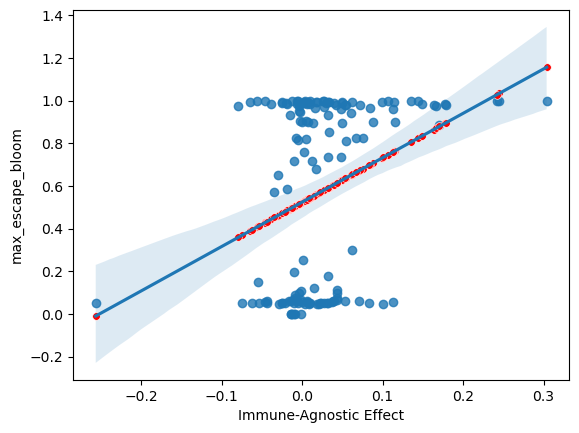

In [54]:
# Simple univariate linear regression
regressors = ['Immune-Agnostic Effect'] # 'Alpha: Escape', 'B.1: Escape', 'BA.1: Escape', 'BA.2.12.1: Escape', 'Beta: Escape', 'Delta: Escape', 'Omicron BA.4/5: Escape']
regressand = ['max_escape_bloom'] # ['max_escape_xie']

Xy = pd.merge(pd.merge(escape_dms, pool_specific_effects_piv, on='Mutation', how='outer'), pool_agnostic_effects, on='Mutation', how='outer')[regressors+regressand].dropna()
X = Xy[regressors].values
y = Xy[regressand].values


standard_scaler=True
# Standardize predictors
if standard_scaler:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

# Fit regression
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = model.score(X, y)

fig, ax = plt.subplots()
sns.regplot(x=regressors[0],
            y=regressand[0],
            data=Xy,
            ax=ax);
sns.scatterplot(x=scaler.inverse_transform(X).squeeze() if standard_scaler else X.squeeze(),
                y=y_pred.squeeze(),
                marker='o',
                color='red',
                s=30,
                ax=ax);

print(r2)

/Users/kotzen/opt/anaconda3/envs/pyro/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6095890410958904


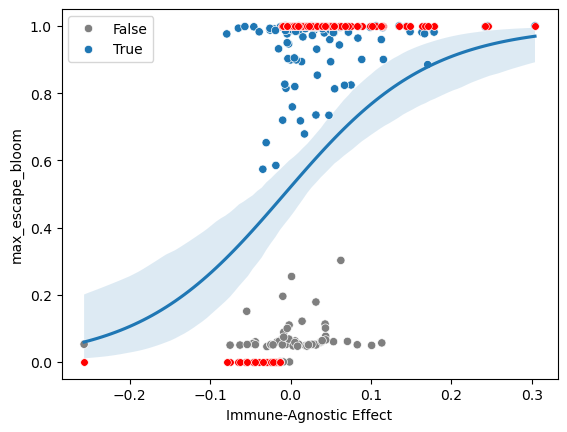

In [55]:
# Univariate Logistic Regression
regressors = ['Immune-Agnostic Effect'] # 'Alpha: Escape', 'B.1: Escape', 'BA.1: Escape', 'BA.2.12.1: Escape', 'Beta: Escape', 'Delta: Escape', 'Omicron BA.4/5: Escape']
regressand = ['max_escape_bloom'] # ['max_escape_xie']

Xy = pd.merge(pd.merge(escape_dms, pool_specific_effects_piv, on='Mutation', how='outer'), pool_agnostic_effects, on='Mutation', how='outer')[regressors+regressand].dropna()
X = Xy[regressors].values
y = Xy[regressand].values > 0.5


standard_scaler=True
# Standardize predictors
if standard_scaler:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

# Fit regression
model = LogisticRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = model.score(X, y)

fig, ax = plt.subplots()
sns.regplot(x=regressors[0],
            y=regressand[0],
            logistic=True,
            data=Xy,
            scatter=False,
            ax=ax);
sns.scatterplot(x=regressors[0],
                y=regressand[0],
                data=Xy.assign(dms_escape_bin=lambda x: x[regressand[0]]>0.5),
                hue='dms_escape_bin',
                palette={False:'tab:gray', True:'tab:blue'},
                ax=ax);
sns.scatterplot(x=scaler.inverse_transform(X).squeeze() if standard_scaler else X.squeeze(),
                y=y_pred.squeeze(),
                marker='o',
                color='red',
                s=30,
                ax=ax);

print(r2)

Optimization terminated successfully.
         Current function value: 0.648764
         Iterations 5
[0.00157251]
[[43 17]
 [44 42]]
0.5821917808219178


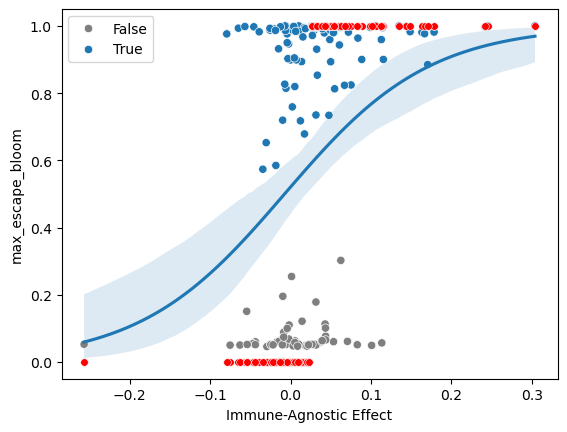

In [56]:
# Univariate Logistic Regression
regressors = ['Immune-Agnostic Effect'] # 'Alpha: Escape', 'B.1: Escape', 'BA.1: Escape', 'BA.2.12.1: Escape', 'Beta: Escape', 'Delta: Escape', 'Omicron BA.4/5: Escape']
regressand = ['max_escape_bloom'] # ['max_escape_xie']

Xy = pd.merge(pd.merge(escape_dms, pool_specific_effects_piv, on='Mutation', how='outer'), pool_agnostic_effects, on='Mutation', how='outer')[regressors+regressand].dropna()
X = Xy[regressors].values
y = Xy[regressand].values > 0.5


standard_scaler=True
# Standardize predictors
if standard_scaler:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

# Fit regression
import statsmodels.api as sm
from sklearn.metrics import (confusion_matrix, 
                           accuracy_score)

model = sm.Logit(y, X)
model = model.fit()
y_pred = list(map(round, model.predict(X)))
# r2 = model.score(X, y)
pvals = model.pvalues
cm = confusion_matrix(y, y_pred)

fig, ax = plt.subplots()
sns.regplot(x=regressors[0],
            y=regressand[0],
            logistic=True,
            data=Xy,
            scatter=False,
            ax=ax);
sns.scatterplot(x=regressors[0],
                y=regressand[0],
                data=Xy.assign(dms_escape_bin=lambda x: x[regressand[0]]>0.5),
                hue='dms_escape_bin',
                palette={False:'tab:gray', True:'tab:blue'},
                ax=ax);
sns.scatterplot(x=scaler.inverse_transform(X).squeeze() if standard_scaler else X.squeeze(),
                y=y_pred,
                marker='o',
                color='red',
                s=30,
                ax=ax);

# print(r2)
print(pvals)
print(cm)
print(accuracy_score(y, y_pred))

/Users/kotzen/opt/anaconda3/envs/pyro/lib/python3.10/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


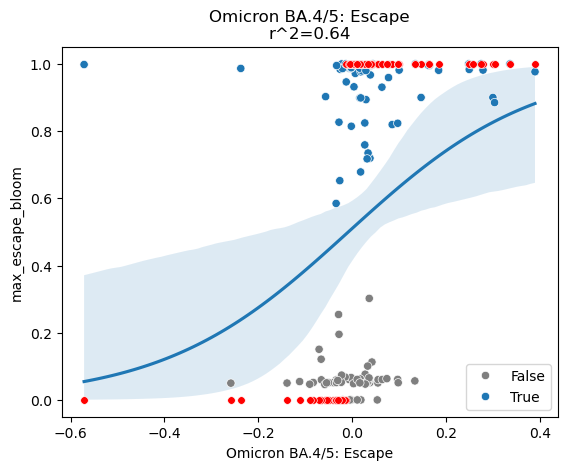

In [57]:
# Univariate Logistic Regression
regressors = ['Omicron BA.4/5: Escape'] # 'Alpha: Escape', 'B.1: Escape', 'BA.1: Escape', 'BA.2.12.1: Escape', 'Beta: Escape', 'Delta: Escape', 'Omicron BA.4/5: Escape']
regressand = ['max_escape_bloom'] # ['max_escape_xie']

Xy = pd.merge(pd.merge(escape_dms, pool_specific_effects_piv, on='Mutation', how='outer'), pool_agnostic_effects, on='Mutation', how='outer')[regressors+regressand].dropna()
X = Xy[regressors].values
y = Xy[regressand].values > 0.5


standard_scaler=True
# Standardize predictors
if standard_scaler:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

# Fit regression
model = LogisticRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = model.score(X, y)

fig, ax = plt.subplots()
sns.regplot(x=regressors[0],
            y=regressand[0],
            logistic=True,
            data=Xy,
            scatter=False,
            ax=ax);
sns.scatterplot(x=regressors[0],
                y=regressand[0],
                data=Xy.assign(dms_escape_bin=lambda x: x[regressand[0]]>0.5),
                hue='dms_escape_bin',
                palette={False:'tab:gray', True:'tab:blue'},
                ax=ax);
sns.scatterplot(x=scaler.inverse_transform(X).squeeze() if standard_scaler else X.squeeze(),
                y=y_pred.squeeze(),
                marker='o',
                color='red',
                s=30,
                ax=ax);

ax.set_title(f'{regressors[0]}\nr^2={r2:.2f}');

In [58]:
# Univariate Logistic Regression
regressors = ['Immune-Agnostic Effect'] # 'Alpha: Escape', 'B.1: Escape', 'BA.1: Escape', 'BA.2.12.1: Escape', 'Beta: Escape', 'Delta: Escape', 'Omicron BA.4/5: Escape']
regressand = ['max_escape_bloom'] # ['max_escape_xie']

for regressor in ['Alpha: Escape', 'B.1: Escape', 'BA.1: Escape', 'BA.2.12.1: Escape', 'Beta: Escape', 'Delta: Escape', 'Omicron BA.4/5: Escape']:
    print(regressor)
    regressors = [regressor]
    Xy = pd.merge(pd.merge(escape_dms, pool_specific_effects_piv, on='Mutation', how='outer'), pool_agnostic_effects, on='Mutation', how='outer')[regressors+regressand].dropna()
    X = Xy[regressors].values
    y = Xy[regressand].values > 0.5


    standard_scaler=True
    # Standardize predictors
    if standard_scaler:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    # Fit regression
    import statsmodels.api as sm
    from sklearn.metrics import (confusion_matrix, 
                               accuracy_score)

    model = sm.Logit(y, X)
    model = model.fit()
    y_pred = list(map(round, model.predict(X)))
    # r2 = model.score(X, y)
    pvals = model.pvalues
    cm = confusion_matrix(y, y_pred)

    # print(r2)
    print(pvals)
    print(cm)
    print(accuracy_score(y, y_pred))
    print('\n')

Alpha: Escape
Optimization terminated successfully.
         Current function value: 0.674058
         Iterations 5
[0.34137469]
[[6 4]
 [9 8]]
0.5185185185185185


B.1: Escape
Optimization terminated successfully.
         Current function value: 0.650019
         Iterations 6
[0.00230881]
[[44 16]
 [46 40]]
0.5753424657534246


BA.1: Escape
Optimization terminated successfully.
         Current function value: 0.622502
         Iterations 5
[0.01493035]
[[14  3]
 [16 19]]
0.6346153846153846


BA.2.12.1: Escape
Optimization terminated successfully.
         Current function value: 0.589721
         Iterations 5
[0.00913127]
[[11  4]
 [15 14]]
0.5681818181818182


Beta: Escape
Optimization terminated successfully.
         Current function value: 0.692855
         Iterations 3
[0.9019661]
[[5 5]
 [9 7]]
0.46153846153846156


Delta: Escape
Optimization terminated successfully.
         Current function value: 0.659910
         Iterations 5
[0.09787994]
[[11  4]
 [16 15]]
0.5652173913043

x0 = 0.01829146221280098
c = 0.7942680486793525
k = 10.0



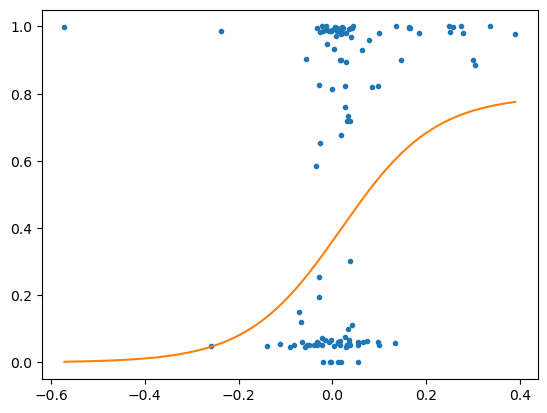

In [59]:
import scipy.optimize

def sigmoid(p,x):
    (x0, c, k) = p
    y = c / (1 + np.exp(-k*(x-x0)))
    return y

def residuals(p,x,y):
    return y - sigmoid(p,x)
cost_func = residuals

X = Xy[regressors].values.squeeze()
y = Xy[regressand].values.squeeze()

p_guess=(np.median(X),
         np.median(y),
         10.)
p, cov, infodict, mesg, ier = scipy.optimize.leastsq(
                                    cost_func, 
                                    p_guess, 
                                    args=(X,y), 
                                    full_output=1)  

(x0, c, k) = p
print('''\
x0 = {x0}
c = {c}
k = {k}
'''.format(x0=x0,c=c,k=k))

xp = np.linspace(min(X), max(X), 1500)
pxp=sigmoid(p,xp) #sigmoid((0, 1, 100), xp)

fig, ax = plt.subplots()
ax.plot(X, y, '.')
ax.plot(xp, pxp, '-')

x0 = 0.3480691692786964
c = 2.1532386699619055
k = 3.552190609744818



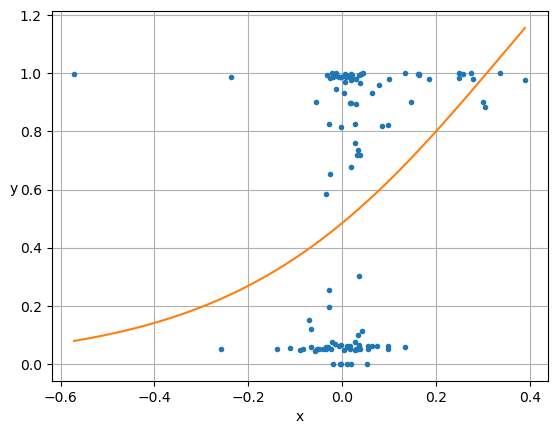

In [60]:
def sigmoid(p,x):
    x0,c,k=p
    y = c / (1 + np.exp(-k*(x-x0)))
    return y

def residuals(p,x,y):
    return y - sigmoid(p,x)

def resize(arr,lower=0.0,upper=1.0):
    arr=arr.copy()
    if lower>upper: lower,upper=upper,lower
    arr -= arr.min()
    arr *= (upper-lower)/arr.max()
    arr += lower
    return arr

# raw data
x = np.array(Xy[regressors].values.squeeze(),dtype='float')
y = np.array(Xy[regressand].values.squeeze(),dtype='float')

p_guess=(np.median(x),1.0,1.0)
p, cov, infodict, mesg, ier = scipy.optimize.leastsq(
    residuals,p_guess,args=(x,y),full_output=1)  

x0,c,k=p
print('''\
x0 = {x0}
c = {c}
k = {k}
'''.format(x0=x0,c=c,k=k))

xp = np.linspace(min(x), max(x), 1500)
pxp=sigmoid(p,xp)

# Plot the results
plt.plot(x, y, '.', xp, pxp, '-')
plt.xlabel('x')
plt.ylabel('y',rotation='horizontal') 
plt.grid(True)
plt.show()

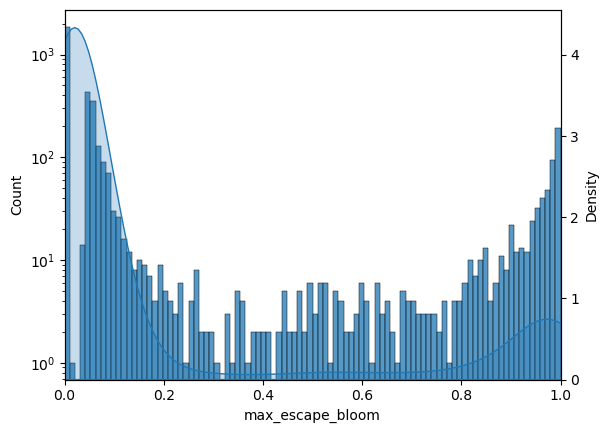

In [61]:
fig, ax = plt.subplots()
sns.histplot(x='max_escape_bloom',
             data=escape_dms,
             ax=ax)
ax.set_yscale('log');

ax2 = ax.twinx()
sns.kdeplot(x='max_escape_bloom',
            data=escape_dms,
            fill=True,
            ax=ax2);
ax2.set_xlim([0,1]);

In [936]:
# Neutralization DMS
# https://pmc.ncbi.nlm.nih.gov/articles/PMC9922669/#sec4

# BA.1
dadonaite_ba1_constructs_cc67105_escape = pd.read_csv('https://raw.githubusercontent.com/dms-vep/SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs/refs/heads/main/results/antibody_escape/CC67.105_avg.csv')
dadonaite_ba1_constructs_cc9104_escape = pd.read_csv('https://github.com/dms-vep/SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs/raw/refs/heads/main/results/antibody_escape/CC9.104_avg.csv')
dadonaite_ba1_constructs_lycov1404_escape = pd.read_csv('https://github.com/dms-vep/SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs/raw/refs/heads/main/results/antibody_escape/LyCoV-1404_avg.csv')
dadonaite_ba1_constructs_ntd57_escape = pd.read_csv('https://github.com/dms-vep/SARS-CoV-2_Omicron_BA.1_spike_DMS_mAbs/raw/refs/heads/main/results/antibody_escape/NTD_5-7_avg.csv')
# Record antibodies
dadonaite_ba1_constructs_cc67105_escape['Antibody'] = 'CC67.105'
dadonaite_ba1_constructs_cc9104_escape['Antibody'] = 'CC9.104'
dadonaite_ba1_constructs_lycov1404_escape['Antibody'] = 'LyCoV-1404'
dadonaite_ba1_constructs_ntd57_escape['Antibody'] = 'NTD_5-7'
# Concat
dadonaite_ba1_all = pd.concat([dadonaite_ba1_constructs_cc67105_escape, 
                               dadonaite_ba1_constructs_cc9104_escape,
                               dadonaite_ba1_constructs_lycov1404_escape,
                               dadonaite_ba1_constructs_ntd57_escape])
dadonaite_ba1_all['Base VoC'] = 'BA.1'


# Delta
dadonaite_delta_267c = pd.read_csv('https://github.com/dms-vep/SARS-CoV-2_Delta_spike_DMS_REGN10933/raw/refs/heads/main/results/antibody_escape/267C_avg.csv')
dadonaite_delta_279c = pd.read_csv('https://github.com/dms-vep/SARS-CoV-2_Delta_spike_DMS_REGN10933/raw/refs/heads/main/results/antibody_escape/279C_avg.csv')
dadonaite_delta_regn10933 = pd.read_csv('https://github.com/dms-vep/SARS-CoV-2_Delta_spike_DMS_REGN10933/raw/refs/heads/main/results/antibody_escape/279C_avg.csv')
# Record antibodies
dadonaite_delta_267c['Antibody'] = '267C'
dadonaite_delta_279c['Antibody'] = '279C'
dadonaite_delta_regn10933['Antibody'] = 'REGN10933'
# Concat
dadonaite_delta_all = pd.concat([dadonaite_delta_267c,
                                 dadonaite_delta_279c,
                                 dadonaite_delta_regn10933])
dadonaite_delta_all['Base VoC'] = 'Delta'


# Agg
dadonaite_all = pd.concat([dadonaite_ba1_all, dadonaite_delta_all])
dadonaite_all_means = dadonaite_all[['mutation', 'escape_mean']].groupby('mutation').agg('mean').reset_index().rename(columns={'mutation':'Mutation'})

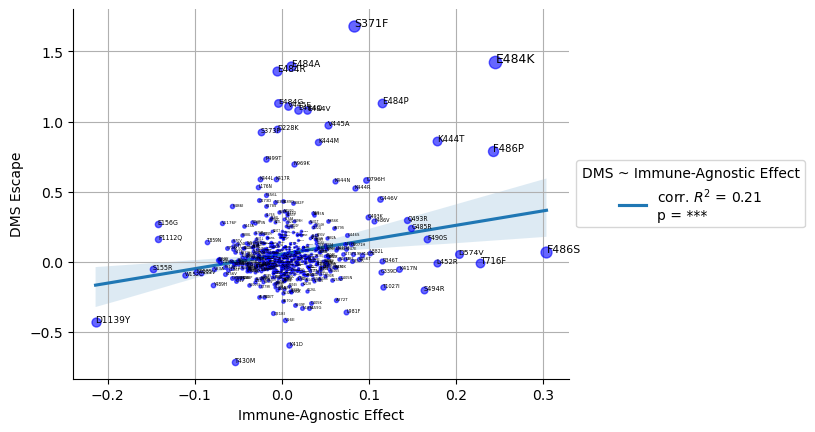

In [1029]:
fig, ax = plt.subplots()

plot_df = pd.merge(dadonaite_all_means, pool_agnostic_effects)
x_var = 'Immune-Agnostic Effect'
y_var = 'escape_mean'

sns.regplot(x=x_var,
            y=y_var,
            data=plot_df,
            scatter=False,
            ax=ax);

x_mean = plot_df[x_var].mean();
x_max = np.max([plot_df[x_var].max(), -plot_df[x_var].min()])
y_mean = plot_df[y_var].mean()
y_max = np.max([plot_df[y_var].max(), -plot_df[y_var].min()])

for _, row in plot_df.iterrows():
    x = row[x_var]
    y = row[y_var]
    size = 1+7*np.sqrt(((x-x_mean)/x_max)**2 + ((y-y_mean)/y_max)**2)
    ax.plot(x, y, 'o', markersize=size, color='blue', alpha=0.6)
    ax.text(x, y, row['Mutation'], fontsize=size);
    
ax.set_xlabel('Immune-Agnostic Effect');
ax.set_ylabel('DMS Escape');
ax.spines[['top', 'right']].set_visible(False);
ax.grid(True);

slope, intercept, r_value, p_value, std_err = linregress(plot_df[x_var], plot_df[y_var])
legend_text = f'corr. $R^2$ = {plot_df[[x_var, y_var]].corr().iloc[0, 1]:.2f}\np = {"***" if p_value<0.05 else "ns"}'
ax.legend([legend_text], 
          bbox_to_anchor=(1, 0.5), 
          loc='center left',
          title='DMS ~ Immune-Agnostic Effect',
          frameon=True);

# fig.tight_layout();
fig.savefig('figs/ALTERNATE_FIGURE_4/dms_regplot.png', dpi=200, bbox_inches='tight')

In [1024]:
pyro_max = pyro[pyro['mutation'].apply(lambda x: x.startswith('S:'))]
pyro_max['Mutation'] = pyro_max['mutation'].apply(lambda x: x.replace('S:', ''))
pyro_max = pyro_max[['Mutation', 'Δ log R', 'R / R_A']].groupby('Mutation').agg('max').reset_index()

bvas_max = bvas[bvas['Prot:Mut'].apply(lambda x: x.startswith('S:'))]
bvas_max['Mutation'] = bvas_max['Prot:Mut'].apply(lambda x: x.replace('S:', ''))
bvas_max = bvas_max[['Mutation', 'Beta', 'PIP']].groupby('Mutation').agg('max').reset_index()

/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/524079290.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pyro_max['Mutation'] = pyro_max['mutation'].apply(lambda x: x.replace('S:', ''))
/var/folders/lj/kt2p_lkd6rbg0tlbf4ykgqrm0000gq/T/ipykernel_53189/524079290.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bvas_max['Mutation'] = bvas_max['Prot:Mut'].apply(lambda x: x.replace('S:', ''))


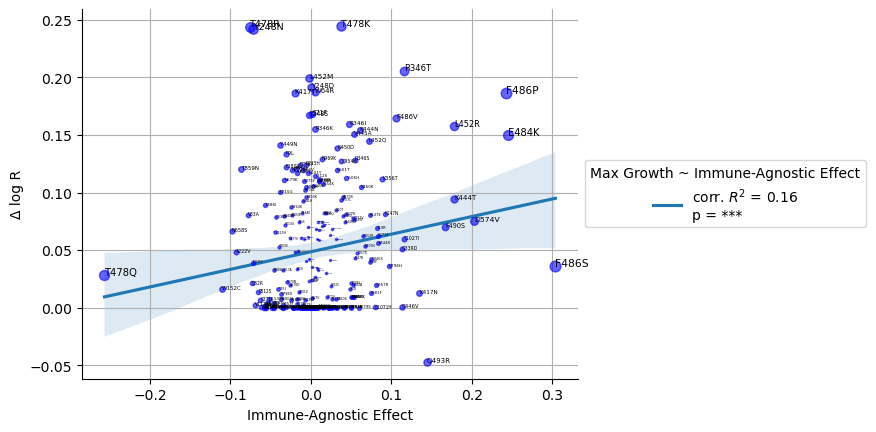

In [1030]:
fig, ax = plt.subplots()

plot_df = pd.merge(pyro_max, pool_agnostic_effects)
x_var = 'Immune-Agnostic Effect'
y_var = 'Δ log R'

sns.regplot(x=x_var,
            y=y_var,
            data=plot_df,
            scatter=False,
            ax=ax);

x_mean = plot_df[x_var].mean();
x_max = np.max([plot_df[x_var].max(), -plot_df[x_var].min()])
y_mean = plot_df[y_var].mean()
y_max = np.max([plot_df[y_var].max(), -plot_df[y_var].min()])

for _, row in plot_df.iterrows():
    x = row[x_var]
    y = row[y_var]
    size = 1+7*np.sqrt(((x-x_mean)/x_max)**2 + ((y-y_mean)/y_max)**2)
    ax.plot(x, y, 'o', markersize=size, color='blue', alpha=0.6)
    ax.text(x, y, row['Mutation'], fontsize=size);
    
ax.set_xlabel('Immune-Agnostic Effect');
ax.set_ylabel('Δ log R');
ax.spines[['top', 'right']].set_visible(False);
ax.grid(True);

slope, intercept, r_value, p_value, std_err = linregress(plot_df[x_var], plot_df[y_var])
legend_text = f'corr. $R^2$ = {plot_df[[x_var, y_var]].corr().iloc[0, 1]:.2f}\np = {"***" if p_value<0.05 else "ns"}'
ax.legend([legend_text], 
          bbox_to_anchor=(1, 0.5), 
          loc='center left',
          title='Max Growth ~ Immune-Agnostic Effect',
          frameon=True);

fig.savefig('figs/ALTERNATE_FIGURE_4/pyro_regplot.png', dpi=200, bbox_inches='tight')

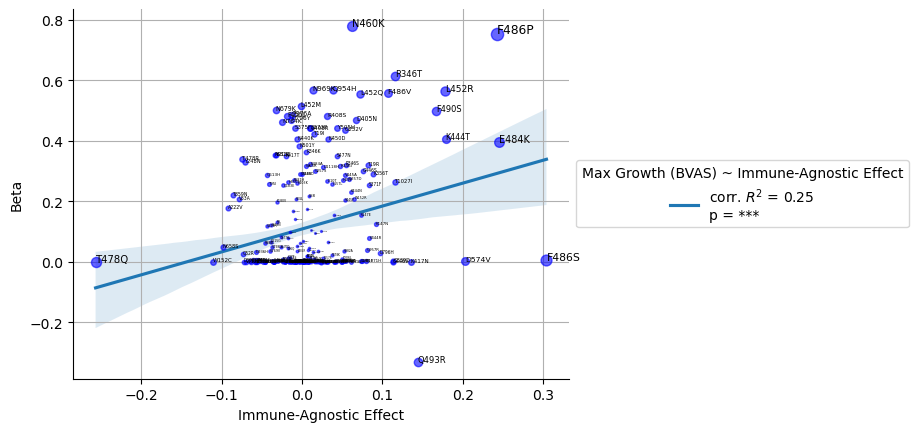

In [1031]:
fig, ax = plt.subplots()

plot_df = pd.merge(bvas_max, pool_agnostic_effects)
x_var = 'Immune-Agnostic Effect'
y_var = 'Beta'

sns.regplot(x=x_var,
            y=y_var,
            data=plot_df,
            scatter=False,
            ax=ax);

x_mean = plot_df[x_var].mean();
x_max = np.max([plot_df[x_var].max(), -plot_df[x_var].min()])
y_mean = plot_df[y_var].mean()
y_max = np.max([plot_df[y_var].max(), -plot_df[y_var].min()])

for _, row in plot_df.iterrows():
    x = row[x_var]
    y = row[y_var]
    size = 1+7*np.sqrt(((x-x_mean)/x_max)**2 + ((y-y_mean)/y_max)**2)
    ax.plot(x, y, 'o', markersize=size, color='blue', alpha=0.6)
    ax.text(x, y, row['Mutation'], fontsize=size);
    
ax.set_xlabel('Immune-Agnostic Effect');
ax.set_ylabel('Beta');
ax.spines[['top', 'right']].set_visible(False);
ax.grid(True);

slope, intercept, r_value, p_value, std_err = linregress(plot_df[x_var], plot_df[y_var])
legend_text = f'corr. $R^2$ = {plot_df[[x_var, y_var]].corr().iloc[0, 1]:.2f}\np = {"***" if p_value<0.05 else "ns"}'
ax.legend([legend_text], 
          bbox_to_anchor=(1, 0.5), 
          loc='center left',
          title='Max Growth (BVAS) ~ Immune-Agnostic Effect',
          frameon=True);

fig.savefig('figs/ALTERNATE_FIGURE_4/bvas_regplot.png', dpi=200, bbox_inches='tight')

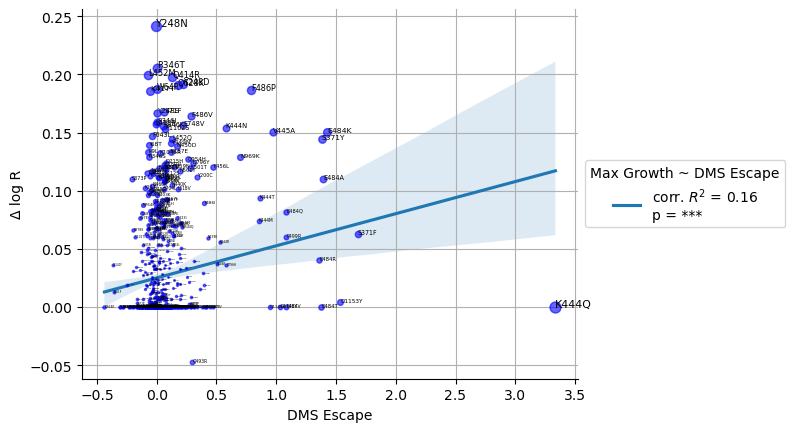

In [1032]:
fig, ax = plt.subplots()

plot_df = pd.merge(pyro_max, dadonaite_all_means)
x_var = 'escape_mean'
y_var = 'Δ log R'

sns.regplot(x=x_var,
            y=y_var,
            data=plot_df,
            scatter=False,
            ax=ax);

x_mean = plot_df[x_var].mean();
x_max = np.max([plot_df[x_var].max(), -plot_df[x_var].min()])
y_mean = plot_df[y_var].mean()
y_max = np.max([plot_df[y_var].max(), -plot_df[y_var].min()])

for _, row in plot_df.iterrows():
    x = row[x_var]
    y = row[y_var]
    size = 1+7*np.sqrt(((x-x_mean)/x_max)**2 + ((y-y_mean)/y_max)**2)
    ax.plot(x, y, 'o', markersize=size, color='blue', alpha=0.6)
    ax.text(x, y, row['Mutation'], fontsize=size);
    
ax.set_xlabel('DMS Escape');
ax.set_ylabel('Δ log R');
ax.spines[['top', 'right']].set_visible(False);
ax.grid(True);

slope, intercept, r_value, p_value, std_err = linregress(plot_df[x_var], plot_df[y_var])
legend_text = f'corr. $R^2$ = {plot_df[[x_var, y_var]].corr().iloc[0, 1]:.2f}\np = {"***" if p_value<0.05 else "ns"}'
ax.legend([legend_text], 
          bbox_to_anchor=(1, 0.5), 
          loc='center left',
          title='Max Growth ~ DMS Escape',
          frameon=True);

fig.savefig('figs/ALTERNATE_FIGURE_4/pyro_dms_regplot.png', dpi=200, bbox_inches='tight')

In [1033]:
pyro_max

Mutation   Δ log R  R / R_A
0     A1020S  0.032969  1.03352
1     A1020V  0.000088  1.00009
2     A1070S  0.000028  1.00003
3     A1078S  0.011430  1.01150
4     A1078T  0.000212  1.00021
..       ...       ...      ...
721    Y449H  0.019832  1.02003
722    Y449N  0.141237  1.15170
723    Y451H  0.010074  1.01013
724    Y453F  0.002693  1.00270
725    Y505H  0.112563  1.11914

[726 rows x 3 columns]

In [1034]:
dms

site wildtype mutant  human sera escape  spike mediated entry  \
0        2        F      C            0.01114               0.10100   
1        2        F      L            0.01876               0.09432   
2        2        F      S            0.03169               0.05844   
3        2        F      F            0.00000               0.00000   
4        3        V      A            0.02402              -0.04154   
...    ...      ...    ...                ...                   ...   
8345  1211        K      K            0.00000               0.00000   
8346  1212        W      R                NaN              -2.37700   
8347  1212        W      W            0.00000               0.00000   
8348   767        L      L            0.00000               0.00000   
8349   767        L      V                NaN                   NaN   

      ACE2 binding  sequential_site region Mutation  
0          0.02151                2  other      F2C  
1         -0.26980                2  other      F2L  
2         -0.05642                2  other      F2S  
3          0.00000                2  other      F2F  
4         -0.04977                3  other      V3A  
...            ...              ...    ...      ...  
8345       0.00000             1207     S2   K1211K  
8346      -0.21050             1208  other   W1212R  
8347       0.00000             1208  other   W1212W  
8348       0.00000              763     S2    L767L  
8349       1.69700              763     S2    L767V  

[8350 rows x 9 columns]

In [1035]:
pool_agnostic_effects

Mutation  Immune-Agnostic Effect
0     A1070S               -0.003338
1     A1078T                0.028705
2     A1078V               -0.029253
3      A123S               -0.005010
4      A163Y                0.006047
..       ...                     ...
788      Δ74                0.041396
789      Δ75                0.048006
790      Δ76                0.008449
791      Δ77               -0.013748
792      Δ78               -0.002605

[793 rows x 2 columns]